In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_64/models/epoch_25.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_64/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_64/models/epoch_25.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

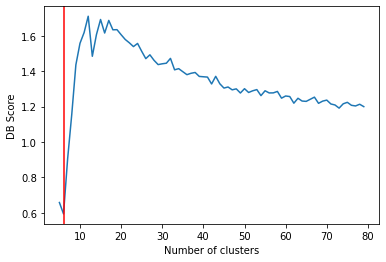

{0, 1, 2, 3, 4, 5}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

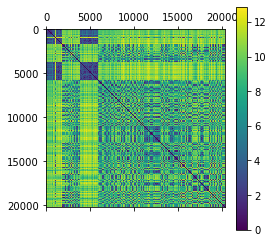

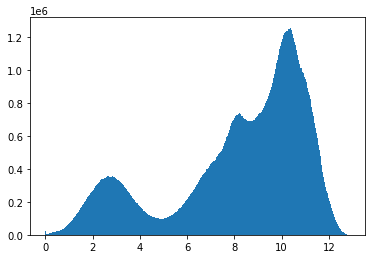

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

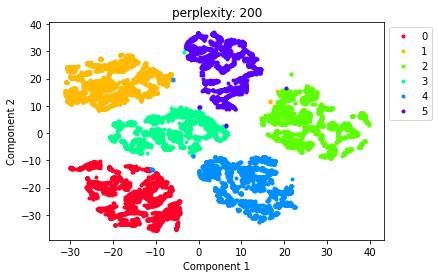

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 12

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9965505346671266


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.055303934861945916
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.7417127071823204
layer 3: 0.494475138121547
layer 4: 0.494475138121547
layer 5: 0.46357044198895025
layer 6: 0.3708563535911602
layer 7: 0.25496374309392267
layer 8: 0.15452348066298344
layer 9: 0.07919328383977901
layer 10: 0.02993892437845304
Epoch: 00 | Batch: 000 / 011 | Total loss: 1.787 | Reg loss: 0.019 | Tree loss: 1.787 | Accuracy: 0.203500 | 15.35 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 1.778 | Reg loss: 0.018 | Tree loss: 1.778 | Accuracy: 0.189500 | 12.134 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 1.769 | Reg loss: 0.017 | Tree loss: 1.769 | Accuracy: 0.282000 | 12.261 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 1.749 | Reg loss: 0.017 | Tree loss: 1.749 | Accuracy: 0.337500 | 12.317 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 1.738 | Reg loss: 0.017 | Tree loss: 1.738 | Accuracy: 0.448000 | 12.307 sec/iter
Epoch: 00 | Batch: 005 / 

Epoch: 04 | Batch: 008 / 011 | Total loss: 1.643 | Reg loss: 0.014 | Tree loss: 1.643 | Accuracy: 0.498000 | 12.981 sec/iter
Epoch: 04 | Batch: 009 / 011 | Total loss: 1.626 | Reg loss: 0.014 | Tree loss: 1.626 | Accuracy: 0.552500 | 12.909 sec/iter
Epoch: 04 | Batch: 010 / 011 | Total loss: 1.598 | Reg loss: 0.014 | Tree loss: 1.598 | Accuracy: 0.638225 | 12.756 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 1.762 | Reg loss: 0.013 | Tree loss: 1.762 | Accuracy: 0.236000 | 13.331 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 1.748 | Reg loss: 0.013 | Tree loss: 1.748 | Accuracy: 0.304500 | 13.254 sec/iter
Epoch: 05 | Batch: 002 / 01

Epoch: 09 | Batch: 005 / 011 | Total loss: 1.556 | Reg loss: 0.014 | Tree loss: 1.556 | Accuracy: 0.579500 | 13.712 sec/iter
Epoch: 09 | Batch: 006 / 011 | Total loss: 1.513 | Reg loss: 0.015 | Tree loss: 1.513 | Accuracy: 0.597000 | 13.69 sec/iter
Epoch: 09 | Batch: 007 / 011 | Total loss: 1.471 | Reg loss: 0.015 | Tree loss: 1.471 | Accuracy: 0.602500 | 13.651 sec/iter
Epoch: 09 | Batch: 008 / 011 | Total loss: 1.469 | Reg loss: 0.015 | Tree loss: 1.469 | Accuracy: 0.598500 | 13.634 sec/iter
Epoch: 09 | Batch: 009 / 011 | Total loss: 1.432 | Reg loss: 0.015 | Tree loss: 1.432 | Accuracy: 0.616500 | 13.627 sec/iter
Epoch: 09 | Batch: 010 / 011 | Total loss: 1.395 | Reg loss: 0.016 | Tree loss: 1.395 | Accuracy: 0.672355 | 13.542 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 14 | Batch: 002 / 011 | Total loss: 1.511 | Reg loss: 0.016 | Tree loss: 1.511 | Accuracy: 0.637500 | 13.764 sec/iter
Epoch: 14 | Batch: 003 / 011 | Total loss: 1.438 | Reg loss: 0.016 | Tree loss: 1.438 | Accuracy: 0.661500 | 13.775 sec/iter
Epoch: 14 | Batch: 004 / 011 | Total loss: 1.387 | Reg loss: 0.016 | Tree loss: 1.387 | Accuracy: 0.665000 | 13.769 sec/iter
Epoch: 14 | Batch: 005 / 011 | Total loss: 1.326 | Reg loss: 0.016 | Tree loss: 1.326 | Accuracy: 0.662500 | 13.778 sec/iter
Epoch: 14 | Batch: 006 / 011 | Total loss: 1.276 | Reg loss: 0.017 | Tree loss: 1.276 | Accuracy: 0.675000 | 13.776 sec/iter
Epoch: 14 | Batch: 007 / 011 | Total loss: 1.247 | Reg loss: 0.017 | Tree loss: 1.247 | Accuracy: 0.693000 | 13.775 sec/iter
Epoch: 14 | Batch: 008 / 011 | Total loss: 1.214 | Reg loss: 0.017 | Tree loss: 1.214 | Accuracy: 0.695000 | 13.763 sec/iter
Epoch: 14 | Batch: 009 / 011 | Total loss: 1.208 | Reg loss: 0.017 | Tree loss: 1.208 | Accuracy: 0.674000 | 13.734 sec/iter


layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 19 | Batch: 000 / 011 | Total loss: 1.424 | Reg loss: 0.018 | Tree loss: 1.424 | Accuracy: 0.721500 | 13.884 sec/iter
Epoch: 19 | Batch: 001 / 011 | Total loss: 1.377 | Reg loss: 0.018 | Tree loss: 1.377 | Accuracy: 0.706000 | 13.865 sec/iter
Epoch: 19 | Batch: 002 / 011 | Total loss: 1.291 | Reg loss: 0.018 | Tree loss: 1.291 | Accuracy: 0.701000 | 13.842 sec/iter
Epoch: 19 | Batch: 003 / 011 | Total loss: 1.219 | Reg loss: 0.018 | Tree loss: 1.219 | Accuracy: 0.721500 | 13.829 sec/iter
Epoch: 19 | Batch: 004 / 011 | Total loss: 1.154 | Reg loss: 0.018 | Tree loss: 1.154 | Accuracy: 0.732000 | 13.803 sec/iter
Epoch: 19 | Batch: 005 / 011 | Total loss: 1.110 | Reg loss: 0.018 | Tree loss: 1.110 | Accuracy: 0.733000 | 13.797 sec/iter
Epoch: 19 | Batch: 006 / 011 | Total loss: 1.062 | Reg loss: 0.018 | Tree loss: 1.062 | Accuracy: 0.726000 | 

Epoch: 23 | Batch: 010 / 011 | Total loss: 0.827 | Reg loss: 0.020 | Tree loss: 0.827 | Accuracy: 0.812287 | 13.694 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 24 | Batch: 000 / 011 | Total loss: 1.249 | Reg loss: 0.020 | Tree loss: 1.249 | Accuracy: 0.704000 | 13.813 sec/iter
Epoch: 24 | Batch: 001 / 011 | Total loss: 1.179 | Reg loss: 0.020 | Tree loss: 1.179 | Accuracy: 0.709500 | 13.811 sec/iter
Epoch: 24 | Batch: 002 / 011 | Total loss: 1.116 | Reg loss: 0.020 | Tree loss: 1.116 | Accuracy: 0.716500 | 13.807 sec/iter
Epoch: 24 | Batch: 003 / 011 | Total loss: 1.063 | Reg loss: 0.020 | Tree loss: 1.063 | Accuracy: 0.710500 | 13.812 sec/iter
Epoch: 24 | Batch: 004 / 01

Epoch: 28 | Batch: 007 / 011 | Total loss: 0.795 | Reg loss: 0.021 | Tree loss: 0.795 | Accuracy: 0.763500 | 13.923 sec/iter
Epoch: 28 | Batch: 008 / 011 | Total loss: 0.781 | Reg loss: 0.021 | Tree loss: 0.781 | Accuracy: 0.784500 | 13.92 sec/iter
Epoch: 28 | Batch: 009 / 011 | Total loss: 0.779 | Reg loss: 0.021 | Tree loss: 0.779 | Accuracy: 0.781000 | 13.914 sec/iter
Epoch: 28 | Batch: 010 / 011 | Total loss: 0.791 | Reg loss: 0.021 | Tree loss: 0.791 | Accuracy: 0.761092 | 13.883 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 29 | Batch: 000 / 011 | Total loss: 1.128 | Reg loss: 0.021 | Tree loss: 1.128 | Accuracy: 0.695500 | 14.013 sec/iter
Epoch: 29 | Batch: 001 / 011

Epoch: 33 | Batch: 004 / 011 | Total loss: 0.824 | Reg loss: 0.022 | Tree loss: 0.824 | Accuracy: 0.767500 | 13.938 sec/iter
Epoch: 33 | Batch: 005 / 011 | Total loss: 0.787 | Reg loss: 0.022 | Tree loss: 0.787 | Accuracy: 0.783000 | 13.925 sec/iter
Epoch: 33 | Batch: 006 / 011 | Total loss: 0.769 | Reg loss: 0.022 | Tree loss: 0.769 | Accuracy: 0.782500 | 13.913 sec/iter
Epoch: 33 | Batch: 007 / 011 | Total loss: 0.743 | Reg loss: 0.022 | Tree loss: 0.743 | Accuracy: 0.781000 | 13.905 sec/iter
Epoch: 33 | Batch: 008 / 011 | Total loss: 0.730 | Reg loss: 0.022 | Tree loss: 0.730 | Accuracy: 0.798500 | 13.891 sec/iter
Epoch: 33 | Batch: 009 / 011 | Total loss: 0.722 | Reg loss: 0.022 | Tree loss: 0.722 | Accuracy: 0.796500 | 13.894 sec/iter
Epoch: 33 | Batch: 010 / 011 | Total loss: 0.689 | Reg loss: 0.022 | Tree loss: 0.689 | Accuracy: 0.839590 | 13.868 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 38 | Batch: 001 / 011 | Total loss: 0.918 | Reg loss: 0.022 | Tree loss: 0.918 | Accuracy: 0.751500 | 13.882 sec/iter
Epoch: 38 | Batch: 002 / 011 | Total loss: 0.859 | Reg loss: 0.022 | Tree loss: 0.859 | Accuracy: 0.767000 | 13.873 sec/iter
Epoch: 38 | Batch: 003 / 011 | Total loss: 0.825 | Reg loss: 0.022 | Tree loss: 0.825 | Accuracy: 0.773000 | 13.863 sec/iter
Epoch: 38 | Batch: 004 / 011 | Total loss: 0.804 | Reg loss: 0.022 | Tree loss: 0.804 | Accuracy: 0.762500 | 13.85 sec/iter
Epoch: 38 | Batch: 005 / 011 | Total loss: 0.736 | Reg loss: 0.022 | Tree loss: 0.736 | Accuracy: 0.796500 | 13.842 sec/iter
Epoch: 38 | Batch: 006 / 011 | Total loss: 0.699 | Reg loss: 0.022 | Tree loss: 0.699 | Accuracy: 0.808000 | 13.84 sec/iter
Epoch: 38 | Batch: 007 / 011 | Total loss: 0.709 | Reg loss: 0.022 | Tree loss: 0.709 | Accuracy: 0.790500 | 13.836 sec/iter
Epoch: 38 | Batch: 008 / 011 | Total loss: 0.710 | Reg loss: 0.022 | Tree loss: 0.710 | Accuracy: 0.782000 | 13.834 sec/iter
Ep

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 43 | Batch: 000 / 011 | Total loss: 0.912 | Reg loss: 0.023 | Tree loss: 0.912 | Accuracy: 0.757000 | 13.963 sec/iter
Epoch: 43 | Batch: 001 / 011 | Total loss: 0.872 | Reg loss: 0.023 | Tree loss: 0.872 | Accuracy: 0.750500 | 13.955 sec/iter
Epoch: 43 | Batch: 002 / 011 | Total loss: 0.790 | Reg loss: 0.023 | Tree loss: 0.790 | Accuracy: 0.779000 | 13.941 sec/iter
Epoch: 43 | Batch: 003 / 011 | Total loss: 0.783 | Reg loss: 0.023 | Tree loss: 0.783 | Accuracy: 0.763000 | 13.927 sec/iter
Epoch: 43 | Batch: 004 / 011 | Total loss: 0.744 | Reg loss: 0.023 | Tree loss: 0.744 | Accuracy: 0.777000 | 13.914 sec/iter
Epoch: 43 | Batch: 005 / 011 | Total loss: 0.711 | Reg loss: 0.023 | Tree loss: 0.711 | Accuracy: 0.798000 | 13.906 sec/iter
Epoch: 43 | Batch: 006 / 011 | Total loss: 0.669 | Reg loss: 0.023 | Tree loss: 0.669 | Accuracy: 0.821500 | 

Epoch: 47 | Batch: 010 / 011 | Total loss: 0.643 | Reg loss: 0.024 | Tree loss: 0.643 | Accuracy: 0.836177 | 13.866 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 48 | Batch: 000 / 011 | Total loss: 0.852 | Reg loss: 0.023 | Tree loss: 0.852 | Accuracy: 0.759500 | 13.943 sec/iter
Epoch: 48 | Batch: 001 / 011 | Total loss: 0.821 | Reg loss: 0.023 | Tree loss: 0.821 | Accuracy: 0.774500 | 13.934 sec/iter
Epoch: 48 | Batch: 002 / 011 | Total loss: 0.775 | Reg loss: 0.023 | Tree loss: 0.775 | Accuracy: 0.773000 | 13.932 sec/iter
Epoch: 48 | Batch: 003 / 011 | Total loss: 0.732 | Reg loss: 0.023 | Tree loss: 0.732 | Accuracy: 0.786500 | 13.93 sec/iter
Epoch: 48 | Batch: 004 / 011

Epoch: 52 | Batch: 007 / 011 | Total loss: 0.624 | Reg loss: 0.024 | Tree loss: 0.624 | Accuracy: 0.831500 | 13.845 sec/iter
Epoch: 52 | Batch: 008 / 011 | Total loss: 0.611 | Reg loss: 0.024 | Tree loss: 0.611 | Accuracy: 0.836500 | 13.835 sec/iter
Epoch: 52 | Batch: 009 / 011 | Total loss: 0.591 | Reg loss: 0.024 | Tree loss: 0.591 | Accuracy: 0.856000 | 13.83 sec/iter
Epoch: 52 | Batch: 010 / 011 | Total loss: 0.610 | Reg loss: 0.024 | Tree loss: 0.610 | Accuracy: 0.849829 | 13.813 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 53 | Batch: 000 / 011 | Total loss: 0.804 | Reg loss: 0.024 | Tree loss: 0.804 | Accuracy: 0.779500 | 13.865 sec/iter
Epoch: 53 | Batch: 001 / 011

Epoch: 57 | Batch: 004 / 011 | Total loss: 0.661 | Reg loss: 0.024 | Tree loss: 0.661 | Accuracy: 0.796000 | 13.893 sec/iter
Epoch: 57 | Batch: 005 / 011 | Total loss: 0.624 | Reg loss: 0.024 | Tree loss: 0.624 | Accuracy: 0.822000 | 13.889 sec/iter
Epoch: 57 | Batch: 006 / 011 | Total loss: 0.615 | Reg loss: 0.024 | Tree loss: 0.615 | Accuracy: 0.837000 | 13.882 sec/iter
Epoch: 57 | Batch: 007 / 011 | Total loss: 0.603 | Reg loss: 0.024 | Tree loss: 0.603 | Accuracy: 0.840500 | 13.882 sec/iter
Epoch: 57 | Batch: 008 / 011 | Total loss: 0.576 | Reg loss: 0.024 | Tree loss: 0.576 | Accuracy: 0.863500 | 13.883 sec/iter
Epoch: 57 | Batch: 009 / 011 | Total loss: 0.583 | Reg loss: 0.024 | Tree loss: 0.583 | Accuracy: 0.858000 | 13.88 sec/iter
Epoch: 57 | Batch: 010 / 011 | Total loss: 0.622 | Reg loss: 0.024 | Tree loss: 0.622 | Accuracy: 0.808874 | 13.866 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
lay

Epoch: 62 | Batch: 001 / 011 | Total loss: 0.743 | Reg loss: 0.025 | Tree loss: 0.743 | Accuracy: 0.772000 | 13.94 sec/iter
Epoch: 62 | Batch: 002 / 011 | Total loss: 0.708 | Reg loss: 0.025 | Tree loss: 0.708 | Accuracy: 0.785500 | 13.935 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 0.668 | Reg loss: 0.025 | Tree loss: 0.668 | Accuracy: 0.802500 | 13.928 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 0.643 | Reg loss: 0.025 | Tree loss: 0.643 | Accuracy: 0.792000 | 13.92 sec/iter
Epoch: 62 | Batch: 005 / 011 | Total loss: 0.618 | Reg loss: 0.025 | Tree loss: 0.618 | Accuracy: 0.803500 | 13.916 sec/iter
Epoch: 62 | Batch: 006 / 011 | Total loss: 0.610 | Reg loss: 0.025 | Tree loss: 0.610 | Accuracy: 0.810500 | 13.908 sec/iter
Epoch: 62 | Batch: 007 / 011 | Total loss: 0.562 | Reg loss: 0.025 | Tree loss: 0.562 | Accuracy: 0.845000 | 13.9 sec/iter
Epoch: 62 | Batch: 008 / 011 | Total loss: 0.577 | Reg loss: 0.025 | Tree loss: 0.577 | Accuracy: 0.841500 | 13.896 sec/iter
Epoc

layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 67 | Batch: 000 / 011 | Total loss: 0.765 | Reg loss: 0.025 | Tree loss: 0.765 | Accuracy: 0.751500 | 13.891 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 0.726 | Reg loss: 0.025 | Tree loss: 0.726 | Accuracy: 0.780000 | 13.886 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 0.667 | Reg loss: 0.025 | Tree loss: 0.667 | Accuracy: 0.802000 | 13.882 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 0.648 | Reg loss: 0.025 | Tree loss: 0.648 | Accuracy: 0.806000 | 13.875 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 0.612 | Reg loss: 0.025 | Tree loss: 0.612 | Accuracy: 0.826500 | 13.868 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 0.592 | Reg loss: 0.025 | Tree loss: 0.592 | Accuracy: 0.850500 | 13.864 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 0.597 | Reg loss: 0.025 | Tree loss: 0.597 | Accuracy: 0.833500 | 13.857 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 0.579 | Reg loss: 0.025 |

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 72 | Batch: 000 / 011 | Total loss: 0.734 | Reg loss: 0.025 | Tree loss: 0.734 | Accuracy: 0.760000 | 13.92 sec/iter
Epoch: 72 | Batch: 001 / 011 | Total loss: 0.723 | Reg loss: 0.025 | Tree loss: 0.723 | Accuracy: 0.777000 | 13.915 sec/iter
Epoch: 72 | Batch: 002 / 011 | Total loss: 0.667 | Reg loss: 0.025 | Tree loss: 0.667 | Accuracy: 0.803500 | 13.912 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 0.641 | Reg loss: 0.025 | Tree loss: 0.641 | Accuracy: 0.792000 | 13.905 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 0.636 | Reg loss: 0.025 | Tree loss: 0.636 | Accuracy: 0.805000 | 13.898 sec/iter
Epoch: 72 | Batch: 005 / 011

Epoch: 76 | Batch: 008 / 011 | Total loss: 0.557 | Reg loss: 0.026 | Tree loss: 0.557 | Accuracy: 0.851000 | 13.9 sec/iter
Epoch: 76 | Batch: 009 / 011 | Total loss: 0.567 | Reg loss: 0.026 | Tree loss: 0.567 | Accuracy: 0.838500 | 13.899 sec/iter
Epoch: 76 | Batch: 010 / 011 | Total loss: 0.603 | Reg loss: 0.026 | Tree loss: 0.603 | Accuracy: 0.829352 | 13.887 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 77 | Batch: 000 / 011 | Total loss: 0.727 | Reg loss: 0.025 | Tree loss: 0.727 | Accuracy: 0.781000 | 13.929 sec/iter
Epoch: 77 | Batch: 001 / 011 | Total loss: 0.707 | Reg loss: 0.025 | Tree loss: 0.707 | Accuracy: 0.772000 | 13.928 sec/iter
Epoch: 77 | Batch: 002 / 011 

Epoch: 81 | Batch: 005 / 011 | Total loss: 0.568 | Reg loss: 0.026 | Tree loss: 0.568 | Accuracy: 0.819500 | 13.893 sec/iter
Epoch: 81 | Batch: 006 / 011 | Total loss: 0.559 | Reg loss: 0.026 | Tree loss: 0.559 | Accuracy: 0.834000 | 13.89 sec/iter
Epoch: 81 | Batch: 007 / 011 | Total loss: 0.551 | Reg loss: 0.026 | Tree loss: 0.551 | Accuracy: 0.843000 | 13.887 sec/iter
Epoch: 81 | Batch: 008 / 011 | Total loss: 0.567 | Reg loss: 0.026 | Tree loss: 0.567 | Accuracy: 0.835500 | 13.887 sec/iter
Epoch: 81 | Batch: 009 / 011 | Total loss: 0.541 | Reg loss: 0.026 | Tree loss: 0.541 | Accuracy: 0.861000 | 13.881 sec/iter
Epoch: 81 | Batch: 010 / 011 | Total loss: 0.593 | Reg loss: 0.026 | Tree loss: 0.593 | Accuracy: 0.822526 | 13.87 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.972375

Epoch: 86 | Batch: 002 / 011 | Total loss: 0.652 | Reg loss: 0.026 | Tree loss: 0.652 | Accuracy: 0.791000 | 13.811 sec/iter
Epoch: 86 | Batch: 003 / 011 | Total loss: 0.644 | Reg loss: 0.026 | Tree loss: 0.644 | Accuracy: 0.788500 | 13.81 sec/iter
Epoch: 86 | Batch: 004 / 011 | Total loss: 0.575 | Reg loss: 0.026 | Tree loss: 0.575 | Accuracy: 0.826000 | 13.808 sec/iter
Epoch: 86 | Batch: 005 / 011 | Total loss: 0.578 | Reg loss: 0.026 | Tree loss: 0.578 | Accuracy: 0.824000 | 13.806 sec/iter
Epoch: 86 | Batch: 006 / 011 | Total loss: 0.572 | Reg loss: 0.026 | Tree loss: 0.572 | Accuracy: 0.825500 | 13.803 sec/iter
Epoch: 86 | Batch: 007 / 011 | Total loss: 0.541 | Reg loss: 0.026 | Tree loss: 0.541 | Accuracy: 0.834500 | 13.798 sec/iter
Epoch: 86 | Batch: 008 / 011 | Total loss: 0.550 | Reg loss: 0.026 | Tree loss: 0.550 | Accuracy: 0.838500 | 13.79 sec/iter
Epoch: 86 | Batch: 009 / 011 | Total loss: 0.551 | Reg loss: 0.026 | Tree loss: 0.551 | Accuracy: 0.851000 | 13.785 sec/iter
Ep

layer 10: 0.9723756906077345
Epoch: 91 | Batch: 000 / 011 | Total loss: 0.704 | Reg loss: 0.026 | Tree loss: 0.704 | Accuracy: 0.773000 | 13.745 sec/iter
Epoch: 91 | Batch: 001 / 011 | Total loss: 0.663 | Reg loss: 0.026 | Tree loss: 0.663 | Accuracy: 0.789000 | 13.741 sec/iter
Epoch: 91 | Batch: 002 / 011 | Total loss: 0.635 | Reg loss: 0.026 | Tree loss: 0.635 | Accuracy: 0.802000 | 13.738 sec/iter
Epoch: 91 | Batch: 003 / 011 | Total loss: 0.619 | Reg loss: 0.026 | Tree loss: 0.619 | Accuracy: 0.802500 | 13.736 sec/iter
Epoch: 91 | Batch: 004 / 011 | Total loss: 0.585 | Reg loss: 0.026 | Tree loss: 0.585 | Accuracy: 0.811000 | 13.735 sec/iter
Epoch: 91 | Batch: 005 / 011 | Total loss: 0.574 | Reg loss: 0.026 | Tree loss: 0.574 | Accuracy: 0.812000 | 13.73 sec/iter
Epoch: 91 | Batch: 006 / 011 | Total loss: 0.545 | Reg loss: 0.026 | Tree loss: 0.545 | Accuracy: 0.830500 | 13.725 sec/iter
Epoch: 91 | Batch: 007 / 011 | Total loss: 0.551 | Reg loss: 0.026 | Tree loss: 0.551 | Accuracy:

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 96 | Batch: 000 / 011 | Total loss: 0.665 | Reg loss: 0.026 | Tree loss: 0.665 | Accuracy: 0.785500 | 13.601 sec/iter
Epoch: 96 | Batch: 001 / 011 | Total loss: 0.672 | Reg loss: 0.026 | Tree loss: 0.672 | Accuracy: 0.787500 | 13.596 sec/iter
Epoch: 96 | Batch: 002 / 011 | Total loss: 0.647 | Reg loss: 0.026 | Tree loss: 0.647 | Accuracy: 0.789500 | 13.591 sec/iter
Epoch: 96 | Batch: 003 / 011 | Total loss: 0.618 | Reg loss: 0.026 | Tree loss: 0.618 | Accuracy: 0.802000 | 13.585 sec/iter
Epoch: 96 | Batch: 004 / 011 | Total loss: 0.604 | Reg loss: 0.026 | Tree loss: 0.604 | Accuracy: 0.805000 | 13.58 sec/iter
Epoch: 96 | Batch: 005 / 011

Epoch: 100 | Batch: 008 / 011 | Total loss: 0.540 | Reg loss: 0.027 | Tree loss: 0.540 | Accuracy: 0.852000 | 13.559 sec/iter
Epoch: 100 | Batch: 009 / 011 | Total loss: 0.524 | Reg loss: 0.027 | Tree loss: 0.524 | Accuracy: 0.843000 | 13.558 sec/iter
Epoch: 100 | Batch: 010 / 011 | Total loss: 0.540 | Reg loss: 0.027 | Tree loss: 0.540 | Accuracy: 0.849829 | 13.549 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 101 | Batch: 000 / 011 | Total loss: 0.682 | Reg loss: 0.027 | Tree loss: 0.682 | Accuracy: 0.777000 | 13.576 sec/iter
Epoch: 101 | Batch: 001 / 011 | Total loss: 0.662 | Reg loss: 0.027 | Tree loss: 0.662 | Accuracy: 0.791000 | 13.573 sec/iter
Epoch: 101 | Batch: 00

Epoch: 105 | Batch: 005 / 011 | Total loss: 0.558 | Reg loss: 0.027 | Tree loss: 0.558 | Accuracy: 0.820000 | 13.506 sec/iter
Epoch: 105 | Batch: 006 / 011 | Total loss: 0.534 | Reg loss: 0.027 | Tree loss: 0.534 | Accuracy: 0.828000 | 13.503 sec/iter
Epoch: 105 | Batch: 007 / 011 | Total loss: 0.539 | Reg loss: 0.027 | Tree loss: 0.539 | Accuracy: 0.829000 | 13.499 sec/iter
Epoch: 105 | Batch: 008 / 011 | Total loss: 0.564 | Reg loss: 0.027 | Tree loss: 0.564 | Accuracy: 0.819500 | 13.499 sec/iter
Epoch: 105 | Batch: 009 / 011 | Total loss: 0.520 | Reg loss: 0.027 | Tree loss: 0.520 | Accuracy: 0.837500 | 13.496 sec/iter
Epoch: 105 | Batch: 010 / 011 | Total loss: 0.488 | Reg loss: 0.027 | Tree loss: 0.488 | Accuracy: 0.856655 | 13.488 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 110 | Batch: 002 / 011 | Total loss: 0.620 | Reg loss: 0.027 | Tree loss: 0.620 | Accuracy: 0.799500 | 13.505 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 0.579 | Reg loss: 0.027 | Tree loss: 0.579 | Accuracy: 0.826500 | 13.503 sec/iter
Epoch: 110 | Batch: 004 / 011 | Total loss: 0.585 | Reg loss: 0.027 | Tree loss: 0.585 | Accuracy: 0.813000 | 13.499 sec/iter
Epoch: 110 | Batch: 005 / 011 | Total loss: 0.548 | Reg loss: 0.027 | Tree loss: 0.548 | Accuracy: 0.831500 | 13.494 sec/iter
Epoch: 110 | Batch: 006 / 011 | Total loss: 0.518 | Reg loss: 0.027 | Tree loss: 0.518 | Accuracy: 0.859000 | 13.488 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 0.528 | Reg loss: 0.027 | Tree loss: 0.528 | Accuracy: 0.852500 | 13.482 sec/iter
Epoch: 110 | Batch: 008 / 011 | Total loss: 0.535 | Reg loss: 0.027 | Tree loss: 0.535 | Accuracy: 0.844000 | 13.479 sec/iter
Epoch: 110 | Batch: 009 / 011 | Total loss: 0.547 | Reg loss: 0.027 | Tree loss: 0.547 | Accuracy: 0.834000 | 13.479 s

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 115 | Batch: 000 / 011 | Total loss: 0.674 | Reg loss: 0.027 | Tree loss: 0.674 | Accuracy: 0.779000 | 13.511 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 0.665 | Reg loss: 0.027 | Tree loss: 0.665 | Accuracy: 0.780500 | 13.505 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 0.610 | Reg loss: 0.027 | Tree loss: 0.610 | Accuracy: 0.811500 | 13.502 sec/iter
Epoch: 115 | Batch: 003 / 011 | Total loss: 0.614 | Reg loss: 0.027 | Tree loss: 0.614 | Accuracy: 0.789500 | 13.499 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 0.558 | Reg loss: 0.027 | Tree loss: 0.558 | Accuracy: 0.821000 | 13.499 sec/iter
Epoch: 115 | Batch: 005 / 011 | Total loss: 0.565 | Reg loss: 0.027 | Tree loss: 0.565 | Accuracy: 0.807000 | 13.498 sec/iter
Epoch: 115 | Batch: 006 / 011 | Total loss: 0.529 | Reg loss: 0.027 | Tree loss: 0.529 | Accuracy: 0.821000 | 13.497 sec/iter
Epoch

Epoch: 119 | Batch: 010 / 011 | Total loss: 0.550 | Reg loss: 0.027 | Tree loss: 0.550 | Accuracy: 0.843003 | 13.448 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 120 | Batch: 000 / 011 | Total loss: 0.665 | Reg loss: 0.027 | Tree loss: 0.665 | Accuracy: 0.776500 | 13.456 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 0.638 | Reg loss: 0.027 | Tree loss: 0.638 | Accuracy: 0.783500 | 13.452 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 0.623 | Reg loss: 0.027 | Tree loss: 0.623 | Accuracy: 0.798000 | 13.449 sec/iter
Epoch: 120 | Batch: 003 / 011 | Total loss: 0.578 | Reg loss: 0.027 | Tree loss: 0.578 | Accuracy: 0.809500 | 13.448 sec/iter
Epoch: 120 | Batch: 00

Epoch: 124 | Batch: 007 / 011 | Total loss: 0.514 | Reg loss: 0.027 | Tree loss: 0.514 | Accuracy: 0.839500 | 13.383 sec/iter
Epoch: 124 | Batch: 008 / 011 | Total loss: 0.523 | Reg loss: 0.027 | Tree loss: 0.523 | Accuracy: 0.847000 | 13.382 sec/iter
Epoch: 124 | Batch: 009 / 011 | Total loss: 0.507 | Reg loss: 0.027 | Tree loss: 0.507 | Accuracy: 0.852000 | 13.379 sec/iter
Epoch: 124 | Batch: 010 / 011 | Total loss: 0.531 | Reg loss: 0.027 | Tree loss: 0.531 | Accuracy: 0.836177 | 13.373 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 125 | Batch: 000 / 011 | Total loss: 0.668 | Reg loss: 0.027 | Tree loss: 0.668 | Accuracy: 0.790500 | 13.378 sec/iter
Epoch: 125 | Batch: 00

Epoch: 129 | Batch: 004 / 011 | Total loss: 0.561 | Reg loss: 0.027 | Tree loss: 0.561 | Accuracy: 0.819500 | 13.311 sec/iter
Epoch: 129 | Batch: 005 / 011 | Total loss: 0.572 | Reg loss: 0.027 | Tree loss: 0.572 | Accuracy: 0.787500 | 13.31 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 0.536 | Reg loss: 0.027 | Tree loss: 0.536 | Accuracy: 0.823500 | 13.308 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 0.497 | Reg loss: 0.028 | Tree loss: 0.497 | Accuracy: 0.843000 | 13.305 sec/iter
Epoch: 129 | Batch: 008 / 011 | Total loss: 0.507 | Reg loss: 0.028 | Tree loss: 0.507 | Accuracy: 0.847000 | 13.302 sec/iter
Epoch: 129 | Batch: 009 / 011 | Total loss: 0.512 | Reg loss: 0.028 | Tree loss: 0.512 | Accuracy: 0.835500 | 13.299 sec/iter
Epoch: 129 | Batch: 010 / 011 | Total loss: 0.569 | Reg loss: 0.028 | Tree loss: 0.569 | Accuracy: 0.839590 | 13.293 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 134 | Batch: 001 / 011 | Total loss: 0.627 | Reg loss: 0.028 | Tree loss: 0.627 | Accuracy: 0.795000 | 13.369 sec/iter
Epoch: 134 | Batch: 002 / 011 | Total loss: 0.612 | Reg loss: 0.028 | Tree loss: 0.612 | Accuracy: 0.804500 | 13.368 sec/iter
Epoch: 134 | Batch: 003 / 011 | Total loss: 0.561 | Reg loss: 0.028 | Tree loss: 0.561 | Accuracy: 0.822000 | 13.367 sec/iter
Epoch: 134 | Batch: 004 / 011 | Total loss: 0.552 | Reg loss: 0.028 | Tree loss: 0.552 | Accuracy: 0.826000 | 13.366 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 0.554 | Reg loss: 0.028 | Tree loss: 0.554 | Accuracy: 0.817500 | 13.366 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.515 | Reg loss: 0.028 | Tree loss: 0.515 | Accuracy: 0.848500 | 13.365 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.537 | Reg loss: 0.028 | Tree loss: 0.537 | Accuracy: 0.840500 | 13.366 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 0.512 | Reg loss: 0.028 | Tree loss: 0.512 | Accuracy: 0.856500 | 13.366 s

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 139 | Batch: 000 / 011 | Total loss: 0.664 | Reg loss: 0.028 | Tree loss: 0.664 | Accuracy: 0.762500 | 13.42 sec/iter
Epoch: 139 | Batch: 001 / 011 | Total loss: 0.650 | Reg loss: 0.028 | Tree loss: 0.650 | Accuracy: 0.788000 | 13.419 sec/iter
Epoch: 139 | Batch: 002 / 011 | Total loss: 0.591 | Reg loss: 0.028 | Tree loss: 0.591 | Accuracy: 0.814500 | 13.418 sec/iter
Epoch: 139 | Batch: 003 / 011 | Total loss: 0.573 | Reg loss: 0.028 | Tree loss: 0.573 | Accuracy: 0.812000 | 13.417 sec/iter
Epoch: 139 | Batch: 004 / 011 | Total loss: 0.557 | Reg loss: 0.028 | Tree loss: 0.557 | Accuracy: 0.818000 | 13.416 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 0.535 | Reg loss: 0.028 | Tree loss: 0.535 | Accuracy: 0.827000 | 13.415 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 0.528 | Reg loss: 0.028 | Tree loss: 0.528 | Accuracy: 0.836500 | 13.414 sec/iter
Epoch: 139 | Batch: 007 / 011 | To

Epoch: 143 | Batch: 010 / 011 | Total loss: 0.489 | Reg loss: 0.028 | Tree loss: 0.489 | Accuracy: 0.853242 | 13.491 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 144 | Batch: 000 / 011 | Total loss: 0.643 | Reg loss: 0.028 | Tree loss: 0.643 | Accuracy: 0.797000 | 13.526 sec/iter
Epoch: 144 | Batch: 001 / 011 | Total loss: 0.626 | Reg loss: 0.028 | Tree loss: 0.626 | Accuracy: 0.799500 | 13.523 sec/iter
Epoch: 144 | Batch: 002 / 011 | Total loss: 0.607 | Reg loss: 0.028 | Tree loss: 0.607 | Accuracy: 0.790000 | 13.52 sec/iter
Epoch: 144 | Batch: 003 / 011 | Total loss: 0.593 | Reg loss: 0.028 | Tree loss: 0.593 | Accuracy: 0.806000 | 13.517 sec/iter
Epoch: 144 | Batch: 004

Epoch: 148 | Batch: 007 / 011 | Total loss: 0.509 | Reg loss: 0.028 | Tree loss: 0.509 | Accuracy: 0.844500 | 13.545 sec/iter
Epoch: 148 | Batch: 008 / 011 | Total loss: 0.513 | Reg loss: 0.028 | Tree loss: 0.513 | Accuracy: 0.857000 | 13.542 sec/iter
Epoch: 148 | Batch: 009 / 011 | Total loss: 0.515 | Reg loss: 0.028 | Tree loss: 0.515 | Accuracy: 0.839500 | 13.541 sec/iter
Epoch: 148 | Batch: 010 / 011 | Total loss: 0.446 | Reg loss: 0.028 | Tree loss: 0.446 | Accuracy: 0.866894 | 13.535 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 149 | Batch: 000 / 011 | Total loss: 0.663 | Reg loss: 0.028 | Tree loss: 0.663 | Accuracy: 0.785500 | 13.574 sec/iter
Epoch: 149 | Batch: 00

Epoch: 153 | Batch: 004 / 011 | Total loss: 0.528 | Reg loss: 0.028 | Tree loss: 0.528 | Accuracy: 0.823000 | 13.602 sec/iter
Epoch: 153 | Batch: 005 / 011 | Total loss: 0.546 | Reg loss: 0.028 | Tree loss: 0.546 | Accuracy: 0.807000 | 13.603 sec/iter
Epoch: 153 | Batch: 006 / 011 | Total loss: 0.524 | Reg loss: 0.028 | Tree loss: 0.524 | Accuracy: 0.828000 | 13.603 sec/iter
Epoch: 153 | Batch: 007 / 011 | Total loss: 0.492 | Reg loss: 0.028 | Tree loss: 0.492 | Accuracy: 0.843000 | 13.602 sec/iter
Epoch: 153 | Batch: 008 / 011 | Total loss: 0.512 | Reg loss: 0.028 | Tree loss: 0.512 | Accuracy: 0.840000 | 13.601 sec/iter
Epoch: 153 | Batch: 009 / 011 | Total loss: 0.479 | Reg loss: 0.028 | Tree loss: 0.479 | Accuracy: 0.869500 | 13.599 sec/iter
Epoch: 153 | Batch: 010 / 011 | Total loss: 0.539 | Reg loss: 0.028 | Tree loss: 0.539 | Accuracy: 0.839590 | 13.593 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 158 | Batch: 001 / 011 | Total loss: 0.626 | Reg loss: 0.028 | Tree loss: 0.626 | Accuracy: 0.797000 | 13.663 sec/iter
Epoch: 158 | Batch: 002 / 011 | Total loss: 0.600 | Reg loss: 0.028 | Tree loss: 0.600 | Accuracy: 0.804500 | 13.664 sec/iter
Epoch: 158 | Batch: 003 / 011 | Total loss: 0.555 | Reg loss: 0.028 | Tree loss: 0.555 | Accuracy: 0.825000 | 13.665 sec/iter
Epoch: 158 | Batch: 004 / 011 | Total loss: 0.537 | Reg loss: 0.028 | Tree loss: 0.537 | Accuracy: 0.825000 | 13.663 sec/iter
Epoch: 158 | Batch: 005 / 011 | Total loss: 0.497 | Reg loss: 0.028 | Tree loss: 0.497 | Accuracy: 0.850500 | 13.66 sec/iter
Epoch: 158 | Batch: 006 / 011 | Total loss: 0.515 | Reg loss: 0.028 | Tree loss: 0.515 | Accuracy: 0.849500 | 13.658 sec/iter
Epoch: 158 | Batch: 007 / 011 | Total loss: 0.511 | Reg loss: 0.028 | Tree loss: 0.511 | Accuracy: 0.849000 | 13.654 sec/iter
Epoch: 158 | Batch: 008 / 011 | Total loss: 0.507 | Reg loss: 0.028 | Tree loss: 0.507 | Accuracy: 0.850000 | 13.652 se

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 163 | Batch: 000 / 011 | Total loss: 0.651 | Reg loss: 0.028 | Tree loss: 0.651 | Accuracy: 0.791000 | 13.724 sec/iter
Epoch: 163 | Batch: 001 / 011 | Total loss: 0.616 | Reg loss: 0.028 | Tree loss: 0.616 | Accuracy: 0.800000 | 13.723 sec/iter
Epoch: 163 | Batch: 002 / 011 | Total loss: 0.620 | Reg loss: 0.028 | Tree loss: 0.620 | Accuracy: 0.796500 | 13.721 sec/iter
Epoch: 163 | Batch: 003 / 011 | Total loss: 0.566 | Reg loss: 0.028 | Tree loss: 0.566 | Accuracy: 0.820000 | 13.718 sec/iter
Epoch: 163 | Batch: 004 / 011 | Total loss: 0.529 | Reg loss: 0.028 | Tree loss: 0.529 | Accuracy: 0.827000 | 13.715 sec/iter
Epoch: 163 | Batch: 005 / 011 | Total loss: 0.513 | Reg loss: 0.028 | Tree loss: 0.513 | Accuracy: 0.828000 | 13.714 sec/iter
Epoch: 163 | Batch: 006 / 011 | Total loss: 0.508 | Reg loss: 0.028 | Tree loss: 0.508 | Accuracy: 0.837000 | 13.713 sec/iter
Epoch

Epoch: 167 | Batch: 010 / 011 | Total loss: 0.495 | Reg loss: 0.028 | Tree loss: 0.495 | Accuracy: 0.822526 | 13.742 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 168 | Batch: 000 / 011 | Total loss: 0.640 | Reg loss: 0.028 | Tree loss: 0.640 | Accuracy: 0.784500 | 13.783 sec/iter
Epoch: 168 | Batch: 001 / 011 | Total loss: 0.624 | Reg loss: 0.028 | Tree loss: 0.624 | Accuracy: 0.785000 | 13.781 sec/iter
Epoch: 168 | Batch: 002 / 011 | Total loss: 0.592 | Reg loss: 0.028 | Tree loss: 0.592 | Accuracy: 0.800000 | 13.778 sec/iter
Epoch: 168 | Batch: 003 / 011 | Total loss: 0.551 | Reg loss: 0.028 | Tree loss: 0.551 | Accuracy: 0.825500 | 13.775 sec/iter
Epoch: 168 | Batch: 00

Epoch: 172 | Batch: 007 / 011 | Total loss: 0.488 | Reg loss: 0.028 | Tree loss: 0.488 | Accuracy: 0.858000 | 13.809 sec/iter
Epoch: 172 | Batch: 008 / 011 | Total loss: 0.500 | Reg loss: 0.028 | Tree loss: 0.500 | Accuracy: 0.852500 | 13.808 sec/iter
Epoch: 172 | Batch: 009 / 011 | Total loss: 0.479 | Reg loss: 0.028 | Tree loss: 0.479 | Accuracy: 0.864500 | 13.808 sec/iter
Epoch: 172 | Batch: 010 / 011 | Total loss: 0.510 | Reg loss: 0.028 | Tree loss: 0.510 | Accuracy: 0.839590 | 13.802 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 173 | Batch: 000 / 011 | Total loss: 0.647 | Reg loss: 0.028 | Tree loss: 0.647 | Accuracy: 0.787500 | 13.823 sec/iter
Epoch: 173 | Batch: 00

Epoch: 177 | Batch: 004 / 011 | Total loss: 0.548 | Reg loss: 0.028 | Tree loss: 0.548 | Accuracy: 0.810500 | 13.841 sec/iter
Epoch: 177 | Batch: 005 / 011 | Total loss: 0.507 | Reg loss: 0.028 | Tree loss: 0.507 | Accuracy: 0.835000 | 13.841 sec/iter
Epoch: 177 | Batch: 006 / 011 | Total loss: 0.493 | Reg loss: 0.028 | Tree loss: 0.493 | Accuracy: 0.843000 | 13.84 sec/iter
Epoch: 177 | Batch: 007 / 011 | Total loss: 0.482 | Reg loss: 0.028 | Tree loss: 0.482 | Accuracy: 0.859000 | 13.838 sec/iter
Epoch: 177 | Batch: 008 / 011 | Total loss: 0.472 | Reg loss: 0.028 | Tree loss: 0.472 | Accuracy: 0.869000 | 13.837 sec/iter
Epoch: 177 | Batch: 009 / 011 | Total loss: 0.472 | Reg loss: 0.028 | Tree loss: 0.472 | Accuracy: 0.859000 | 13.835 sec/iter
Epoch: 177 | Batch: 010 / 011 | Total loss: 0.563 | Reg loss: 0.029 | Tree loss: 0.563 | Accuracy: 0.805461 | 13.83 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.97237569060773

Epoch: 182 | Batch: 001 / 011 | Total loss: 0.613 | Reg loss: 0.028 | Tree loss: 0.613 | Accuracy: 0.806500 | 13.907 sec/iter
Epoch: 182 | Batch: 002 / 011 | Total loss: 0.574 | Reg loss: 0.028 | Tree loss: 0.574 | Accuracy: 0.809500 | 13.905 sec/iter
Epoch: 182 | Batch: 003 / 011 | Total loss: 0.546 | Reg loss: 0.028 | Tree loss: 0.546 | Accuracy: 0.817500 | 13.904 sec/iter
Epoch: 182 | Batch: 004 / 011 | Total loss: 0.560 | Reg loss: 0.029 | Tree loss: 0.560 | Accuracy: 0.808000 | 13.902 sec/iter
Epoch: 182 | Batch: 005 / 011 | Total loss: 0.520 | Reg loss: 0.029 | Tree loss: 0.520 | Accuracy: 0.833500 | 13.901 sec/iter
Epoch: 182 | Batch: 006 / 011 | Total loss: 0.477 | Reg loss: 0.029 | Tree loss: 0.477 | Accuracy: 0.861500 | 13.9 sec/iter
Epoch: 182 | Batch: 007 / 011 | Total loss: 0.506 | Reg loss: 0.029 | Tree loss: 0.506 | Accuracy: 0.844500 | 13.899 sec/iter
Epoch: 182 | Batch: 008 / 011 | Total loss: 0.490 | Reg loss: 0.029 | Tree loss: 0.490 | Accuracy: 0.863500 | 13.898 sec

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 187 | Batch: 000 / 011 | Total loss: 0.627 | Reg loss: 0.029 | Tree loss: 0.627 | Accuracy: 0.785000 | 13.932 sec/iter
Epoch: 187 | Batch: 001 / 011 | Total loss: 0.618 | Reg loss: 0.029 | Tree loss: 0.618 | Accuracy: 0.798500 | 13.931 sec/iter
Epoch: 187 | Batch: 002 / 011 | Total loss: 0.590 | Reg loss: 0.029 | Tree loss: 0.590 | Accuracy: 0.796500 | 13.93 sec/iter
Epoch: 187 | Batch: 003 / 011 | Total loss: 0.560 | Reg loss: 0.029 | Tree loss: 0.560 | Accuracy: 0.812000 | 13.931 sec/iter
Epoch: 187 | Batch: 004 / 011 | Total loss: 0.531 | Reg loss: 0.029 | Tree loss: 0.531 | Accuracy: 0.826000 | 13.932 sec/iter
Epoch: 187 | Batch: 005 / 011 | Total loss: 0.509 | Reg loss: 0.029 | Tree loss: 0.509 | Accuracy: 0.843500 | 13.933 sec/iter
Epoch: 187 | Batch: 006 / 011 | Total loss: 0.507 | Reg loss: 0.029 | Tree loss: 0.507 | Accuracy: 0.846500 | 13.932 sec/iter
Epoch:

Epoch: 191 | Batch: 010 / 011 | Total loss: 0.475 | Reg loss: 0.029 | Tree loss: 0.475 | Accuracy: 0.839590 | 13.961 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 192 | Batch: 000 / 011 | Total loss: 0.639 | Reg loss: 0.029 | Tree loss: 0.639 | Accuracy: 0.785500 | 13.995 sec/iter
Epoch: 192 | Batch: 001 / 011 | Total loss: 0.622 | Reg loss: 0.029 | Tree loss: 0.622 | Accuracy: 0.795000 | 13.991 sec/iter
Epoch: 192 | Batch: 002 / 011 | Total loss: 0.587 | Reg loss: 0.029 | Tree loss: 0.587 | Accuracy: 0.806500 | 13.988 sec/iter
Epoch: 192 | Batch: 003 / 011 | Total loss: 0.552 | Reg loss: 0.029 | Tree loss: 0.552 | Accuracy: 0.826000 | 13.985 sec/iter
Epoch: 192 | Batch: 00

Epoch: 196 | Batch: 007 / 011 | Total loss: 0.486 | Reg loss: 0.029 | Tree loss: 0.486 | Accuracy: 0.862000 | 13.999 sec/iter
Epoch: 196 | Batch: 008 / 011 | Total loss: 0.483 | Reg loss: 0.029 | Tree loss: 0.483 | Accuracy: 0.856000 | 13.996 sec/iter
Epoch: 196 | Batch: 009 / 011 | Total loss: 0.484 | Reg loss: 0.029 | Tree loss: 0.484 | Accuracy: 0.852000 | 13.993 sec/iter
Epoch: 196 | Batch: 010 / 011 | Total loss: 0.538 | Reg loss: 0.029 | Tree loss: 0.538 | Accuracy: 0.795222 | 13.989 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 197 | Batch: 000 / 011 | Total loss: 0.617 | Reg loss: 0.029 | Tree loss: 0.617 | Accuracy: 0.800500 | 14.01 sec/iter
Epoch: 197 | Batch: 001

Epoch: 201 | Batch: 004 / 011 | Total loss: 0.544 | Reg loss: 0.029 | Tree loss: 0.544 | Accuracy: 0.809000 | 14.05 sec/iter
Epoch: 201 | Batch: 005 / 011 | Total loss: 0.502 | Reg loss: 0.029 | Tree loss: 0.502 | Accuracy: 0.840500 | 14.049 sec/iter
Epoch: 201 | Batch: 006 / 011 | Total loss: 0.488 | Reg loss: 0.029 | Tree loss: 0.488 | Accuracy: 0.847500 | 14.048 sec/iter
Epoch: 201 | Batch: 007 / 011 | Total loss: 0.495 | Reg loss: 0.029 | Tree loss: 0.495 | Accuracy: 0.849500 | 14.049 sec/iter
Epoch: 201 | Batch: 008 / 011 | Total loss: 0.497 | Reg loss: 0.029 | Tree loss: 0.497 | Accuracy: 0.845500 | 14.05 sec/iter
Epoch: 201 | Batch: 009 / 011 | Total loss: 0.501 | Reg loss: 0.029 | Tree loss: 0.501 | Accuracy: 0.845000 | 14.05 sec/iter
Epoch: 201 | Batch: 010 / 011 | Total loss: 0.463 | Reg loss: 0.029 | Tree loss: 0.463 | Accuracy: 0.839590 | 14.046 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607734

Epoch: 206 | Batch: 001 / 011 | Total loss: 0.602 | Reg loss: 0.029 | Tree loss: 0.602 | Accuracy: 0.797000 | 14.072 sec/iter
Epoch: 206 | Batch: 002 / 011 | Total loss: 0.561 | Reg loss: 0.029 | Tree loss: 0.561 | Accuracy: 0.823500 | 14.071 sec/iter
Epoch: 206 | Batch: 003 / 011 | Total loss: 0.551 | Reg loss: 0.029 | Tree loss: 0.551 | Accuracy: 0.811000 | 14.07 sec/iter
Epoch: 206 | Batch: 004 / 011 | Total loss: 0.530 | Reg loss: 0.029 | Tree loss: 0.530 | Accuracy: 0.812500 | 14.07 sec/iter
Epoch: 206 | Batch: 005 / 011 | Total loss: 0.509 | Reg loss: 0.029 | Tree loss: 0.509 | Accuracy: 0.831000 | 14.069 sec/iter
Epoch: 206 | Batch: 006 / 011 | Total loss: 0.495 | Reg loss: 0.029 | Tree loss: 0.495 | Accuracy: 0.859500 | 14.068 sec/iter
Epoch: 206 | Batch: 007 / 011 | Total loss: 0.495 | Reg loss: 0.029 | Tree loss: 0.495 | Accuracy: 0.855500 | 14.067 sec/iter
Epoch: 206 | Batch: 008 / 011 | Total loss: 0.502 | Reg loss: 0.029 | Tree loss: 0.502 | Accuracy: 0.855500 | 14.066 sec

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 211 | Batch: 000 / 011 | Total loss: 0.633 | Reg loss: 0.029 | Tree loss: 0.633 | Accuracy: 0.781500 | 14.1 sec/iter
Epoch: 211 | Batch: 001 / 011 | Total loss: 0.613 | Reg loss: 0.029 | Tree loss: 0.613 | Accuracy: 0.798000 | 14.101 sec/iter
Epoch: 211 | Batch: 002 / 011 | Total loss: 0.571 | Reg loss: 0.029 | Tree loss: 0.571 | Accuracy: 0.810500 | 14.101 sec/iter
Epoch: 211 | Batch: 003 / 011 | Total loss: 0.544 | Reg loss: 0.029 | Tree loss: 0.544 | Accuracy: 0.813000 | 14.101 sec/iter
Epoch: 211 | Batch: 004 / 011 | Total loss: 0.528 | Reg loss: 0.029 | Tree loss: 0.528 | Accuracy: 0.816000 | 14.1 sec/iter
Epoch: 211 | Batch: 005 / 011 | Total loss: 0.482 | Reg loss: 0.029 | Tree loss: 0.482 | Accuracy: 0.840000 | 14.097 sec/iter
Epoch: 211 | Batch: 006 / 011 | Total loss: 0.503 | Reg loss: 0.029 | Tree loss: 0.503 | Accuracy: 0.837500 | 14.095 sec/iter
Epoch: 211 | Batch: 007 / 011 | Total

Epoch: 215 | Batch: 010 / 011 | Total loss: 0.473 | Reg loss: 0.029 | Tree loss: 0.473 | Accuracy: 0.843003 | 14.131 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 216 | Batch: 000 / 011 | Total loss: 0.630 | Reg loss: 0.029 | Tree loss: 0.630 | Accuracy: 0.790000 | 14.143 sec/iter
Epoch: 216 | Batch: 001 / 011 | Total loss: 0.606 | Reg loss: 0.029 | Tree loss: 0.606 | Accuracy: 0.801500 | 14.142 sec/iter
Epoch: 216 | Batch: 002 / 011 | Total loss: 0.562 | Reg loss: 0.029 | Tree loss: 0.562 | Accuracy: 0.814500 | 14.141 sec/iter
Epoch: 216 | Batch: 003 / 011 | Total loss: 0.532 | Reg loss: 0.029 | Tree loss: 0.532 | Accuracy: 0.818000 | 14.142 sec/iter
Epoch: 216 | Batch: 00

Epoch: 220 | Batch: 007 / 011 | Total loss: 0.480 | Reg loss: 0.029 | Tree loss: 0.480 | Accuracy: 0.851500 | 14.153 sec/iter
Epoch: 220 | Batch: 008 / 011 | Total loss: 0.467 | Reg loss: 0.029 | Tree loss: 0.467 | Accuracy: 0.862500 | 14.152 sec/iter
Epoch: 220 | Batch: 009 / 011 | Total loss: 0.483 | Reg loss: 0.029 | Tree loss: 0.483 | Accuracy: 0.860000 | 14.151 sec/iter
Epoch: 220 | Batch: 010 / 011 | Total loss: 0.459 | Reg loss: 0.029 | Tree loss: 0.459 | Accuracy: 0.890785 | 14.146 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 221 | Batch: 000 / 011 | Total loss: 0.618 | Reg loss: 0.029 | Tree loss: 0.618 | Accuracy: 0.800500 | 14.153 sec/iter
Epoch: 221 | Batch: 00

Epoch: 225 | Batch: 004 / 011 | Total loss: 0.531 | Reg loss: 0.029 | Tree loss: 0.531 | Accuracy: 0.818500 | 14.173 sec/iter
Epoch: 225 | Batch: 005 / 011 | Total loss: 0.498 | Reg loss: 0.029 | Tree loss: 0.498 | Accuracy: 0.836500 | 14.173 sec/iter
Epoch: 225 | Batch: 006 / 011 | Total loss: 0.508 | Reg loss: 0.029 | Tree loss: 0.508 | Accuracy: 0.829500 | 14.172 sec/iter
Epoch: 225 | Batch: 007 / 011 | Total loss: 0.471 | Reg loss: 0.029 | Tree loss: 0.471 | Accuracy: 0.860500 | 14.171 sec/iter
Epoch: 225 | Batch: 008 / 011 | Total loss: 0.481 | Reg loss: 0.029 | Tree loss: 0.481 | Accuracy: 0.843000 | 14.168 sec/iter
Epoch: 225 | Batch: 009 / 011 | Total loss: 0.490 | Reg loss: 0.029 | Tree loss: 0.490 | Accuracy: 0.861000 | 14.165 sec/iter
Epoch: 225 | Batch: 010 / 011 | Total loss: 0.507 | Reg loss: 0.029 | Tree loss: 0.507 | Accuracy: 0.825939 | 14.161 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 230 | Batch: 001 / 011 | Total loss: 0.602 | Reg loss: 0.029 | Tree loss: 0.602 | Accuracy: 0.791500 | 14.22 sec/iter
Epoch: 230 | Batch: 002 / 011 | Total loss: 0.553 | Reg loss: 0.029 | Tree loss: 0.553 | Accuracy: 0.819500 | 14.218 sec/iter
Epoch: 230 | Batch: 003 / 011 | Total loss: 0.547 | Reg loss: 0.029 | Tree loss: 0.547 | Accuracy: 0.816000 | 14.218 sec/iter
Epoch: 230 | Batch: 004 / 011 | Total loss: 0.510 | Reg loss: 0.029 | Tree loss: 0.510 | Accuracy: 0.833500 | 14.218 sec/iter
Epoch: 230 | Batch: 005 / 011 | Total loss: 0.508 | Reg loss: 0.029 | Tree loss: 0.508 | Accuracy: 0.826500 | 14.217 sec/iter
Epoch: 230 | Batch: 006 / 011 | Total loss: 0.488 | Reg loss: 0.029 | Tree loss: 0.488 | Accuracy: 0.859500 | 14.216 sec/iter
Epoch: 230 | Batch: 007 / 011 | Total loss: 0.476 | Reg loss: 0.029 | Tree loss: 0.476 | Accuracy: 0.857000 | 14.215 sec/iter
Epoch: 230 | Batch: 008 / 011 | Total loss: 0.494 | Reg loss: 0.029 | Tree loss: 0.494 | Accuracy: 0.856000 | 14.214 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 235 | Batch: 000 / 011 | Total loss: 0.635 | Reg loss: 0.029 | Tree loss: 0.635 | Accuracy: 0.787500 | 14.228 sec/iter
Epoch: 235 | Batch: 001 / 011 | Total loss: 0.588 | Reg loss: 0.029 | Tree loss: 0.588 | Accuracy: 0.799000 | 14.227 sec/iter
Epoch: 235 | Batch: 002 / 011 | Total loss: 0.553 | Reg loss: 0.029 | Tree loss: 0.553 | Accuracy: 0.814500 | 14.227 sec/iter
Epoch: 235 | Batch: 003 / 011 | Total loss: 0.543 | Reg loss: 0.029 | Tree loss: 0.543 | Accuracy: 0.806500 | 14.226 sec/iter
Epoch: 235 | Batch: 004 / 011 | Total loss: 0.531 | Reg loss: 0.029 | Tree loss: 0.531 | Accuracy: 0.816500 | 14.225 sec/iter
Epoch: 235 | Batch: 00

Epoch: 239 | Batch: 008 / 011 | Total loss: 0.492 | Reg loss: 0.029 | Tree loss: 0.492 | Accuracy: 0.854000 | 14.25 sec/iter
Epoch: 239 | Batch: 009 / 011 | Total loss: 0.470 | Reg loss: 0.029 | Tree loss: 0.470 | Accuracy: 0.863500 | 14.25 sec/iter
Epoch: 239 | Batch: 010 / 011 | Total loss: 0.441 | Reg loss: 0.029 | Tree loss: 0.441 | Accuracy: 0.863481 | 14.246 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 240 | Batch: 000 / 011 | Total loss: 0.627 | Reg loss: 0.029 | Tree loss: 0.627 | Accuracy: 0.784500 | 14.269 sec/iter
Epoch: 240 | Batch: 001 / 011 | Total loss: 0.607 | Reg loss: 0.029 | Tree loss: 0.607 | Accuracy: 0.796500 | 14.266 sec/iter
Epoch: 240 | Batch: 002 

Epoch: 244 | Batch: 005 / 011 | Total loss: 0.497 | Reg loss: 0.029 | Tree loss: 0.497 | Accuracy: 0.838000 | 14.279 sec/iter
Epoch: 244 | Batch: 006 / 011 | Total loss: 0.475 | Reg loss: 0.029 | Tree loss: 0.475 | Accuracy: 0.855000 | 14.279 sec/iter
Epoch: 244 | Batch: 007 / 011 | Total loss: 0.490 | Reg loss: 0.029 | Tree loss: 0.490 | Accuracy: 0.847000 | 14.28 sec/iter
Epoch: 244 | Batch: 008 / 011 | Total loss: 0.481 | Reg loss: 0.029 | Tree loss: 0.481 | Accuracy: 0.861000 | 14.279 sec/iter
Epoch: 244 | Batch: 009 / 011 | Total loss: 0.483 | Reg loss: 0.029 | Tree loss: 0.483 | Accuracy: 0.850000 | 14.278 sec/iter
Epoch: 244 | Batch: 010 / 011 | Total loss: 0.431 | Reg loss: 0.029 | Tree loss: 0.431 | Accuracy: 0.904437 | 14.275 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 249 | Batch: 002 / 011 | Total loss: 0.563 | Reg loss: 0.029 | Tree loss: 0.563 | Accuracy: 0.803500 | 14.29 sec/iter
Epoch: 249 | Batch: 003 / 011 | Total loss: 0.538 | Reg loss: 0.029 | Tree loss: 0.538 | Accuracy: 0.817000 | 14.289 sec/iter
Epoch: 249 | Batch: 004 / 011 | Total loss: 0.510 | Reg loss: 0.029 | Tree loss: 0.510 | Accuracy: 0.827500 | 14.288 sec/iter
Epoch: 249 | Batch: 005 / 011 | Total loss: 0.493 | Reg loss: 0.029 | Tree loss: 0.493 | Accuracy: 0.853000 | 14.287 sec/iter
Epoch: 249 | Batch: 006 / 011 | Total loss: 0.480 | Reg loss: 0.029 | Tree loss: 0.480 | Accuracy: 0.871500 | 14.287 sec/iter
Epoch: 249 | Batch: 007 / 011 | Total loss: 0.483 | Reg loss: 0.029 | Tree loss: 0.483 | Accuracy: 0.853000 | 14.285 sec/iter
Epoch: 249 | Batch: 008 / 011 | Total loss: 0.489 | Reg loss: 0.029 | Tree loss: 0.489 | Accuracy: 0.858000 | 14.282 sec/iter
Epoch: 249 | Batch: 009 / 011 | Total loss: 0.487 | Reg loss: 0.029 | Tree loss: 0.487 | Accuracy: 0.848000 | 14.281 se

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 254 | Batch: 000 / 011 | Total loss: 0.597 | Reg loss: 0.029 | Tree loss: 0.597 | Accuracy: 0.802000 | 14.332 sec/iter
Epoch: 254 | Batch: 001 / 011 | Total loss: 0.612 | Reg loss: 0.029 | Tree loss: 0.612 | Accuracy: 0.781000 | 14.332 sec/iter
Epoch: 254 | Batch: 002 / 011 | Total loss: 0.579 | Reg loss: 0.029 | Tree loss: 0.579 | Accuracy: 0.800000 | 14.331 sec/iter
Epoch: 254 | Batch: 003 / 011 | Total loss: 0.547 | Reg loss: 0.029 | Tree loss: 0.547 | Accuracy: 0.812500 | 14.331 sec/iter
Epoch: 254 | Batch: 004 / 011 | Total loss: 0.538 | Reg loss: 0.029 | Tree loss: 0.538 | Accuracy: 0.815000 | 14.33 sec/iter
Epoch: 254 | Batch: 005 / 011 | Total loss: 0.494 | Reg loss: 0.029 | Tree loss: 0.494 | Accuracy: 0.840000 | 14.329 sec/iter
Epoch: 254 | Batch: 006 / 011 | Total loss: 0.477 | Reg loss: 0.029 | Tree loss: 0.477 | Accuracy: 0.853500 | 14.328 sec/iter
Epoch: 254 | Batch: 007 / 011 | To

Epoch: 258 | Batch: 010 / 011 | Total loss: 0.475 | Reg loss: 0.029 | Tree loss: 0.475 | Accuracy: 0.853242 | 14.329 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 259 | Batch: 000 / 011 | Total loss: 0.615 | Reg loss: 0.029 | Tree loss: 0.615 | Accuracy: 0.799000 | 14.34 sec/iter
Epoch: 259 | Batch: 001 / 011 | Total loss: 0.607 | Reg loss: 0.029 | Tree loss: 0.607 | Accuracy: 0.804000 | 14.339 sec/iter
Epoch: 259 | Batch: 002 / 011 | Total loss: 0.545 | Reg loss: 0.029 | Tree loss: 0.545 | Accuracy: 0.818500 | 14.337 sec/iter
Epoch: 259 | Batch: 003 / 011 | Total loss: 0.535 | Reg loss: 0.029 | Tree loss: 0.535 | Accuracy: 0.824500 | 14.337 sec/iter
Epoch: 259 | Batch: 004

Epoch: 263 | Batch: 007 / 011 | Total loss: 0.496 | Reg loss: 0.029 | Tree loss: 0.496 | Accuracy: 0.841000 | 14.354 sec/iter
Epoch: 263 | Batch: 008 / 011 | Total loss: 0.479 | Reg loss: 0.029 | Tree loss: 0.479 | Accuracy: 0.862000 | 14.353 sec/iter
Epoch: 263 | Batch: 009 / 011 | Total loss: 0.464 | Reg loss: 0.029 | Tree loss: 0.464 | Accuracy: 0.869000 | 14.353 sec/iter
Epoch: 263 | Batch: 010 / 011 | Total loss: 0.475 | Reg loss: 0.029 | Tree loss: 0.475 | Accuracy: 0.880546 | 14.349 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 264 | Batch: 000 / 011 | Total loss: 0.601 | Reg loss: 0.029 | Tree loss: 0.601 | Accuracy: 0.801500 | 14.363 sec/iter
Epoch: 264 | Batch: 00

Epoch: 268 | Batch: 004 / 011 | Total loss: 0.502 | Reg loss: 0.029 | Tree loss: 0.502 | Accuracy: 0.828500 | 14.364 sec/iter
Epoch: 268 | Batch: 005 / 011 | Total loss: 0.486 | Reg loss: 0.029 | Tree loss: 0.486 | Accuracy: 0.855500 | 14.365 sec/iter
Epoch: 268 | Batch: 006 / 011 | Total loss: 0.490 | Reg loss: 0.029 | Tree loss: 0.490 | Accuracy: 0.848500 | 14.366 sec/iter
Epoch: 268 | Batch: 007 / 011 | Total loss: 0.468 | Reg loss: 0.029 | Tree loss: 0.468 | Accuracy: 0.868500 | 14.365 sec/iter
Epoch: 268 | Batch: 008 / 011 | Total loss: 0.490 | Reg loss: 0.029 | Tree loss: 0.490 | Accuracy: 0.859000 | 14.364 sec/iter
Epoch: 268 | Batch: 009 / 011 | Total loss: 0.490 | Reg loss: 0.029 | Tree loss: 0.490 | Accuracy: 0.843000 | 14.364 sec/iter
Epoch: 268 | Batch: 010 / 011 | Total loss: 0.441 | Reg loss: 0.029 | Tree loss: 0.441 | Accuracy: 0.890785 | 14.36 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 273 | Batch: 001 / 011 | Total loss: 0.582 | Reg loss: 0.029 | Tree loss: 0.582 | Accuracy: 0.798500 | 14.377 sec/iter
Epoch: 273 | Batch: 002 / 011 | Total loss: 0.582 | Reg loss: 0.029 | Tree loss: 0.582 | Accuracy: 0.798000 | 14.376 sec/iter
Epoch: 273 | Batch: 003 / 011 | Total loss: 0.534 | Reg loss: 0.029 | Tree loss: 0.534 | Accuracy: 0.823000 | 14.377 sec/iter
Epoch: 273 | Batch: 004 / 011 | Total loss: 0.516 | Reg loss: 0.029 | Tree loss: 0.516 | Accuracy: 0.819500 | 14.377 sec/iter
Epoch: 273 | Batch: 005 / 011 | Total loss: 0.492 | Reg loss: 0.029 | Tree loss: 0.492 | Accuracy: 0.847500 | 14.377 sec/iter
Epoch: 273 | Batch: 006 / 011 | Total loss: 0.489 | Reg loss: 0.029 | Tree loss: 0.489 | Accuracy: 0.847500 | 14.377 sec/iter
Epoch: 273 | Batch: 007 / 011 | Total loss: 0.478 | Reg loss: 0.029 | Tree loss: 0.478 | Accuracy: 0.846500 | 14.376 sec/iter
Epoch: 273 | Batch: 008 / 011 | Total loss: 0.475 | Reg loss: 0.029 | Tree loss: 0.475 | Accuracy: 0.862500 | 14.374 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 278 | Batch: 000 / 011 | Total loss: 0.616 | Reg loss: 0.029 | Tree loss: 0.616 | Accuracy: 0.795000 | 14.405 sec/iter
Epoch: 278 | Batch: 001 / 011 | Total loss: 0.588 | Reg loss: 0.029 | Tree loss: 0.588 | Accuracy: 0.796500 | 14.404 sec/iter
Epoch: 278 | Batch: 002 / 011 | Total loss: 0.568 | Reg loss: 0.029 | Tree loss: 0.568 | Accuracy: 0.810000 | 14.403 sec/iter
Epoch: 278 | Batch: 003 / 011 | Total loss: 0.526 | Reg loss: 0.029 | Tree loss: 0.526 | Accuracy: 0.818000 | 14.402 sec/iter
Epoch: 278 | Batch: 004 / 011 | Total loss: 0.506 | Reg loss: 0.029 | Tree loss: 0.506 | Accuracy: 0.836000 | 14.399 sec/iter
Epoch: 278 | Batch: 00

Epoch: 282 | Batch: 008 / 011 | Total loss: 0.477 | Reg loss: 0.029 | Tree loss: 0.477 | Accuracy: 0.860500 | 14.411 sec/iter
Epoch: 282 | Batch: 009 / 011 | Total loss: 0.470 | Reg loss: 0.029 | Tree loss: 0.470 | Accuracy: 0.869000 | 14.41 sec/iter
Epoch: 282 | Batch: 010 / 011 | Total loss: 0.397 | Reg loss: 0.030 | Tree loss: 0.397 | Accuracy: 0.907850 | 14.407 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 283 | Batch: 000 / 011 | Total loss: 0.618 | Reg loss: 0.029 | Tree loss: 0.618 | Accuracy: 0.792500 | 14.417 sec/iter
Epoch: 283 | Batch: 001 / 011 | Total loss: 0.592 | Reg loss: 0.029 | Tree loss: 0.592 | Accuracy: 0.791500 | 14.417 sec/iter
Epoch: 283 | Batch: 002

Epoch: 287 | Batch: 005 / 011 | Total loss: 0.512 | Reg loss: 0.029 | Tree loss: 0.512 | Accuracy: 0.829500 | 14.43 sec/iter
Epoch: 287 | Batch: 006 / 011 | Total loss: 0.483 | Reg loss: 0.029 | Tree loss: 0.483 | Accuracy: 0.847000 | 14.428 sec/iter
Epoch: 287 | Batch: 007 / 011 | Total loss: 0.471 | Reg loss: 0.029 | Tree loss: 0.471 | Accuracy: 0.862000 | 14.427 sec/iter
Epoch: 287 | Batch: 008 / 011 | Total loss: 0.494 | Reg loss: 0.029 | Tree loss: 0.494 | Accuracy: 0.848500 | 14.427 sec/iter
Epoch: 287 | Batch: 009 / 011 | Total loss: 0.464 | Reg loss: 0.030 | Tree loss: 0.464 | Accuracy: 0.875000 | 14.427 sec/iter
Epoch: 287 | Batch: 010 / 011 | Total loss: 0.440 | Reg loss: 0.030 | Tree loss: 0.440 | Accuracy: 0.880546 | 14.424 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 292 | Batch: 002 / 011 | Total loss: 0.575 | Reg loss: 0.029 | Tree loss: 0.575 | Accuracy: 0.798000 | 14.449 sec/iter
Epoch: 292 | Batch: 003 / 011 | Total loss: 0.539 | Reg loss: 0.029 | Tree loss: 0.539 | Accuracy: 0.819000 | 14.448 sec/iter
Epoch: 292 | Batch: 004 / 011 | Total loss: 0.508 | Reg loss: 0.029 | Tree loss: 0.508 | Accuracy: 0.826500 | 14.446 sec/iter
Epoch: 292 | Batch: 005 / 011 | Total loss: 0.501 | Reg loss: 0.029 | Tree loss: 0.501 | Accuracy: 0.830500 | 14.444 sec/iter
Epoch: 292 | Batch: 006 / 011 | Total loss: 0.479 | Reg loss: 0.029 | Tree loss: 0.479 | Accuracy: 0.853000 | 14.443 sec/iter
Epoch: 292 | Batch: 007 / 011 | Total loss: 0.483 | Reg loss: 0.029 | Tree loss: 0.483 | Accuracy: 0.849000 | 14.441 sec/iter
Epoch: 292 | Batch: 008 / 011 | Total loss: 0.462 | Reg loss: 0.029 | Tree loss: 0.462 | Accuracy: 0.857000 | 14.439 sec/iter
Epoch: 292 | Batch: 009 / 011 | Total loss: 0.469 | Reg loss: 0.030 | Tree loss: 0.469 | Accuracy: 0.865500 | 14.438 s

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 297 | Batch: 000 / 011 | Total loss: 0.600 | Reg loss: 0.029 | Tree loss: 0.600 | Accuracy: 0.796500 | 14.47 sec/iter
Epoch: 297 | Batch: 001 / 011 | Total loss: 0.585 | Reg loss: 0.029 | Tree loss: 0.585 | Accuracy: 0.794000 | 14.469 sec/iter
Epoch: 297 | Batch: 002 / 011 | Total loss: 0.533 | Reg loss: 0.029 | Tree loss: 0.533 | Accuracy: 0.813000 | 14.469 sec/iter
Epoch: 297 | Batch: 003 / 011 | Total loss: 0.543 | Reg loss: 0.029 | Tree loss: 0.543 | Accuracy: 0.803000 | 14.469 sec/iter
Epoch: 297 | Batch: 004 / 011 | Total loss: 0.515 | Reg loss: 0.029 | Tree loss: 0.515 | Accuracy: 0.819000 | 14.469 sec/iter
Epoch: 297 | Batch: 005 / 011 | Total loss: 0.497 | Reg loss: 0.029 | Tree loss: 0.497 | Accuracy: 0.840500 | 14.469 sec/iter
Epoch: 297 | Batch: 006 / 011 | Total loss: 0.487 | Reg loss: 0.029 | Tree loss: 0.487 | Accuracy: 0.861500 | 14.468 sec/iter
Epoch: 297 | Batch: 007 / 011 | To

Epoch: 301 | Batch: 010 / 011 | Total loss: 0.440 | Reg loss: 0.030 | Tree loss: 0.440 | Accuracy: 0.877133 | 14.465 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 302 | Batch: 000 / 011 | Total loss: 0.604 | Reg loss: 0.029 | Tree loss: 0.604 | Accuracy: 0.802500 | 14.474 sec/iter
Epoch: 302 | Batch: 001 / 011 | Total loss: 0.594 | Reg loss: 0.029 | Tree loss: 0.594 | Accuracy: 0.795500 | 14.473 sec/iter
Epoch: 302 | Batch: 002 / 011 | Total loss: 0.569 | Reg loss: 0.029 | Tree loss: 0.569 | Accuracy: 0.801000 | 14.473 sec/iter
Epoch: 302 | Batch: 003 / 011 | Total loss: 0.526 | Reg loss: 0.029 | Tree loss: 0.526 | Accuracy: 0.817000 | 14.473 sec/iter
Epoch: 302 | Batch: 00

Epoch: 306 | Batch: 007 / 011 | Total loss: 0.481 | Reg loss: 0.029 | Tree loss: 0.481 | Accuracy: 0.863000 | 14.484 sec/iter
Epoch: 306 | Batch: 008 / 011 | Total loss: 0.472 | Reg loss: 0.030 | Tree loss: 0.472 | Accuracy: 0.861500 | 14.482 sec/iter
Epoch: 306 | Batch: 009 / 011 | Total loss: 0.477 | Reg loss: 0.030 | Tree loss: 0.477 | Accuracy: 0.855000 | 14.481 sec/iter
Epoch: 306 | Batch: 010 / 011 | Total loss: 0.468 | Reg loss: 0.030 | Tree loss: 0.468 | Accuracy: 0.866894 | 14.479 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 307 | Batch: 000 / 011 | Total loss: 0.629 | Reg loss: 0.029 | Tree loss: 0.629 | Accuracy: 0.777500 | 14.497 sec/iter
Epoch: 307 | Batch: 00

Epoch: 311 | Batch: 004 / 011 | Total loss: 0.531 | Reg loss: 0.029 | Tree loss: 0.531 | Accuracy: 0.807500 | 14.507 sec/iter
Epoch: 311 | Batch: 005 / 011 | Total loss: 0.492 | Reg loss: 0.029 | Tree loss: 0.492 | Accuracy: 0.835000 | 14.506 sec/iter
Epoch: 311 | Batch: 006 / 011 | Total loss: 0.492 | Reg loss: 0.029 | Tree loss: 0.492 | Accuracy: 0.839500 | 14.504 sec/iter
Epoch: 311 | Batch: 007 / 011 | Total loss: 0.485 | Reg loss: 0.029 | Tree loss: 0.485 | Accuracy: 0.856500 | 14.503 sec/iter
Epoch: 311 | Batch: 008 / 011 | Total loss: 0.473 | Reg loss: 0.030 | Tree loss: 0.473 | Accuracy: 0.850000 | 14.502 sec/iter
Epoch: 311 | Batch: 009 / 011 | Total loss: 0.451 | Reg loss: 0.030 | Tree loss: 0.451 | Accuracy: 0.867000 | 14.501 sec/iter
Epoch: 311 | Batch: 010 / 011 | Total loss: 0.455 | Reg loss: 0.030 | Tree loss: 0.455 | Accuracy: 0.860068 | 14.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 316 | Batch: 001 / 011 | Total loss: 0.602 | Reg loss: 0.029 | Tree loss: 0.602 | Accuracy: 0.791500 | 14.511 sec/iter
Epoch: 316 | Batch: 002 / 011 | Total loss: 0.561 | Reg loss: 0.029 | Tree loss: 0.561 | Accuracy: 0.807000 | 14.511 sec/iter
Epoch: 316 | Batch: 003 / 011 | Total loss: 0.540 | Reg loss: 0.029 | Tree loss: 0.540 | Accuracy: 0.806500 | 14.512 sec/iter
Epoch: 316 | Batch: 004 / 011 | Total loss: 0.508 | Reg loss: 0.029 | Tree loss: 0.508 | Accuracy: 0.828000 | 14.511 sec/iter
Epoch: 316 | Batch: 005 / 011 | Total loss: 0.492 | Reg loss: 0.029 | Tree loss: 0.492 | Accuracy: 0.845000 | 14.51 sec/iter
Epoch: 316 | Batch: 006 / 011 | Total loss: 0.474 | Reg loss: 0.029 | Tree loss: 0.474 | Accuracy: 0.859500 | 14.509 sec/iter
Epoch: 316 | Batch: 007 / 011 | Total loss: 0.473 | Reg loss: 0.029 | Tree loss: 0.473 | Accuracy: 0.864500 | 14.507 sec/iter
Epoch: 316 | Batch: 008 / 011 | Total loss: 0.470 | Reg loss: 0.030 | Tree loss: 0.470 | Accuracy: 0.868000 | 14.505 se

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 321 | Batch: 000 / 011 | Total loss: 0.602 | Reg loss: 0.029 | Tree loss: 0.602 | Accuracy: 0.789500 | 14.535 sec/iter
Epoch: 321 | Batch: 001 / 011 | Total loss: 0.583 | Reg loss: 0.029 | Tree loss: 0.583 | Accuracy: 0.805500 | 14.534 sec/iter
Epoch: 321 | Batch: 002 / 011 | Total loss: 0.575 | Reg loss: 0.029 | Tree loss: 0.575 | Accuracy: 0.799000 | 14.532 sec/iter
Epoch: 321 | Batch: 003 / 011 | Total loss: 0.546 | Reg loss: 0.029 | Tree loss: 0.546 | Accuracy: 0.810500 | 14.53 sec/iter
Epoch: 321 | Batch: 004 / 011 | Total loss: 0.503 | Reg loss: 0.029 | Tree loss: 0.503 | Accuracy: 0.836500 | 14.528 sec/iter
Epoch: 321 | Batch: 005 / 011 | Total loss: 0.509 | Reg loss: 0.029 | Tree loss: 0.509 | Accuracy: 0.832000 | 14.528 sec/iter
Epoch: 321 | Batch: 006 / 011 | Total loss: 0.476 | Reg loss: 0.029 | Tree loss: 0.476 | Accuracy: 0.858

Epoch: 325 | Batch: 009 / 011 | Total loss: 0.479 | Reg loss: 0.030 | Tree loss: 0.479 | Accuracy: 0.860000 | 14.532 sec/iter
Epoch: 325 | Batch: 010 / 011 | Total loss: 0.451 | Reg loss: 0.030 | Tree loss: 0.451 | Accuracy: 0.877133 | 14.529 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 326 | Batch: 000 / 011 | Total loss: 0.592 | Reg loss: 0.029 | Tree loss: 0.592 | Accuracy: 0.799500 | 14.544 sec/iter
Epoch: 326 | Batch: 001 / 011 | Total loss: 0.590 | Reg loss: 0.029 | Tree loss: 0.590 | Accuracy: 0.789500 | 14.543 sec/iter
Epoch: 326 | Batch: 002 / 011 | Total loss: 0.567 | Reg loss: 0.029 | Tree loss: 0.567 | Accuracy: 0.807000 | 14.543 sec/iter
Epoch: 326 | Batch: 00

Epoch: 330 | Batch: 006 / 011 | Total loss: 0.499 | Reg loss: 0.029 | Tree loss: 0.499 | Accuracy: 0.844500 | 14.551 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 0.466 | Reg loss: 0.029 | Tree loss: 0.466 | Accuracy: 0.870000 | 14.55 sec/iter
Epoch: 330 | Batch: 008 / 011 | Total loss: 0.473 | Reg loss: 0.030 | Tree loss: 0.473 | Accuracy: 0.856500 | 14.549 sec/iter
Epoch: 330 | Batch: 009 / 011 | Total loss: 0.472 | Reg loss: 0.030 | Tree loss: 0.472 | Accuracy: 0.862500 | 14.548 sec/iter
Epoch: 330 | Batch: 010 / 011 | Total loss: 0.479 | Reg loss: 0.030 | Tree loss: 0.479 | Accuracy: 0.853242 | 14.546 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 331 | Batch: 000

Epoch: 335 | Batch: 003 / 011 | Total loss: 0.548 | Reg loss: 0.029 | Tree loss: 0.548 | Accuracy: 0.810000 | 14.502 sec/iter
Epoch: 335 | Batch: 004 / 011 | Total loss: 0.512 | Reg loss: 0.029 | Tree loss: 0.512 | Accuracy: 0.818500 | 14.5 sec/iter
Epoch: 335 | Batch: 005 / 011 | Total loss: 0.507 | Reg loss: 0.029 | Tree loss: 0.507 | Accuracy: 0.823500 | 14.498 sec/iter
Epoch: 335 | Batch: 006 / 011 | Total loss: 0.481 | Reg loss: 0.029 | Tree loss: 0.481 | Accuracy: 0.844000 | 14.496 sec/iter
Epoch: 335 | Batch: 007 / 011 | Total loss: 0.470 | Reg loss: 0.029 | Tree loss: 0.470 | Accuracy: 0.846500 | 14.494 sec/iter
Epoch: 335 | Batch: 008 / 011 | Total loss: 0.473 | Reg loss: 0.029 | Tree loss: 0.473 | Accuracy: 0.852000 | 14.492 sec/iter
Epoch: 335 | Batch: 009 / 011 | Total loss: 0.465 | Reg loss: 0.030 | Tree loss: 0.465 | Accuracy: 0.861500 | 14.491 sec/iter
Epoch: 335 | Batch: 010 / 011 | Total loss: 0.479 | Reg loss: 0.030 | Tree loss: 0.479 | Accuracy: 0.843003 | 14.488 sec

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 340 | Batch: 000 / 011 | Total loss: 0.589 | Reg loss: 0.029 | Tree loss: 0.589 | Accuracy: 0.797000 | 14.413 sec/iter
Epoch: 340 | Batch: 001 / 011 | Total loss: 0.595 | Reg loss: 0.029 | Tree loss: 0.595 | Accuracy: 0.800000 | 14.412 sec/iter
Epoch: 340 | Batch: 002 / 011 | Total loss: 0.552 | Reg loss: 0.029 | Tree loss: 0.552 | Accuracy: 0.814500 | 14.41 sec/iter
Epoch: 340 | Batch: 003 / 011 | Total loss: 0.523 | Reg loss: 0.029 | Tree loss: 0.523 | Accuracy: 0.827000 | 14.408 sec/iter
Epoch: 340 | Batch: 004 / 011 | Total loss: 0.505 | Reg loss: 0.029 | Tree loss: 0.505 | Accuracy: 0.837000 | 14.407 sec/iter
Epoch: 340 | Batch: 005 / 011 | Total loss: 0.502 | Reg loss: 0.029 | Tree loss: 0.502 | Accuracy: 0.837500 | 14.405 sec/iter
Epoch: 340 | Batch: 006 / 011 | Total loss: 0.471 | Reg loss: 0.029 | Tree loss: 0.471 | Accuracy: 0.867000 | 14.403 sec/iter
Epoch: 340 | Batch: 007 / 011 | To

Epoch: 344 | Batch: 010 / 011 | Total loss: 0.440 | Reg loss: 0.030 | Tree loss: 0.440 | Accuracy: 0.873720 | 14.322 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 345 | Batch: 000 / 011 | Total loss: 0.619 | Reg loss: 0.029 | Tree loss: 0.619 | Accuracy: 0.784000 | 14.322 sec/iter
Epoch: 345 | Batch: 001 / 011 | Total loss: 0.590 | Reg loss: 0.029 | Tree loss: 0.590 | Accuracy: 0.795500 | 14.321 sec/iter
Epoch: 345 | Batch: 002 / 011 | Total loss: 0.542 | Reg loss: 0.029 | Tree loss: 0.542 | Accuracy: 0.820000 | 14.319 sec/iter
Epoch: 345 | Batch: 003 / 011 | Total loss: 0.544 | Reg loss: 0.029 | Tree loss: 0.544 | Accuracy: 0.807500 | 14.317 sec/iter
Epoch: 345 | Batch: 00

Epoch: 349 | Batch: 007 / 011 | Total loss: 0.480 | Reg loss: 0.029 | Tree loss: 0.480 | Accuracy: 0.849000 | 14.239 sec/iter
Epoch: 349 | Batch: 008 / 011 | Total loss: 0.467 | Reg loss: 0.029 | Tree loss: 0.467 | Accuracy: 0.862500 | 14.238 sec/iter
Epoch: 349 | Batch: 009 / 011 | Total loss: 0.470 | Reg loss: 0.029 | Tree loss: 0.470 | Accuracy: 0.861000 | 14.236 sec/iter
Epoch: 349 | Batch: 010 / 011 | Total loss: 0.504 | Reg loss: 0.029 | Tree loss: 0.504 | Accuracy: 0.832765 | 14.234 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 350 | Batch: 000 / 011 | Total loss: 0.605 | Reg loss: 0.029 | Tree loss: 0.605 | Accuracy: 0.795000 | 14.234 sec/iter
Epoch: 350 | Batch: 00

Epoch: 354 | Batch: 004 / 011 | Total loss: 0.508 | Reg loss: 0.029 | Tree loss: 0.508 | Accuracy: 0.831000 | 14.158 sec/iter
Epoch: 354 | Batch: 005 / 011 | Total loss: 0.484 | Reg loss: 0.029 | Tree loss: 0.484 | Accuracy: 0.849500 | 14.157 sec/iter
Epoch: 354 | Batch: 006 / 011 | Total loss: 0.476 | Reg loss: 0.029 | Tree loss: 0.476 | Accuracy: 0.851500 | 14.155 sec/iter
Epoch: 354 | Batch: 007 / 011 | Total loss: 0.452 | Reg loss: 0.029 | Tree loss: 0.452 | Accuracy: 0.861000 | 14.153 sec/iter
Epoch: 354 | Batch: 008 / 011 | Total loss: 0.496 | Reg loss: 0.029 | Tree loss: 0.496 | Accuracy: 0.855000 | 14.151 sec/iter
Epoch: 354 | Batch: 009 / 011 | Total loss: 0.477 | Reg loss: 0.029 | Tree loss: 0.477 | Accuracy: 0.861500 | 14.15 sec/iter
Epoch: 354 | Batch: 010 / 011 | Total loss: 0.489 | Reg loss: 0.029 | Tree loss: 0.489 | Accuracy: 0.856655 | 14.147 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 359 | Batch: 001 / 011 | Total loss: 0.575 | Reg loss: 0.029 | Tree loss: 0.575 | Accuracy: 0.808000 | 14.08 sec/iter
Epoch: 359 | Batch: 002 / 011 | Total loss: 0.571 | Reg loss: 0.029 | Tree loss: 0.571 | Accuracy: 0.799500 | 14.078 sec/iter
Epoch: 359 | Batch: 003 / 011 | Total loss: 0.525 | Reg loss: 0.029 | Tree loss: 0.525 | Accuracy: 0.810500 | 14.077 sec/iter
Epoch: 359 | Batch: 004 / 011 | Total loss: 0.524 | Reg loss: 0.029 | Tree loss: 0.524 | Accuracy: 0.807000 | 14.075 sec/iter
Epoch: 359 | Batch: 005 / 011 | Total loss: 0.495 | Reg loss: 0.029 | Tree loss: 0.495 | Accuracy: 0.826500 | 14.074 sec/iter
Epoch: 359 | Batch: 006 / 011 | Total loss: 0.494 | Reg loss: 0.029 | Tree loss: 0.494 | Accuracy: 0.837000 | 14.072 sec/iter
Epoch: 359 | Batch: 007 / 011 | Total loss: 0.499 | Reg loss: 0.029 | Tree loss: 0.499 | Accuracy: 0.838500 | 14.07 sec/iter
Epoch: 359 | Batch: 008 / 011 | Total loss: 0.459 | Reg loss: 0.029 | Tree loss: 0.459 | Accuracy: 0.867500 | 14.068 sec

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 364 | Batch: 000 / 011 | Total loss: 0.595 | Reg loss: 0.029 | Tree loss: 0.595 | Accuracy: 0.798500 | 14.0 sec/iter
Epoch: 364 | Batch: 001 / 011 | Total loss: 0.576 | Reg loss: 0.029 | Tree loss: 0.576 | Accuracy: 0.804000 | 13.998 sec/iter
Epoch: 364 | Batch: 002 / 011 | Total loss: 0.557 | Reg loss: 0.029 | Tree loss: 0.557 | Accuracy: 0.800000 | 13.997 sec/iter
Epoch: 364 | Batch: 003 / 011 | Total loss: 0.542 | Reg loss: 0.029 | Tree loss: 0.542 | Accuracy: 0.808500 | 13.995 sec/iter
Epoch: 364 | Batch: 004 / 011 | Total loss: 0.527 | Reg loss: 0.029 | Tree loss: 0.527 | Accuracy: 0.804500 | 13.994 sec/iter
Epoch: 364 | Batch: 005 / 011 | Total loss: 0.487 | Reg loss: 0.029 | Tree loss: 0.487 | Accuracy: 0.832500 | 13.993 sec/iter
Epoch: 364 | Batch: 006 / 011 | Total loss: 0.475 | Reg loss: 0.029 | Tree loss: 0.475 | Accuracy: 0.8400

Epoch: 368 | Batch: 009 / 011 | Total loss: 0.449 | Reg loss: 0.029 | Tree loss: 0.449 | Accuracy: 0.880500 | 13.923 sec/iter
Epoch: 368 | Batch: 010 / 011 | Total loss: 0.499 | Reg loss: 0.029 | Tree loss: 0.499 | Accuracy: 0.836177 | 13.92 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 369 | Batch: 000 / 011 | Total loss: 0.608 | Reg loss: 0.029 | Tree loss: 0.608 | Accuracy: 0.791000 | 13.921 sec/iter
Epoch: 369 | Batch: 001 / 011 | Total loss: 0.584 | Reg loss: 0.029 | Tree loss: 0.584 | Accuracy: 0.795000 | 13.92 sec/iter
Epoch: 369 | Batch: 002 / 011 | Total loss: 0.543 | Reg loss: 0.029 | Tree loss: 0.543 | Accuracy: 0.807000 | 13.918 sec/iter
Epoch: 369 | Batch: 003 

Epoch: 373 | Batch: 006 / 011 | Total loss: 0.477 | Reg loss: 0.029 | Tree loss: 0.477 | Accuracy: 0.861500 | 13.851 sec/iter
Epoch: 373 | Batch: 007 / 011 | Total loss: 0.490 | Reg loss: 0.029 | Tree loss: 0.490 | Accuracy: 0.857000 | 13.849 sec/iter
Epoch: 373 | Batch: 008 / 011 | Total loss: 0.479 | Reg loss: 0.029 | Tree loss: 0.479 | Accuracy: 0.864000 | 13.848 sec/iter
Epoch: 373 | Batch: 009 / 011 | Total loss: 0.478 | Reg loss: 0.029 | Tree loss: 0.478 | Accuracy: 0.861000 | 13.846 sec/iter
Epoch: 373 | Batch: 010 / 011 | Total loss: 0.425 | Reg loss: 0.029 | Tree loss: 0.425 | Accuracy: 0.873720 | 13.844 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 374 | Batch: 00

Epoch: 378 | Batch: 003 / 011 | Total loss: 0.512 | Reg loss: 0.029 | Tree loss: 0.512 | Accuracy: 0.845500 | 13.781 sec/iter
Epoch: 378 | Batch: 004 / 011 | Total loss: 0.505 | Reg loss: 0.029 | Tree loss: 0.505 | Accuracy: 0.832500 | 13.779 sec/iter
Epoch: 378 | Batch: 005 / 011 | Total loss: 0.508 | Reg loss: 0.029 | Tree loss: 0.508 | Accuracy: 0.842000 | 13.778 sec/iter
Epoch: 378 | Batch: 006 / 011 | Total loss: 0.484 | Reg loss: 0.029 | Tree loss: 0.484 | Accuracy: 0.851500 | 13.776 sec/iter
Epoch: 378 | Batch: 007 / 011 | Total loss: 0.478 | Reg loss: 0.029 | Tree loss: 0.478 | Accuracy: 0.856500 | 13.774 sec/iter
Epoch: 378 | Batch: 008 / 011 | Total loss: 0.469 | Reg loss: 0.029 | Tree loss: 0.469 | Accuracy: 0.857500 | 13.773 sec/iter
Epoch: 378 | Batch: 009 / 011 | Total loss: 0.488 | Reg loss: 0.029 | Tree loss: 0.488 | Accuracy: 0.842000 | 13.772 sec/iter
Epoch: 378 | Batch: 010 / 011 | Total loss: 0.432 | Reg loss: 0.029 | Tree loss: 0.432 | Accuracy: 0.853242 | 13.769 s

layer 10: 0.9723756906077345
Epoch: 383 | Batch: 000 / 011 | Total loss: 0.613 | Reg loss: 0.029 | Tree loss: 0.613 | Accuracy: 0.785000 | 13.711 sec/iter
Epoch: 383 | Batch: 001 / 011 | Total loss: 0.602 | Reg loss: 0.029 | Tree loss: 0.602 | Accuracy: 0.803000 | 13.709 sec/iter
Epoch: 383 | Batch: 002 / 011 | Total loss: 0.561 | Reg loss: 0.029 | Tree loss: 0.561 | Accuracy: 0.807000 | 13.708 sec/iter
Epoch: 383 | Batch: 003 / 011 | Total loss: 0.532 | Reg loss: 0.029 | Tree loss: 0.532 | Accuracy: 0.824000 | 13.706 sec/iter
Epoch: 383 | Batch: 004 / 011 | Total loss: 0.512 | Reg loss: 0.029 | Tree loss: 0.512 | Accuracy: 0.828500 | 13.705 sec/iter
Epoch: 383 | Batch: 005 / 011 | Total loss: 0.479 | Reg loss: 0.029 | Tree loss: 0.479 | Accuracy: 0.855500 | 13.704 sec/iter
Epoch: 383 | Batch: 006 / 011 | Total loss: 0.496 | Reg loss: 0.029 | Tree loss: 0.496 | Accuracy: 0.834500 | 13.702 sec/iter
Epoch: 383 | Batch: 007 / 011 | Total loss: 0.463 | Reg loss: 0.029 | Tree loss: 0.463 | 

Epoch: 387 | Batch: 010 / 011 | Total loss: 0.398 | Reg loss: 0.029 | Tree loss: 0.398 | Accuracy: 0.870307 | 13.637 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 388 | Batch: 000 / 011 | Total loss: 0.586 | Reg loss: 0.029 | Tree loss: 0.586 | Accuracy: 0.798500 | 13.637 sec/iter
Epoch: 388 | Batch: 001 / 011 | Total loss: 0.566 | Reg loss: 0.029 | Tree loss: 0.566 | Accuracy: 0.813000 | 13.636 sec/iter
Epoch: 388 | Batch: 002 / 011 | Total loss: 0.556 | Reg loss: 0.029 | Tree loss: 0.556 | Accuracy: 0.797000 | 13.635 sec/iter
Epoch: 388 | Batch: 003 / 011 | Total loss: 0.518 | Reg loss: 0.029 | Tree loss: 0.518 | Accuracy: 0.815500 | 13.633 sec/iter
Epoch: 388 | Batch: 00

Epoch: 392 | Batch: 007 / 011 | Total loss: 0.470 | Reg loss: 0.029 | Tree loss: 0.470 | Accuracy: 0.858000 | 13.57 sec/iter
Epoch: 392 | Batch: 008 / 011 | Total loss: 0.459 | Reg loss: 0.029 | Tree loss: 0.459 | Accuracy: 0.868500 | 13.568 sec/iter
Epoch: 392 | Batch: 009 / 011 | Total loss: 0.464 | Reg loss: 0.029 | Tree loss: 0.464 | Accuracy: 0.867500 | 13.567 sec/iter
Epoch: 392 | Batch: 010 / 011 | Total loss: 0.490 | Reg loss: 0.029 | Tree loss: 0.490 | Accuracy: 0.843003 | 13.565 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 393 | Batch: 000 / 011 | Total loss: 0.596 | Reg loss: 0.029 | Tree loss: 0.596 | Accuracy: 0.799000 | 13.566 sec/iter
Epoch: 393 | Batch: 001

Epoch: 397 | Batch: 004 / 011 | Total loss: 0.490 | Reg loss: 0.029 | Tree loss: 0.490 | Accuracy: 0.847500 | 13.508 sec/iter
Epoch: 397 | Batch: 005 / 011 | Total loss: 0.480 | Reg loss: 0.029 | Tree loss: 0.480 | Accuracy: 0.859000 | 13.507 sec/iter
Epoch: 397 | Batch: 006 / 011 | Total loss: 0.461 | Reg loss: 0.029 | Tree loss: 0.461 | Accuracy: 0.871500 | 13.506 sec/iter
Epoch: 397 | Batch: 007 / 011 | Total loss: 0.489 | Reg loss: 0.029 | Tree loss: 0.489 | Accuracy: 0.853500 | 13.504 sec/iter
Epoch: 397 | Batch: 008 / 011 | Total loss: 0.489 | Reg loss: 0.029 | Tree loss: 0.489 | Accuracy: 0.858000 | 13.502 sec/iter
Epoch: 397 | Batch: 009 / 011 | Total loss: 0.464 | Reg loss: 0.029 | Tree loss: 0.464 | Accuracy: 0.861500 | 13.501 sec/iter
Epoch: 397 | Batch: 010 / 011 | Total loss: 0.467 | Reg loss: 0.029 | Tree loss: 0.467 | Accuracy: 0.860068 | 13.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 402 | Batch: 001 / 011 | Total loss: 0.578 | Reg loss: 0.029 | Tree loss: 0.578 | Accuracy: 0.789000 | 13.447 sec/iter
Epoch: 402 | Batch: 002 / 011 | Total loss: 0.569 | Reg loss: 0.029 | Tree loss: 0.569 | Accuracy: 0.792500 | 13.446 sec/iter
Epoch: 402 | Batch: 003 / 011 | Total loss: 0.534 | Reg loss: 0.029 | Tree loss: 0.534 | Accuracy: 0.817000 | 13.444 sec/iter
Epoch: 402 | Batch: 004 / 011 | Total loss: 0.519 | Reg loss: 0.029 | Tree loss: 0.519 | Accuracy: 0.809000 | 13.443 sec/iter
Epoch: 402 | Batch: 005 / 011 | Total loss: 0.509 | Reg loss: 0.029 | Tree loss: 0.509 | Accuracy: 0.814000 | 13.442 sec/iter
Epoch: 402 | Batch: 006 / 011 | Total loss: 0.493 | Reg loss: 0.029 | Tree loss: 0.493 | Accuracy: 0.821500 | 13.441 sec/iter
Epoch: 402 | Batch: 007 / 011 | Total loss: 0.457 | Reg loss: 0.029 | Tree loss: 0.457 | Accuracy: 0.862000 | 13.439 sec/iter
Epoch: 402 | Batch: 008 / 011 | Total loss: 0.465 | Reg loss: 0.029 | Tree loss: 0.465 | Accuracy: 0.860500 | 13.438 s

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 407 | Batch: 000 / 011 | Total loss: 0.602 | Reg loss: 0.029 | Tree loss: 0.602 | Accuracy: 0.790500 | 13.384 sec/iter
Epoch: 407 | Batch: 001 / 011 | Total loss: 0.565 | Reg loss: 0.029 | Tree loss: 0.565 | Accuracy: 0.810000 | 13.383 sec/iter
Epoch: 407 | Batch: 002 / 011 | Total loss: 0.553 | Reg loss: 0.029 | Tree loss: 0.553 | Accuracy: 0.814500 | 13.382 sec/iter
Epoch: 407 | Batch: 003 / 011 | Total loss: 0.539 | Reg loss: 0.029 | Tree loss: 0.539 | Accuracy: 0.810000 | 13.381 sec/iter
Epoch: 407 | Batch: 004 / 011 | Total loss: 0.506 | Reg loss: 0.029 | Tree loss: 0.506 | Accuracy: 0.834000 | 13.38 sec/iter
Epoch: 407 | Batch: 005 / 011 | Total loss: 0.498 | Reg loss: 0.029 | Tree loss: 0.498 | Accuracy: 0.841500 | 13.378 sec/iter
Epoch: 407 | Batch: 006 / 011 | Total loss: 0.475 | Reg loss: 0.029 | Tree loss: 0.475 | Accuracy: 0.862000 | 13.376 sec/iter
Epoch:

Epoch: 411 | Batch: 010 / 011 | Total loss: 0.413 | Reg loss: 0.029 | Tree loss: 0.413 | Accuracy: 0.863481 | 13.322 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 412 | Batch: 000 / 011 | Total loss: 0.627 | Reg loss: 0.029 | Tree loss: 0.627 | Accuracy: 0.773500 | 13.323 sec/iter
Epoch: 412 | Batch: 001 / 011 | Total loss: 0.580 | Reg loss: 0.029 | Tree loss: 0.580 | Accuracy: 0.797000 | 13.322 sec/iter
Epoch: 412 | Batch: 002 / 011 | Total loss: 0.542 | Reg loss: 0.029 | Tree loss: 0.542 | Accuracy: 0.815000 | 13.32 sec/iter
Epoch: 412 | Batch: 003 / 011 | Total loss: 0.522 | Reg loss: 0.029 | Tree loss: 0.522 | Accuracy: 0.819500 | 13.319 sec/iter
Epoch: 412 | Batch: 004

Epoch: 416 | Batch: 007 / 011 | Total loss: 0.481 | Reg loss: 0.029 | Tree loss: 0.481 | Accuracy: 0.850000 | 13.265 sec/iter
Epoch: 416 | Batch: 008 / 011 | Total loss: 0.460 | Reg loss: 0.029 | Tree loss: 0.460 | Accuracy: 0.868000 | 13.264 sec/iter
Epoch: 416 | Batch: 009 / 011 | Total loss: 0.484 | Reg loss: 0.029 | Tree loss: 0.484 | Accuracy: 0.853500 | 13.263 sec/iter
Epoch: 416 | Batch: 010 / 011 | Total loss: 0.448 | Reg loss: 0.029 | Tree loss: 0.448 | Accuracy: 0.873720 | 13.261 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 417 | Batch: 000 / 011 | Total loss: 0.614 | Reg loss: 0.029 | Tree loss: 0.614 | Accuracy: 0.788500 | 13.261 sec/iter
Epoch: 417 | Batch: 00

Epoch: 421 | Batch: 004 / 011 | Total loss: 0.525 | Reg loss: 0.029 | Tree loss: 0.525 | Accuracy: 0.820000 | 13.209 sec/iter
Epoch: 421 | Batch: 005 / 011 | Total loss: 0.462 | Reg loss: 0.029 | Tree loss: 0.462 | Accuracy: 0.852000 | 13.208 sec/iter
Epoch: 421 | Batch: 006 / 011 | Total loss: 0.481 | Reg loss: 0.029 | Tree loss: 0.481 | Accuracy: 0.837000 | 13.207 sec/iter
Epoch: 421 | Batch: 007 / 011 | Total loss: 0.480 | Reg loss: 0.029 | Tree loss: 0.480 | Accuracy: 0.843000 | 13.206 sec/iter
Epoch: 421 | Batch: 008 / 011 | Total loss: 0.472 | Reg loss: 0.029 | Tree loss: 0.472 | Accuracy: 0.851500 | 13.205 sec/iter
Epoch: 421 | Batch: 009 / 011 | Total loss: 0.463 | Reg loss: 0.029 | Tree loss: 0.463 | Accuracy: 0.862500 | 13.204 sec/iter
Epoch: 421 | Batch: 010 / 011 | Total loss: 0.477 | Reg loss: 0.029 | Tree loss: 0.477 | Accuracy: 0.853242 | 13.202 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 426 | Batch: 001 / 011 | Total loss: 0.591 | Reg loss: 0.029 | Tree loss: 0.591 | Accuracy: 0.795500 | 13.152 sec/iter
Epoch: 426 | Batch: 002 / 011 | Total loss: 0.548 | Reg loss: 0.029 | Tree loss: 0.548 | Accuracy: 0.808500 | 13.151 sec/iter
Epoch: 426 | Batch: 003 / 011 | Total loss: 0.519 | Reg loss: 0.029 | Tree loss: 0.519 | Accuracy: 0.822000 | 13.15 sec/iter
Epoch: 426 | Batch: 004 / 011 | Total loss: 0.509 | Reg loss: 0.029 | Tree loss: 0.509 | Accuracy: 0.828500 | 13.148 sec/iter
Epoch: 426 | Batch: 005 / 011 | Total loss: 0.487 | Reg loss: 0.029 | Tree loss: 0.487 | Accuracy: 0.851500 | 13.147 sec/iter
Epoch: 426 | Batch: 006 / 011 | Total loss: 0.466 | Reg loss: 0.029 | Tree loss: 0.466 | Accuracy: 0.866000 | 13.146 sec/iter
Epoch: 426 | Batch: 007 / 011 | Total loss: 0.476 | Reg loss: 0.029 | Tree loss: 0.476 | Accuracy: 0.854000 | 13.145 sec/iter
Epoch: 426 | Batch: 008 / 011 | Total loss: 0.472 | Reg loss: 0.029 | Tree loss: 0.472 | Accuracy: 0.863000 | 13.144 se

Epoch: 431 | Batch: 000 / 011 | Total loss: 0.609 | Reg loss: 0.029 | Tree loss: 0.609 | Accuracy: 0.786500 | 13.096 sec/iter
Epoch: 431 | Batch: 001 / 011 | Total loss: 0.579 | Reg loss: 0.029 | Tree loss: 0.579 | Accuracy: 0.809500 | 13.095 sec/iter
Epoch: 431 | Batch: 002 / 011 | Total loss: 0.583 | Reg loss: 0.029 | Tree loss: 0.583 | Accuracy: 0.781000 | 13.094 sec/iter
Epoch: 431 | Batch: 003 / 011 | Total loss: 0.532 | Reg loss: 0.029 | Tree loss: 0.532 | Accuracy: 0.810000 | 13.092 sec/iter
Epoch: 431 | Batch: 004 / 011 | Total loss: 0.514 | Reg loss: 0.029 | Tree loss: 0.514 | Accuracy: 0.818000 | 13.091 sec/iter
Epoch: 431 | Batch: 005 / 011 | Total loss: 0.473 | Reg loss: 0.029 | Tree loss: 0.473 | Accuracy: 0.853500 | 13.09 sec/iter
Epoch: 431 | Batch: 006 / 011 | Total loss: 0.469 | Reg loss: 0.029 | Tree loss: 0.469 | Accuracy: 0.857000 | 13.089 sec/iter
Epoch: 431 | Batch: 007 / 011 | Total loss: 0.478 | Reg loss: 0.029 | Tree loss: 0.478 | Accuracy: 0.849500 | 13.088 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 436 | Batch: 000 / 011 | Total loss: 0.617 | Reg loss: 0.029 | Tree loss: 0.617 | Accuracy: 0.777500 | 13.04 sec/iter
Epoch: 436 | Batch: 001 / 011 | Total loss: 0.566 | Reg loss: 0.029 | Tree loss: 0.566 | Accuracy: 0.810000 | 13.04 sec/iter
Epoch: 436 | Batch: 002 / 011 | Total loss: 0.543 | Reg loss: 0.029 | Tree loss: 0.543 | Accuracy: 0.822500 | 13.039 sec/iter
Epoch: 436 | Batch: 003 / 011 | Total loss: 0.520 | Reg loss: 0.029 | Tree loss: 0.520 | Accuracy: 0.826000 | 13.037 sec/iter
Epoch: 436 | Batch: 004 / 011 | Total loss: 0.503 | Reg loss: 0.029 | Tree loss: 0.503 | Accuracy: 0.822000 | 13.036 sec/iter
Epoch: 436 | Batch: 005 

Epoch: 440 | Batch: 008 / 011 | Total loss: 0.471 | Reg loss: 0.029 | Tree loss: 0.471 | Accuracy: 0.849000 | 12.987 sec/iter
Epoch: 440 | Batch: 009 / 011 | Total loss: 0.470 | Reg loss: 0.029 | Tree loss: 0.470 | Accuracy: 0.865000 | 12.986 sec/iter
Epoch: 440 | Batch: 010 / 011 | Total loss: 0.454 | Reg loss: 0.029 | Tree loss: 0.454 | Accuracy: 0.863481 | 12.985 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 441 | Batch: 000 / 011 | Total loss: 0.594 | Reg loss: 0.029 | Tree loss: 0.594 | Accuracy: 0.793000 | 12.985 sec/iter
Epoch: 441 | Batch: 001 / 011 | Total loss: 0.588 | Reg loss: 0.029 | Tree loss: 0.588 | Accuracy: 0.801500 | 12.984 sec/iter
Epoch: 441 | Batch: 00

Epoch: 445 | Batch: 005 / 011 | Total loss: 0.473 | Reg loss: 0.029 | Tree loss: 0.473 | Accuracy: 0.854000 | 12.937 sec/iter
Epoch: 445 | Batch: 006 / 011 | Total loss: 0.482 | Reg loss: 0.029 | Tree loss: 0.482 | Accuracy: 0.851000 | 12.936 sec/iter
Epoch: 445 | Batch: 007 / 011 | Total loss: 0.487 | Reg loss: 0.029 | Tree loss: 0.487 | Accuracy: 0.852500 | 12.935 sec/iter
Epoch: 445 | Batch: 008 / 011 | Total loss: 0.468 | Reg loss: 0.029 | Tree loss: 0.468 | Accuracy: 0.860500 | 12.934 sec/iter
Epoch: 445 | Batch: 009 / 011 | Total loss: 0.469 | Reg loss: 0.029 | Tree loss: 0.469 | Accuracy: 0.866000 | 12.933 sec/iter
Epoch: 445 | Batch: 010 / 011 | Total loss: 0.438 | Reg loss: 0.029 | Tree loss: 0.438 | Accuracy: 0.873720 | 12.932 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 450 | Batch: 002 / 011 | Total loss: 0.552 | Reg loss: 0.029 | Tree loss: 0.552 | Accuracy: 0.811000 | 12.888 sec/iter
Epoch: 450 | Batch: 003 / 011 | Total loss: 0.527 | Reg loss: 0.029 | Tree loss: 0.527 | Accuracy: 0.810000 | 12.887 sec/iter
Epoch: 450 | Batch: 004 / 011 | Total loss: 0.516 | Reg loss: 0.029 | Tree loss: 0.516 | Accuracy: 0.809500 | 12.885 sec/iter
Epoch: 450 | Batch: 005 / 011 | Total loss: 0.478 | Reg loss: 0.029 | Tree loss: 0.478 | Accuracy: 0.839500 | 12.885 sec/iter
Epoch: 450 | Batch: 006 / 011 | Total loss: 0.482 | Reg loss: 0.029 | Tree loss: 0.482 | Accuracy: 0.835500 | 12.884 sec/iter
Epoch: 450 | Batch: 007 / 011 | Total loss: 0.476 | Reg loss: 0.029 | Tree loss: 0.476 | Accuracy: 0.842500 | 12.883 sec/iter
Epoch: 450 | Batch: 008 / 011 | Total loss: 0.477 | Reg loss: 0.029 | Tree loss: 0.477 | Accuracy: 0.855500 | 12.882 sec/iter
Epoch: 450 | Batch: 009 / 011 | Total loss: 0.483 | Reg loss: 0.029 | Tree loss: 0.483 | Accuracy: 0.844000 | 12.881 s

layer 10: 0.9723756906077345
Epoch: 455 | Batch: 000 / 011 | Total loss: 0.606 | Reg loss: 0.029 | Tree loss: 0.606 | Accuracy: 0.796000 | 12.837 sec/iter
Epoch: 455 | Batch: 001 / 011 | Total loss: 0.556 | Reg loss: 0.029 | Tree loss: 0.556 | Accuracy: 0.816500 | 12.837 sec/iter
Epoch: 455 | Batch: 002 / 011 | Total loss: 0.572 | Reg loss: 0.029 | Tree loss: 0.572 | Accuracy: 0.800000 | 12.836 sec/iter
Epoch: 455 | Batch: 003 / 011 | Total loss: 0.523 | Reg loss: 0.029 | Tree loss: 0.523 | Accuracy: 0.818500 | 12.835 sec/iter
Epoch: 455 | Batch: 004 / 011 | Total loss: 0.511 | Reg loss: 0.029 | Tree loss: 0.511 | Accuracy: 0.831500 | 12.834 sec/iter
Epoch: 455 | Batch: 005 / 011 | Total loss: 0.513 | Reg loss: 0.029 | Tree loss: 0.513 | Accuracy: 0.831000 | 12.832 sec/iter
Epoch: 455 | Batch: 006 / 011 | Total loss: 0.453 | Reg loss: 0.029 | Tree loss: 0.453 | Accuracy: 0.868000 | 12.831 sec/iter
Epoch: 455 | Batch: 007 / 011 | Total loss: 0.479 | Reg loss: 0.029 | Tree loss: 0.479 | 

Epoch: 459 | Batch: 010 / 011 | Total loss: 0.498 | Reg loss: 0.029 | Tree loss: 0.498 | Accuracy: 0.825939 | 12.787 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 460 | Batch: 000 / 011 | Total loss: 0.608 | Reg loss: 0.029 | Tree loss: 0.608 | Accuracy: 0.779500 | 12.787 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 0.575 | Reg loss: 0.029 | Tree loss: 0.575 | Accuracy: 0.810500 | 12.786 sec/iter
Epoch: 460 | Batch: 002 / 011 | Total loss: 0.552 | Reg loss: 0.029 | Tree loss: 0.552 | Accuracy: 0.809000 | 12.785 sec/iter
Epoch: 460 | Batch: 003 / 011 | Total loss: 0.534 | Reg loss: 0.029 | Tree loss: 0.534 | Accuracy: 0.813000 | 12.784 sec/iter
Epoch: 460 | Batch: 00

Epoch: 464 | Batch: 007 / 011 | Total loss: 0.481 | Reg loss: 0.029 | Tree loss: 0.481 | Accuracy: 0.850500 | 12.74 sec/iter
Epoch: 464 | Batch: 008 / 011 | Total loss: 0.505 | Reg loss: 0.029 | Tree loss: 0.505 | Accuracy: 0.835500 | 12.74 sec/iter
Epoch: 464 | Batch: 009 / 011 | Total loss: 0.473 | Reg loss: 0.029 | Tree loss: 0.473 | Accuracy: 0.865000 | 12.739 sec/iter
Epoch: 464 | Batch: 010 / 011 | Total loss: 0.474 | Reg loss: 0.029 | Tree loss: 0.474 | Accuracy: 0.866894 | 12.737 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 465 | Batch: 000 / 011 | Total loss: 0.621 | Reg loss: 0.029 | Tree loss: 0.621 | Accuracy: 0.783000 | 12.737 sec/iter
Epoch: 465 | Batch: 001 

Epoch: 469 | Batch: 004 / 011 | Total loss: 0.492 | Reg loss: 0.029 | Tree loss: 0.492 | Accuracy: 0.833500 | 12.694 sec/iter
Epoch: 469 | Batch: 005 / 011 | Total loss: 0.486 | Reg loss: 0.029 | Tree loss: 0.486 | Accuracy: 0.845000 | 12.694 sec/iter
Epoch: 469 | Batch: 006 / 011 | Total loss: 0.479 | Reg loss: 0.029 | Tree loss: 0.479 | Accuracy: 0.849000 | 12.693 sec/iter
Epoch: 469 | Batch: 007 / 011 | Total loss: 0.462 | Reg loss: 0.029 | Tree loss: 0.462 | Accuracy: 0.867500 | 12.692 sec/iter
Epoch: 469 | Batch: 008 / 011 | Total loss: 0.486 | Reg loss: 0.029 | Tree loss: 0.486 | Accuracy: 0.848500 | 12.691 sec/iter
Epoch: 469 | Batch: 009 / 011 | Total loss: 0.483 | Reg loss: 0.029 | Tree loss: 0.483 | Accuracy: 0.850000 | 12.69 sec/iter
Epoch: 469 | Batch: 010 / 011 | Total loss: 0.472 | Reg loss: 0.029 | Tree loss: 0.472 | Accuracy: 0.849829 | 12.689 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 474 | Batch: 001 / 011 | Total loss: 0.575 | Reg loss: 0.029 | Tree loss: 0.575 | Accuracy: 0.812000 | 12.65 sec/iter
Epoch: 474 | Batch: 002 / 011 | Total loss: 0.552 | Reg loss: 0.029 | Tree loss: 0.552 | Accuracy: 0.809500 | 12.649 sec/iter
Epoch: 474 | Batch: 003 / 011 | Total loss: 0.545 | Reg loss: 0.029 | Tree loss: 0.545 | Accuracy: 0.809000 | 12.648 sec/iter
Epoch: 474 | Batch: 004 / 011 | Total loss: 0.504 | Reg loss: 0.029 | Tree loss: 0.504 | Accuracy: 0.827500 | 12.647 sec/iter
Epoch: 474 | Batch: 005 / 011 | Total loss: 0.493 | Reg loss: 0.029 | Tree loss: 0.493 | Accuracy: 0.842500 | 12.646 sec/iter
Epoch: 474 | Batch: 006 / 011 | Total loss: 0.468 | Reg loss: 0.029 | Tree loss: 0.468 | Accuracy: 0.856500 | 12.645 sec/iter
Epoch: 474 | Batch: 007 / 011 | Total loss: 0.484 | Reg loss: 0.029 | Tree loss: 0.484 | Accuracy: 0.844500 | 12.645 sec/iter
Epoch: 474 | Batch: 008 / 011 | Total loss: 0.484 | Reg loss: 0.029 | Tree loss: 0.484 | Accuracy: 0.847500 | 12.644 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 479 | Batch: 000 / 011 | Total loss: 0.590 | Reg loss: 0.029 | Tree loss: 0.590 | Accuracy: 0.797500 | 12.604 sec/iter
Epoch: 479 | Batch: 001 / 011 | Total loss: 0.581 | Reg loss: 0.029 | Tree loss: 0.581 | Accuracy: 0.803000 | 12.604 sec/iter
Epoch: 479 | Batch: 002 / 011 | Total loss: 0.567 | Reg loss: 0.029 | Tree loss: 0.567 | Accuracy: 0.796000 | 12.602 sec/iter
Epoch: 479 | Batch: 003 / 011 | Total loss: 0.534 | Reg loss: 0.029 | Tree loss: 0.534 | Accuracy: 0.799000 | 12.601 sec/iter
Epoch: 479 | Batch: 004 / 011 | Total loss: 0.522 | Reg loss: 0.029 | Tree loss: 0.522 | Accuracy: 0.806000 | 12.6 sec/iter
Epoch: 479 | Batch: 005 

Epoch: 483 | Batch: 008 / 011 | Total loss: 0.497 | Reg loss: 0.029 | Tree loss: 0.497 | Accuracy: 0.841000 | 12.562 sec/iter
Epoch: 483 | Batch: 009 / 011 | Total loss: 0.456 | Reg loss: 0.029 | Tree loss: 0.456 | Accuracy: 0.877000 | 12.561 sec/iter
Epoch: 483 | Batch: 010 / 011 | Total loss: 0.496 | Reg loss: 0.029 | Tree loss: 0.496 | Accuracy: 0.836177 | 12.559 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 484 | Batch: 000 / 011 | Total loss: 0.608 | Reg loss: 0.029 | Tree loss: 0.608 | Accuracy: 0.791500 | 12.56 sec/iter
Epoch: 484 | Batch: 001 / 011 | Total loss: 0.589 | Reg loss: 0.029 | Tree loss: 0.589 | Accuracy: 0.781500 | 12.559 sec/iter
Epoch: 484 | Batch: 002

Epoch: 488 | Batch: 005 / 011 | Total loss: 0.490 | Reg loss: 0.029 | Tree loss: 0.490 | Accuracy: 0.839500 | 12.52 sec/iter
Epoch: 488 | Batch: 006 / 011 | Total loss: 0.481 | Reg loss: 0.029 | Tree loss: 0.481 | Accuracy: 0.839000 | 12.519 sec/iter
Epoch: 488 | Batch: 007 / 011 | Total loss: 0.483 | Reg loss: 0.029 | Tree loss: 0.483 | Accuracy: 0.850000 | 12.519 sec/iter
Epoch: 488 | Batch: 008 / 011 | Total loss: 0.477 | Reg loss: 0.029 | Tree loss: 0.477 | Accuracy: 0.858000 | 12.518 sec/iter
Epoch: 488 | Batch: 009 / 011 | Total loss: 0.469 | Reg loss: 0.029 | Tree loss: 0.469 | Accuracy: 0.858500 | 12.517 sec/iter
Epoch: 488 | Batch: 010 / 011 | Total loss: 0.471 | Reg loss: 0.029 | Tree loss: 0.471 | Accuracy: 0.849829 | 12.515 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 493 | Batch: 002 / 011 | Total loss: 0.560 | Reg loss: 0.029 | Tree loss: 0.560 | Accuracy: 0.791500 | 12.479 sec/iter
Epoch: 493 | Batch: 003 / 011 | Total loss: 0.532 | Reg loss: 0.029 | Tree loss: 0.532 | Accuracy: 0.810500 | 12.478 sec/iter
Epoch: 493 | Batch: 004 / 011 | Total loss: 0.508 | Reg loss: 0.029 | Tree loss: 0.508 | Accuracy: 0.822500 | 12.477 sec/iter
Epoch: 493 | Batch: 005 / 011 | Total loss: 0.478 | Reg loss: 0.029 | Tree loss: 0.478 | Accuracy: 0.845500 | 12.477 sec/iter
Epoch: 493 | Batch: 006 / 011 | Total loss: 0.466 | Reg loss: 0.029 | Tree loss: 0.466 | Accuracy: 0.862000 | 12.476 sec/iter
Epoch: 493 | Batch: 007 / 011 | Total loss: 0.473 | Reg loss: 0.029 | Tree loss: 0.473 | Accuracy: 0.860500 | 12.475 sec/iter
Epoch: 493 | Batch: 008 / 011 | Total loss: 0.484 | Reg loss: 0.029 | Tree loss: 0.484 | Accuracy: 0.856000 | 12.474 sec/iter
Epoch: 493 | Batch: 009 / 011 | Total loss: 0.471 | Reg loss: 0.029 | Tree loss: 0.471 | Accuracy: 0.861500 | 12.474 s

Epoch: 498 | Batch: 000 / 011 | Total loss: 0.608 | Reg loss: 0.029 | Tree loss: 0.608 | Accuracy: 0.782000 | 12.438 sec/iter
Epoch: 498 | Batch: 001 / 011 | Total loss: 0.573 | Reg loss: 0.029 | Tree loss: 0.573 | Accuracy: 0.802000 | 12.438 sec/iter
Epoch: 498 | Batch: 002 / 011 | Total loss: 0.536 | Reg loss: 0.029 | Tree loss: 0.536 | Accuracy: 0.814500 | 12.437 sec/iter
Epoch: 498 | Batch: 003 / 011 | Total loss: 0.524 | Reg loss: 0.029 | Tree loss: 0.524 | Accuracy: 0.804500 | 12.435 sec/iter
Epoch: 498 | Batch: 004 / 011 | Total loss: 0.501 | Reg loss: 0.029 | Tree loss: 0.501 | Accuracy: 0.827000 | 12.435 sec/iter
Epoch: 498 | Batch: 005 / 011 | Total loss: 0.500 | Reg loss: 0.029 | Tree loss: 0.500 | Accuracy: 0.832500 | 12.434 sec/iter
Epoch: 498 | Batch: 006 / 011 | Total loss: 0.479 | Reg loss: 0.029 | Tree loss: 0.479 | Accuracy: 0.844000 | 12.433 sec/iter
Epoch: 498 | Batch: 007 / 011 | Total loss: 0.478 | Reg loss: 0.029 | Tree loss: 0.478 | Accuracy: 0.857500 | 12.432 s

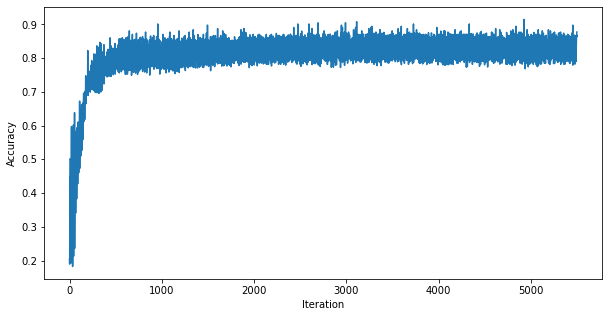

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

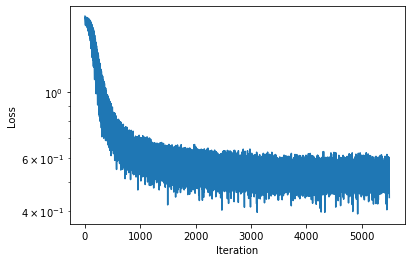

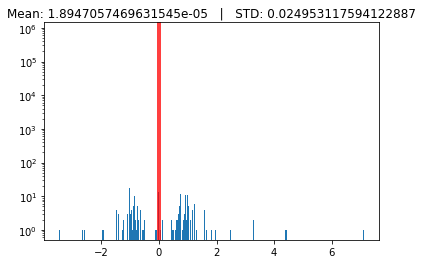

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 10.111498257839722


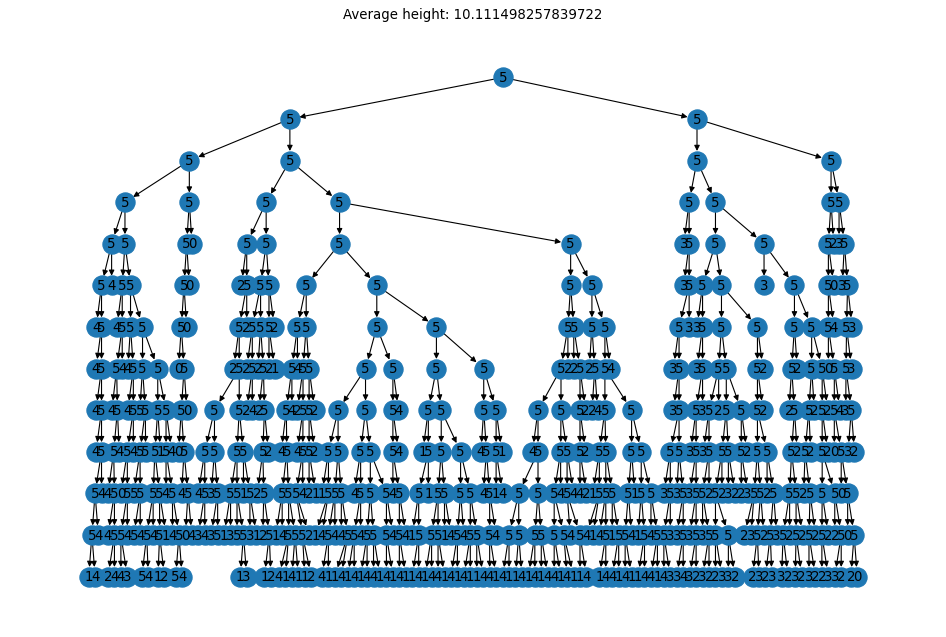

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 287


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/miniconda3/envs/rambo/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Pattern 25

============== Pattern 206 ==============
============== Pattern 207 ==============
============== Pattern 208 ==============
============== Pattern 209 ==============
============== Pattern 210 ==============
============== Pattern 211 ==============
============== Pattern 212 ==============
============== Pattern 213 ==============
============== Pattern 214 ==============
============== Pattern 215 ==============
============== Pattern 216 ==============
============== Pattern 217 ==============
============== Pattern 218 ==============
============== Pattern 219 ==============
============== Pattern 220 ==============
============== Pattern 221 ==============
============== Pattern 222 ==============
============== Pattern 223 ==============
============== Pattern 224 ==============
============== Pattern 225 ==============
============== Pattern 226 ==============
============== Pattern 227 ==============
============== Pattern 228 ==============
============== Pattern 229 =======

In [23]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

Accuracy: 0.7908638119697571


In [24]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

Sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1.0: 0.9723756906077348
layer 2.0: 0.9723756906077348
layer 3.0: 0.9723756906077348
layer 4.0: 0.9723756906077348
layer 5.0: 0.9723756906077348
layer 6.0: 0.9723756906077349
layer 7.0: 0.9723756906077345
layer 8.0: 0.9723756906077345
layer 9.0: 0.9723756906077345
layer 10.0: 0.9723756906077345


## Prune the weights

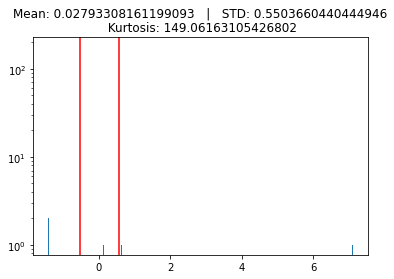

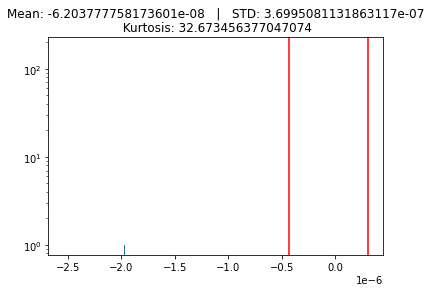

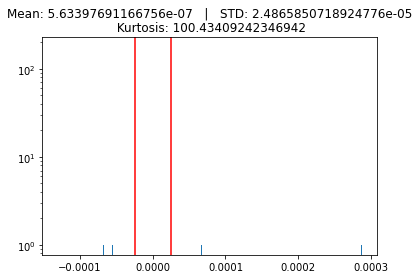

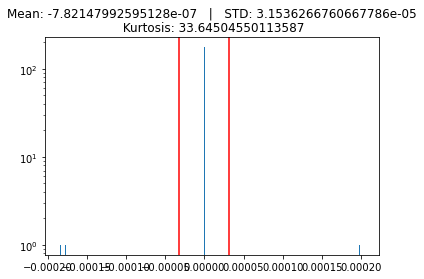

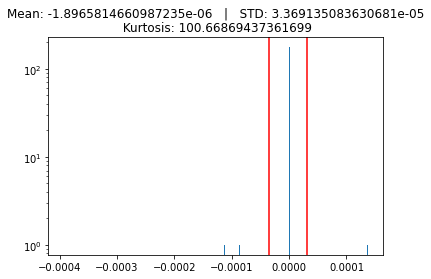

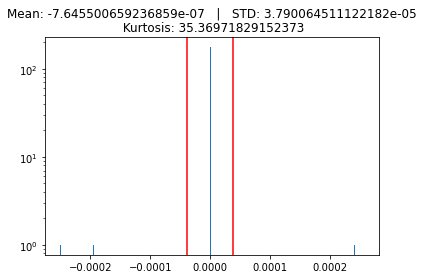

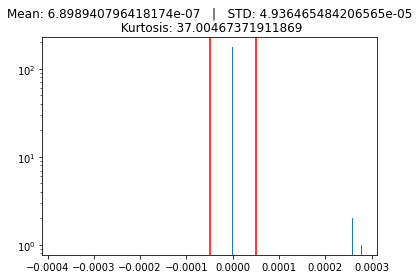

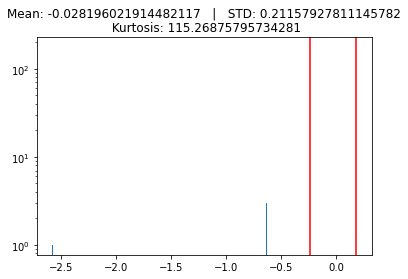

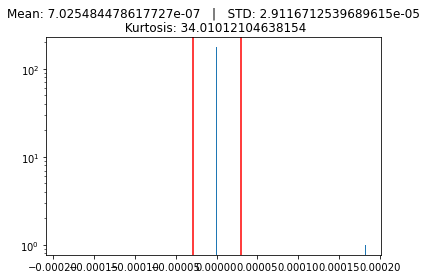

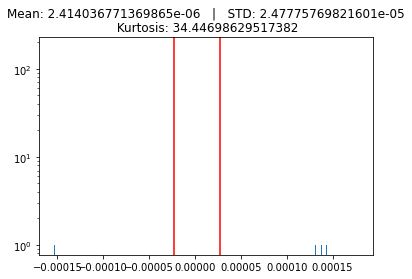

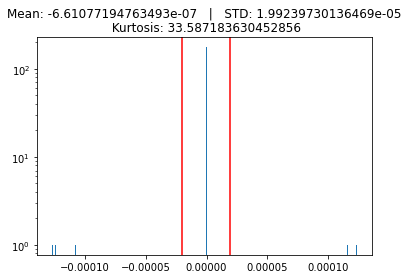

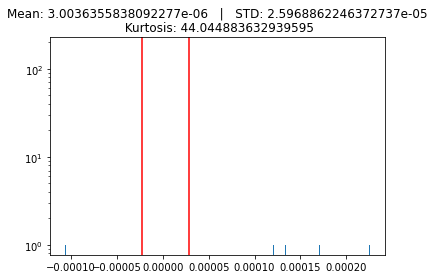

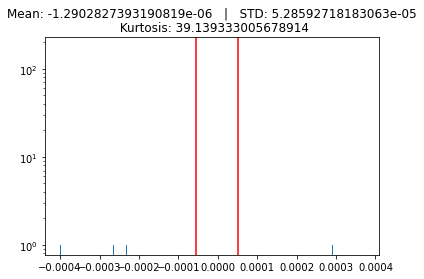

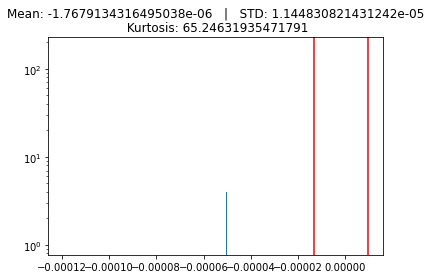

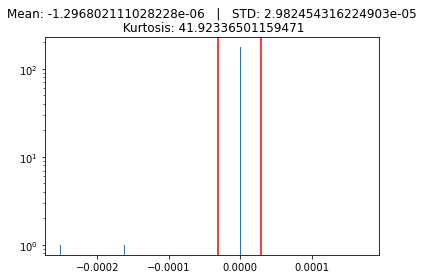

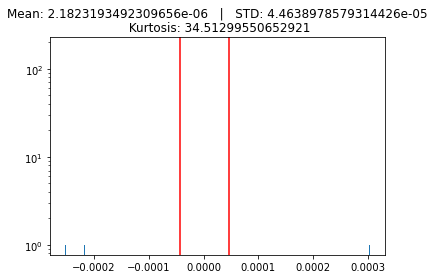

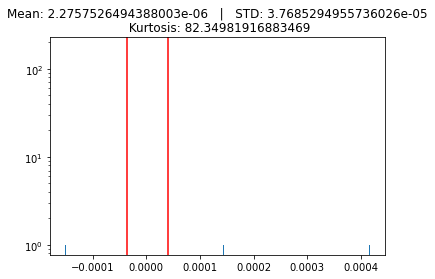

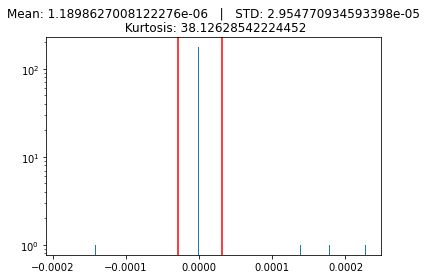

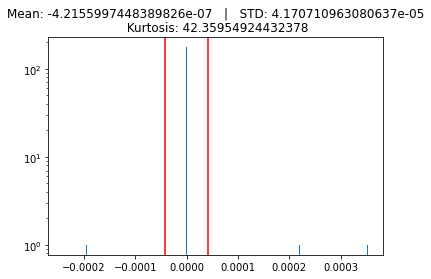

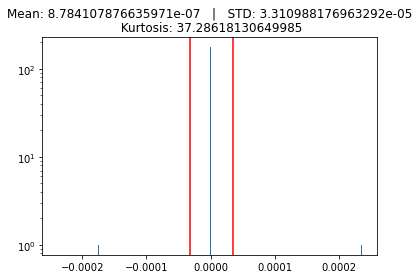

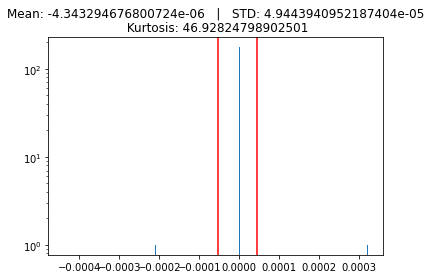

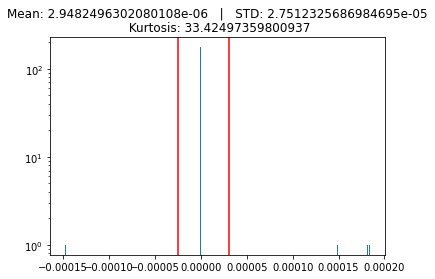

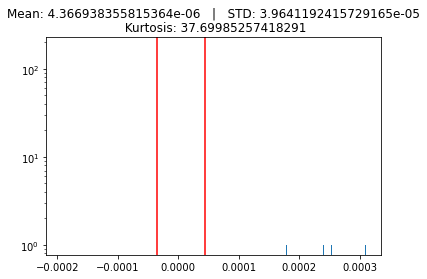

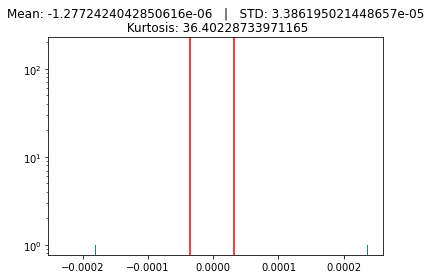

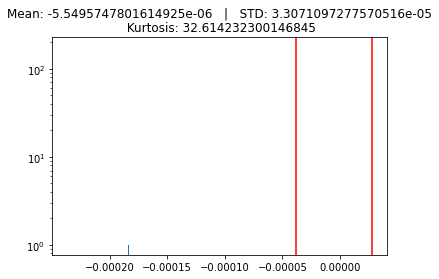

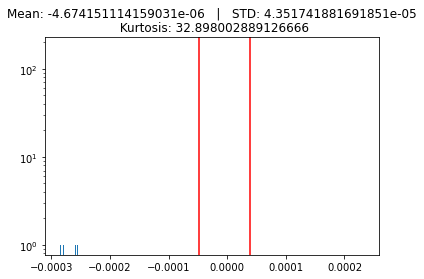

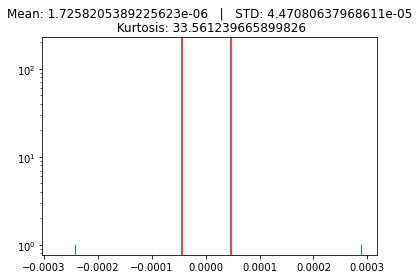

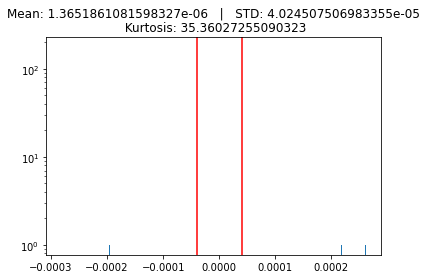

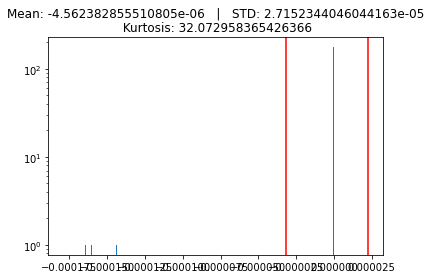

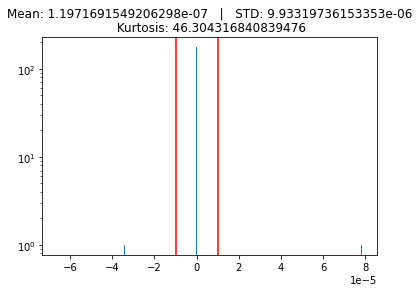

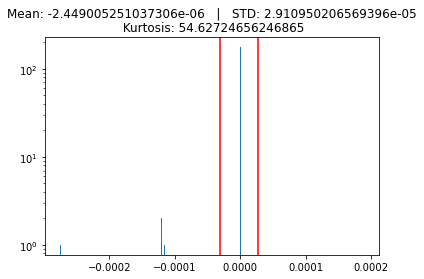

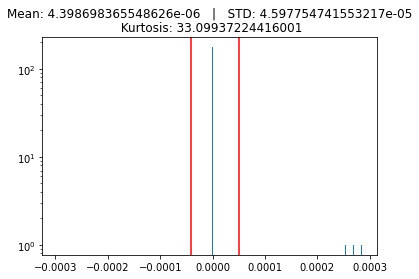

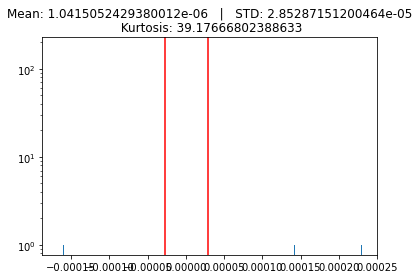

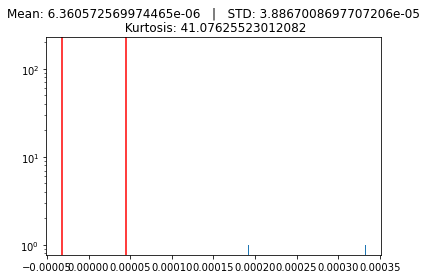

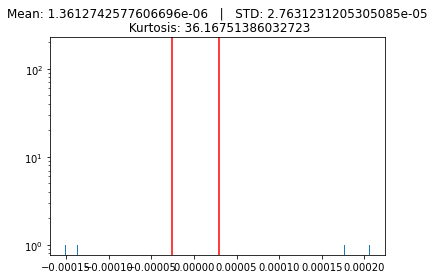

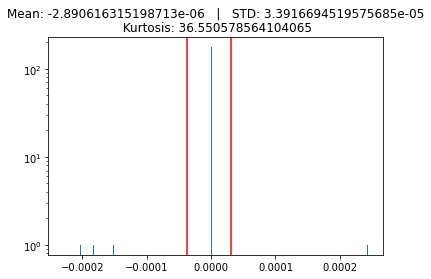

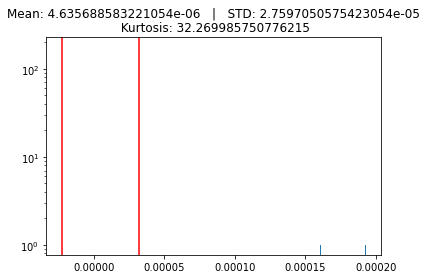

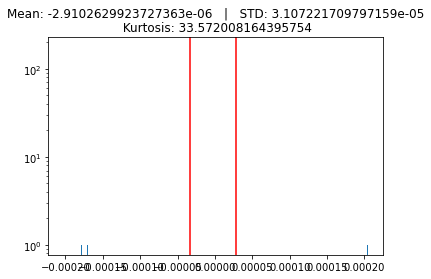

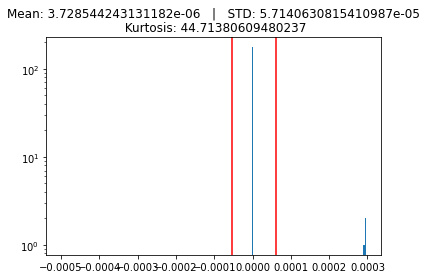

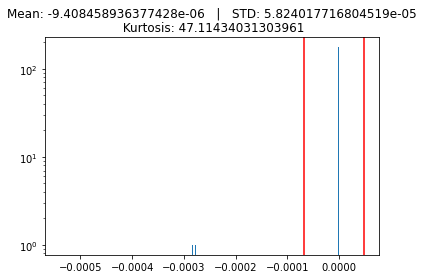

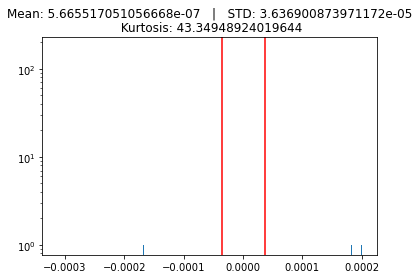

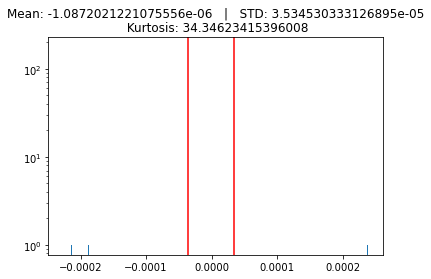

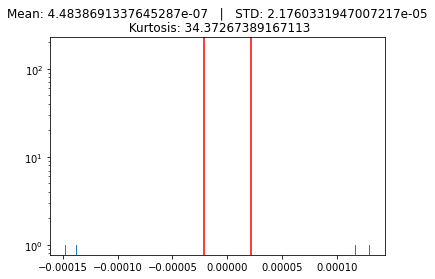

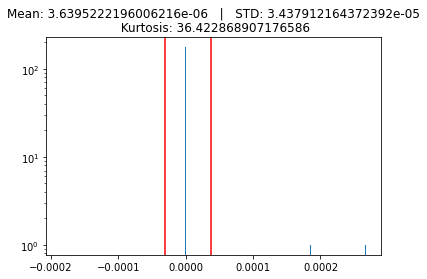

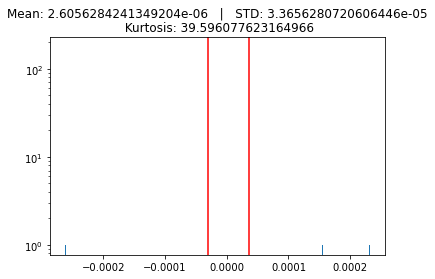

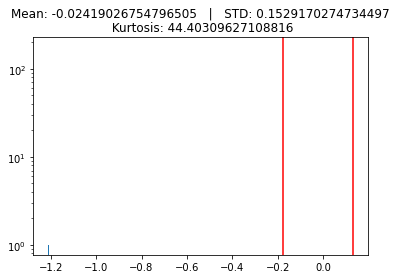

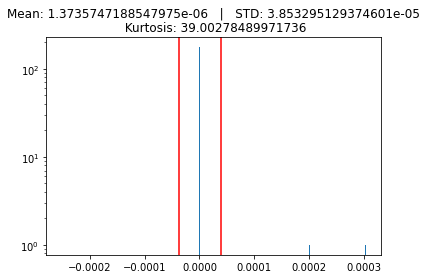

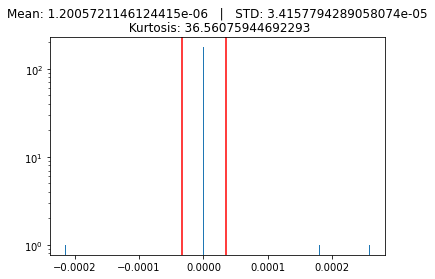

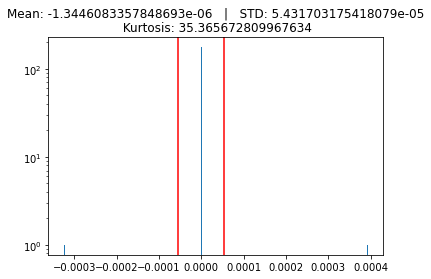

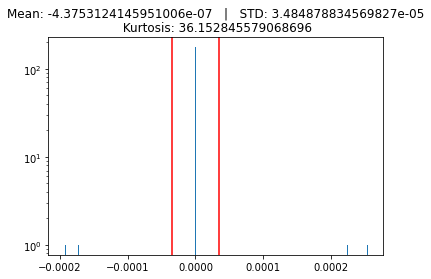

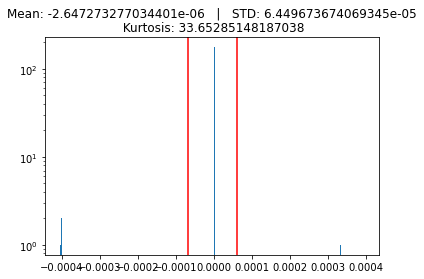

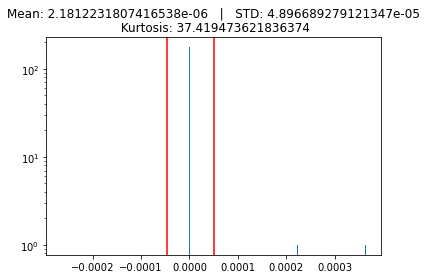

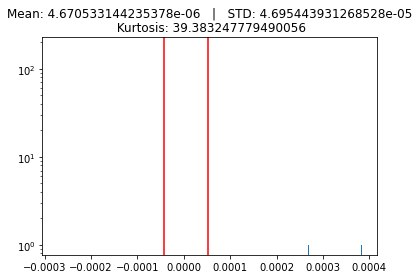

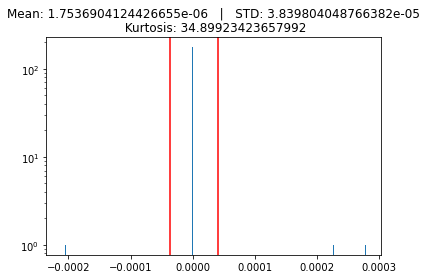

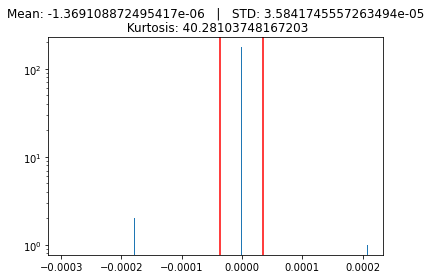

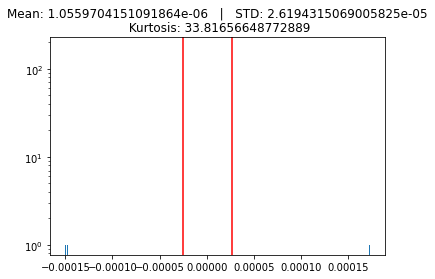

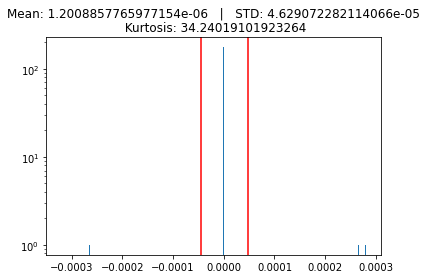

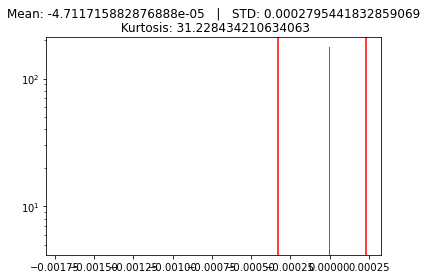

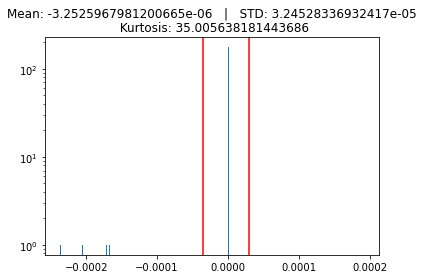

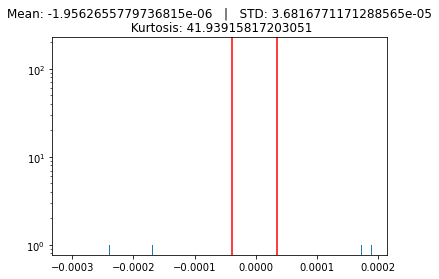

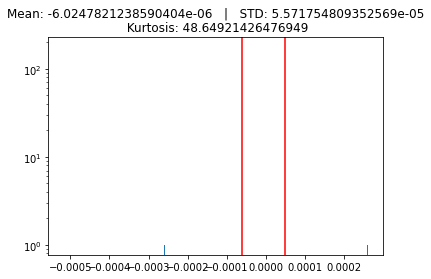

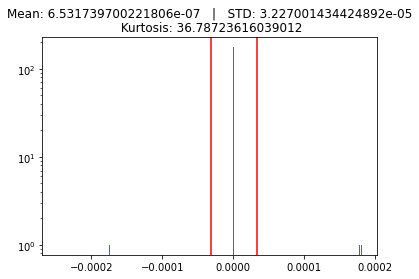

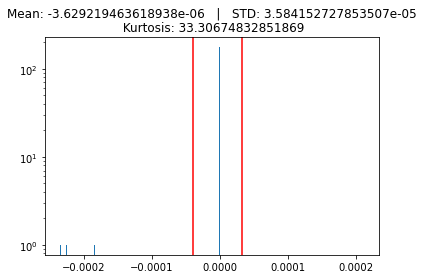

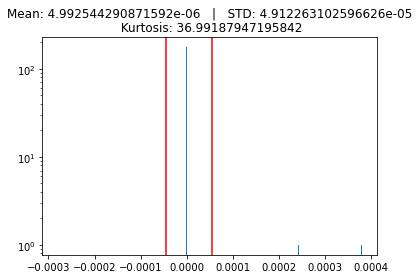

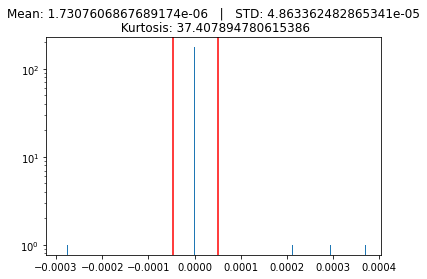

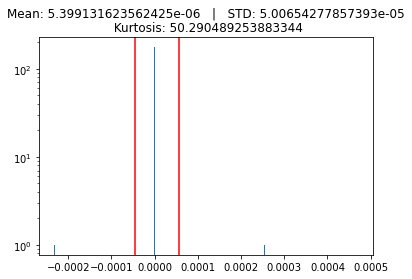

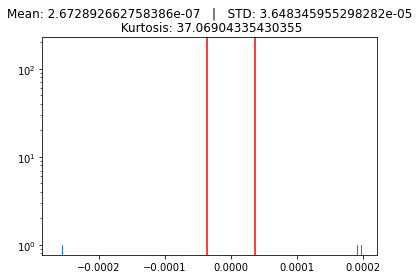

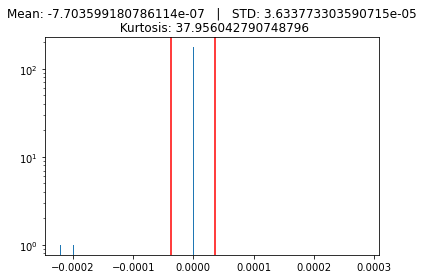

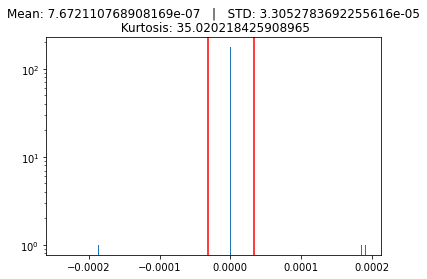

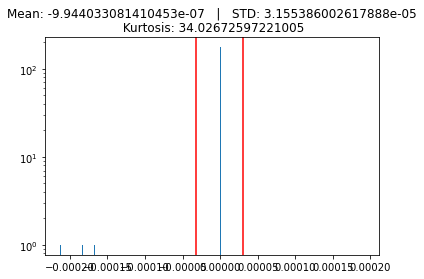

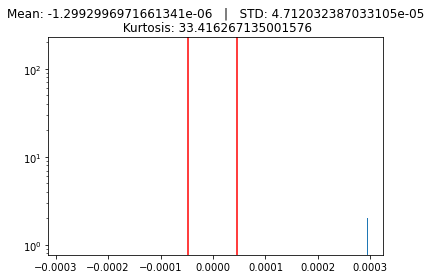

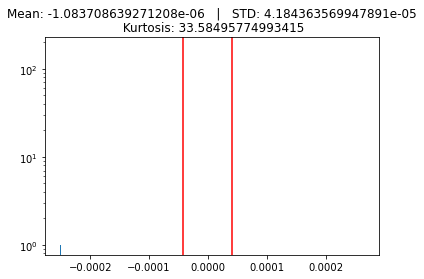

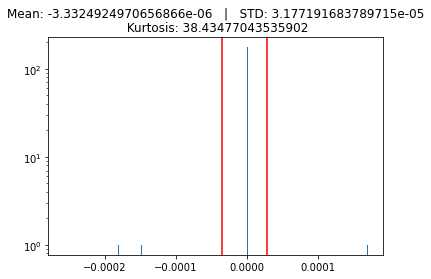

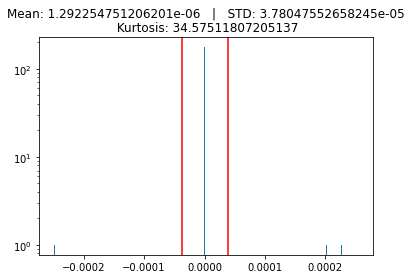

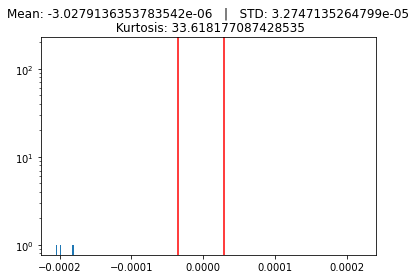

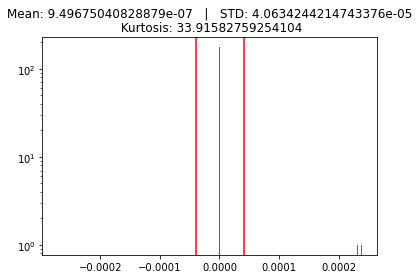

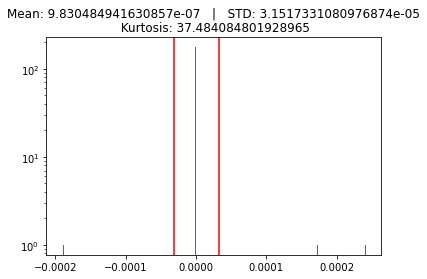

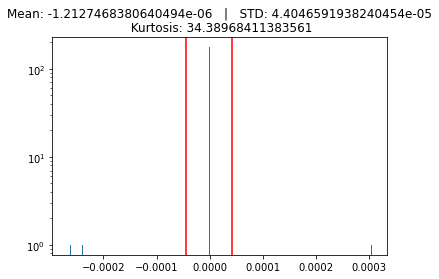

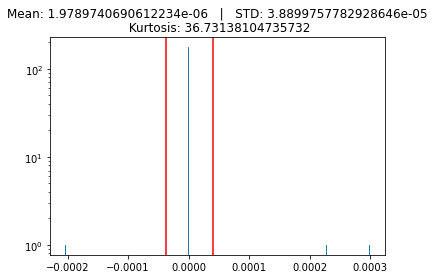

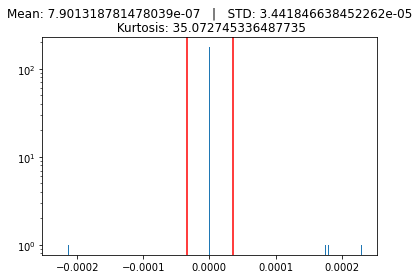

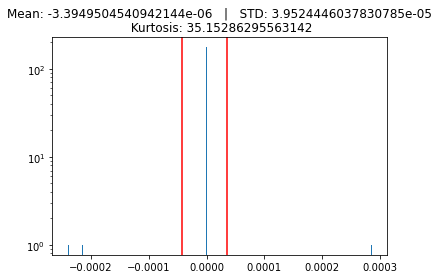

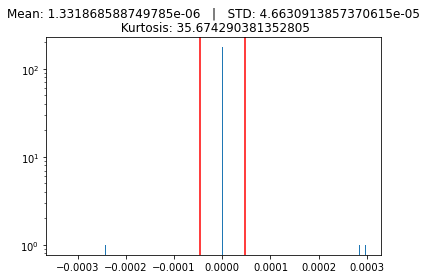

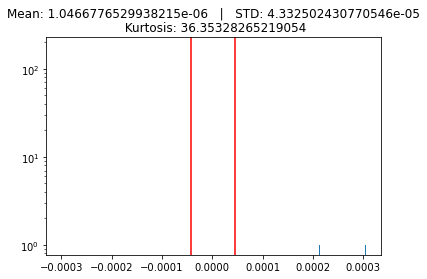

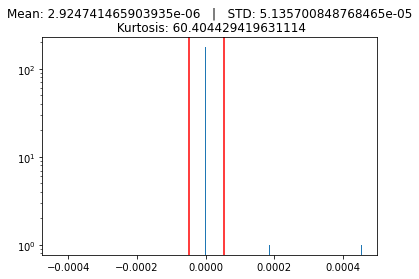

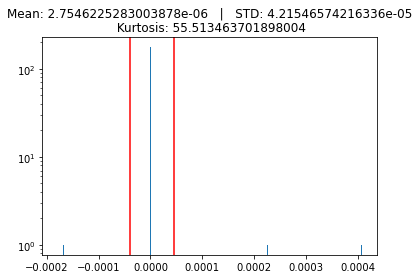

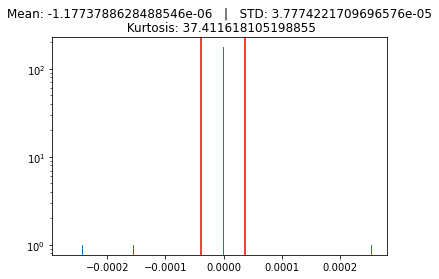

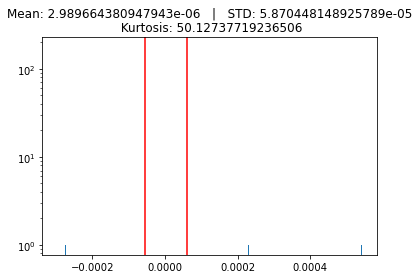

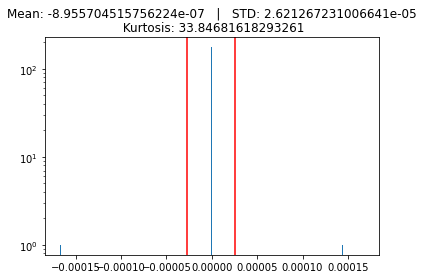

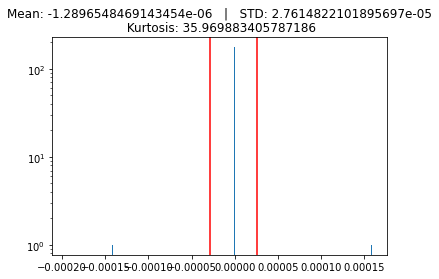

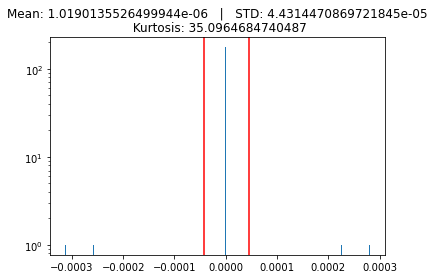

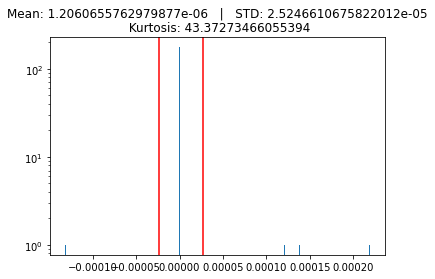

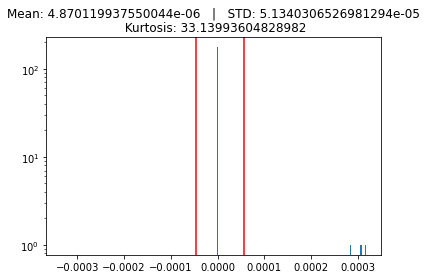

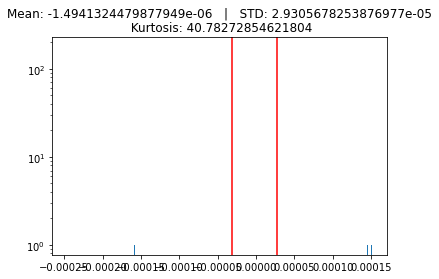

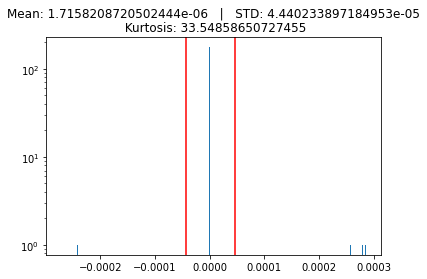

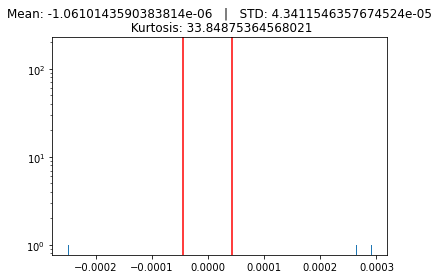

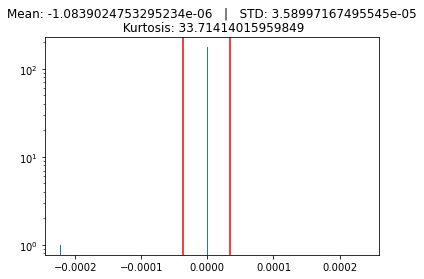

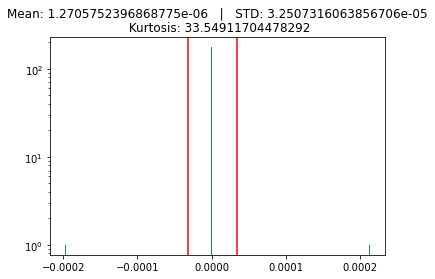

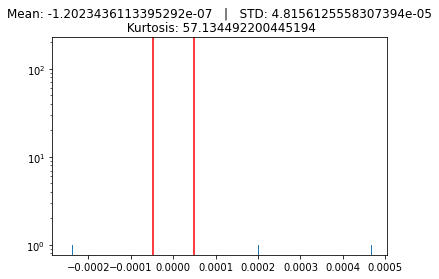

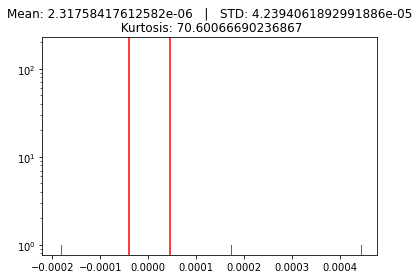

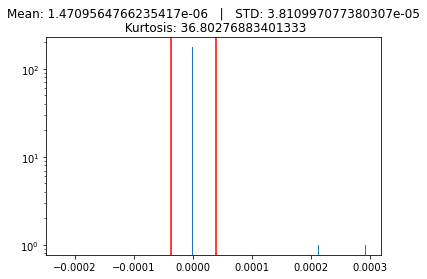

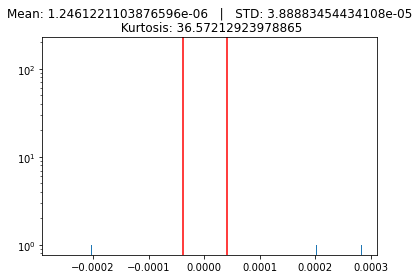

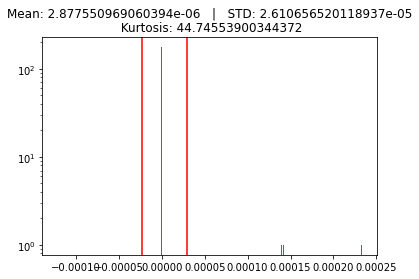

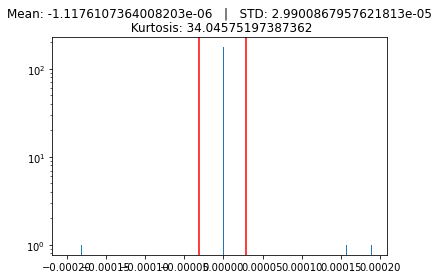

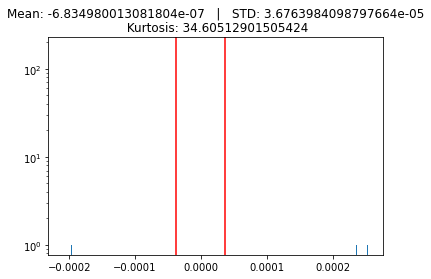

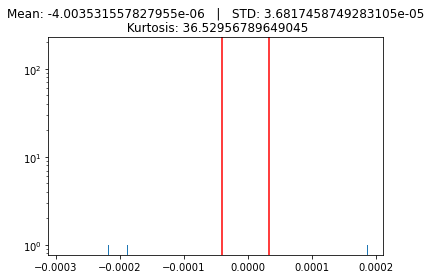

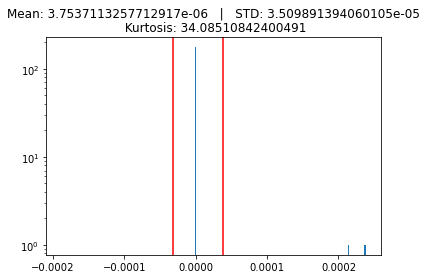

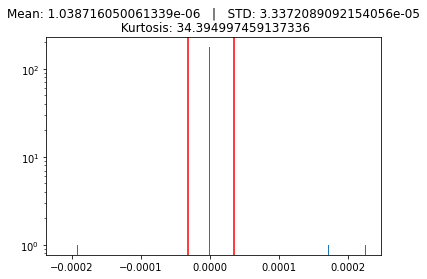

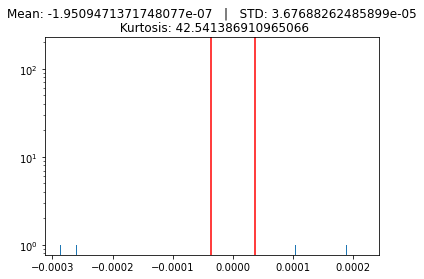

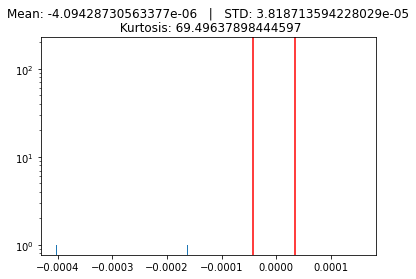

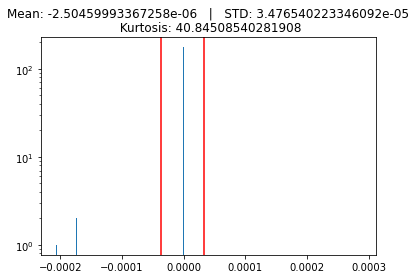

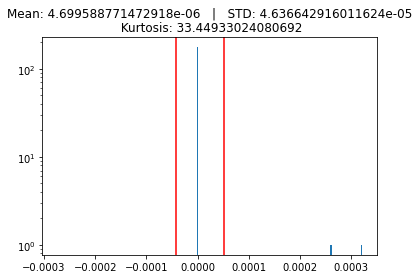

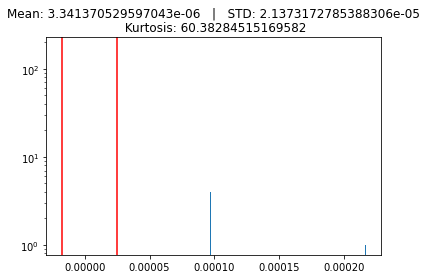

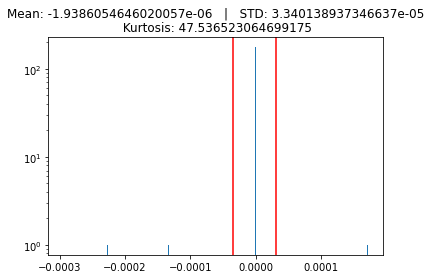

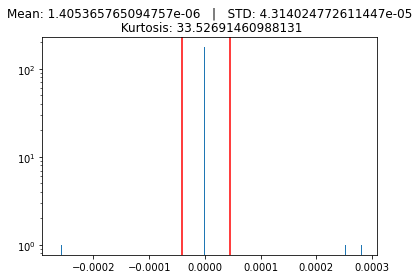

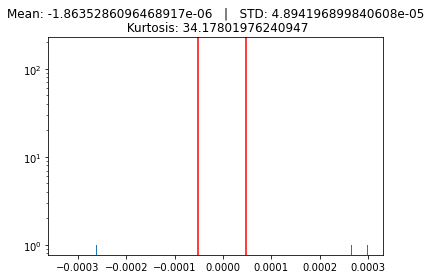

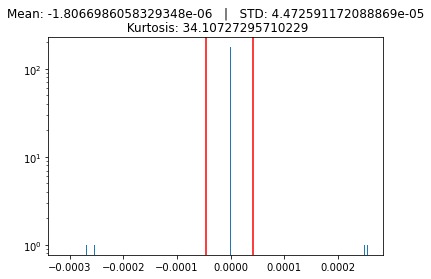

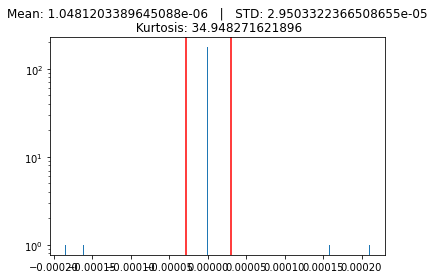

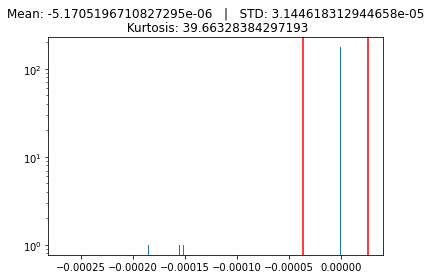

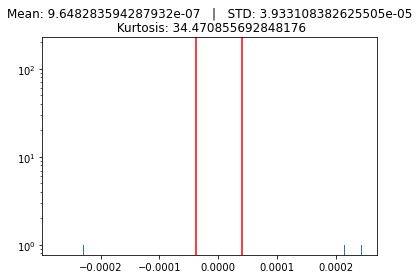

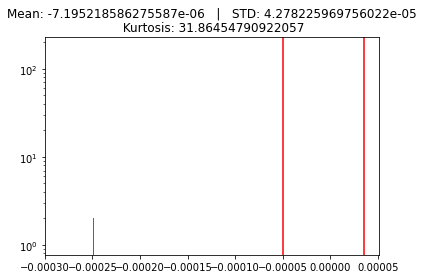

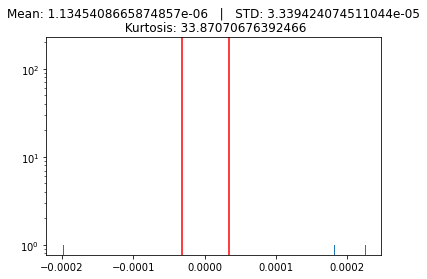

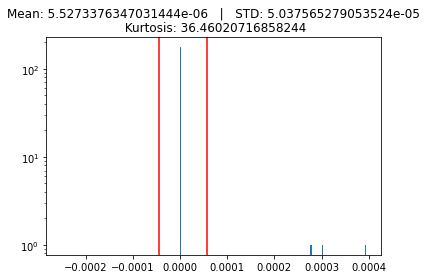

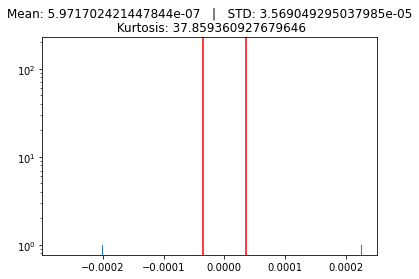

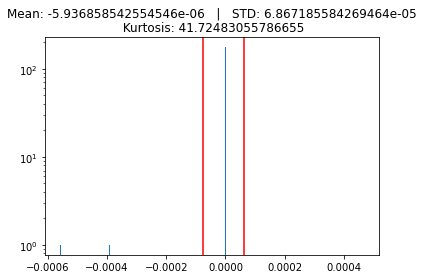

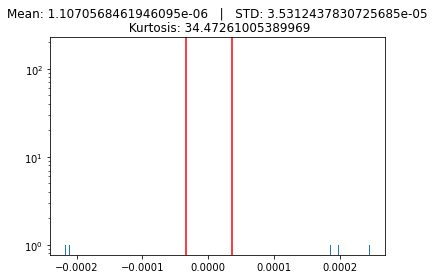

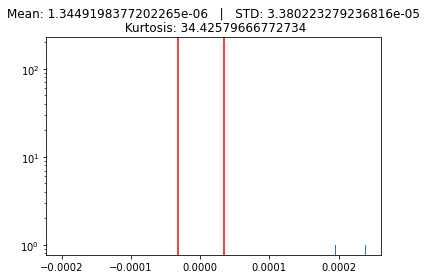

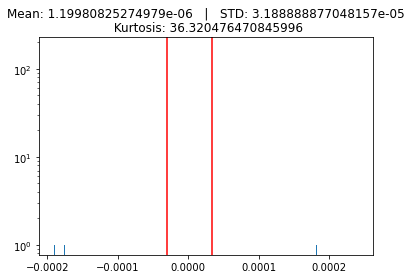

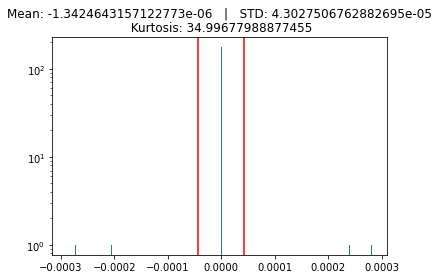

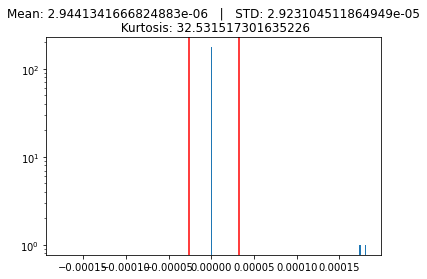

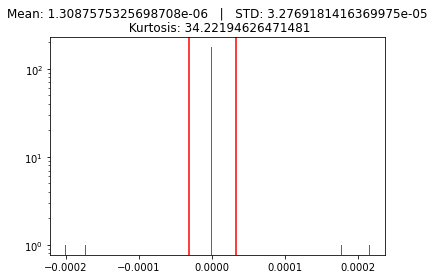

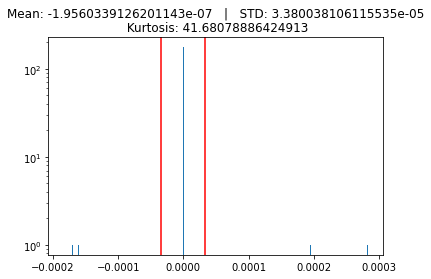

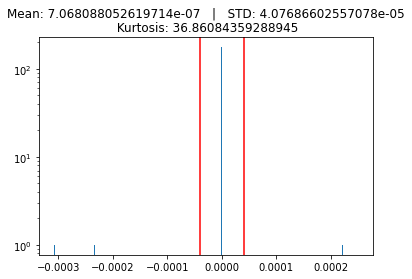

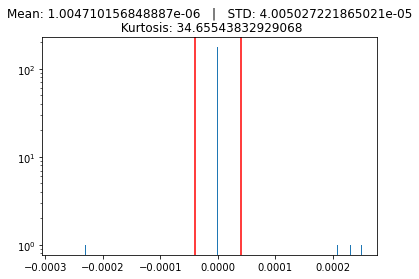

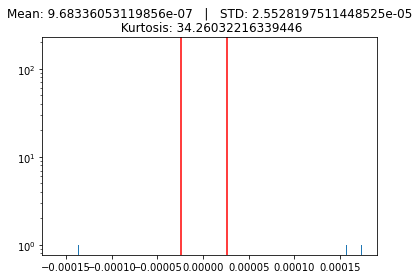

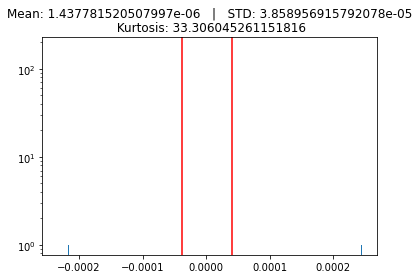

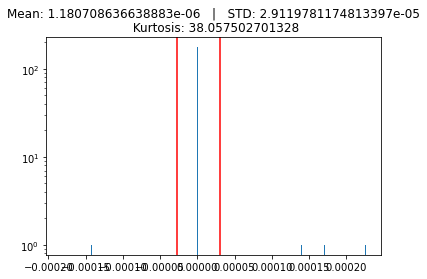

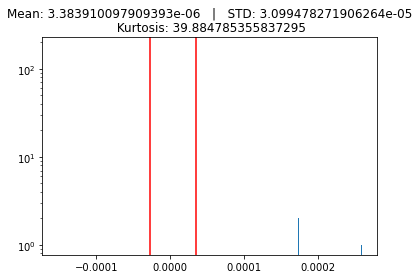

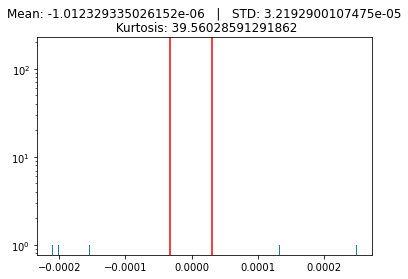

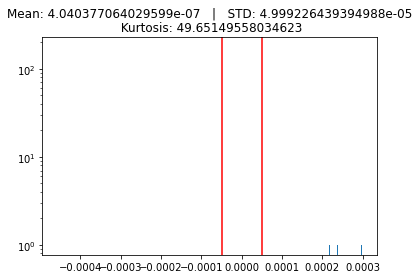

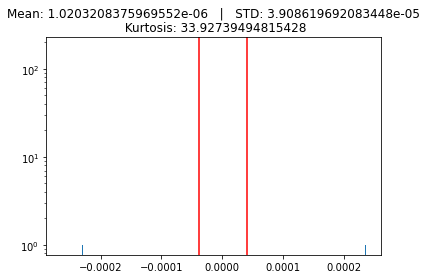

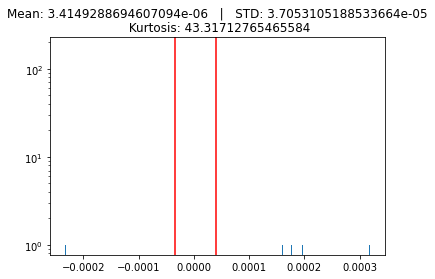

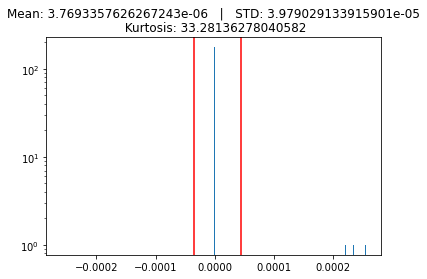

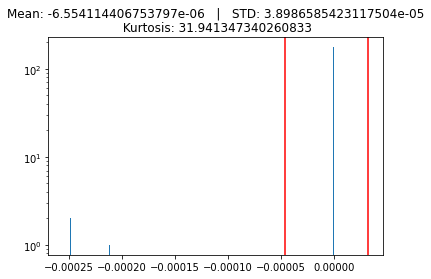

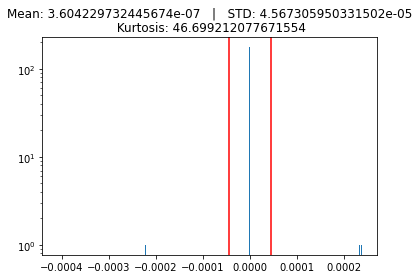

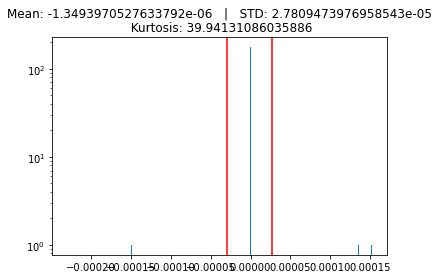

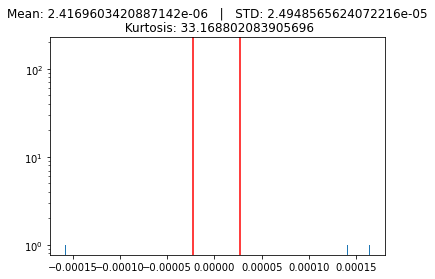

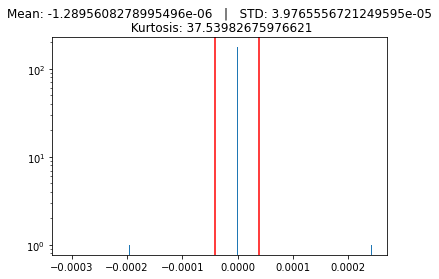

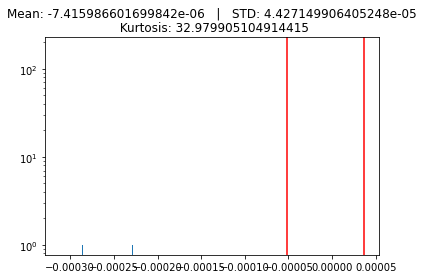

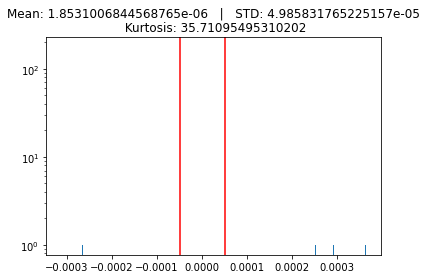

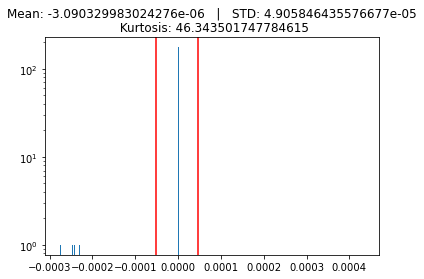

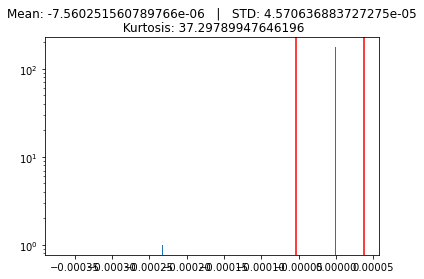

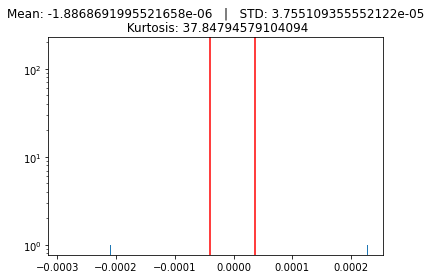

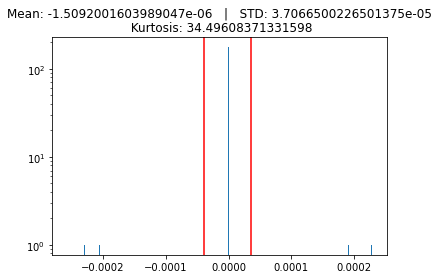

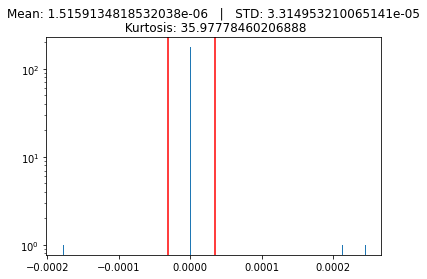

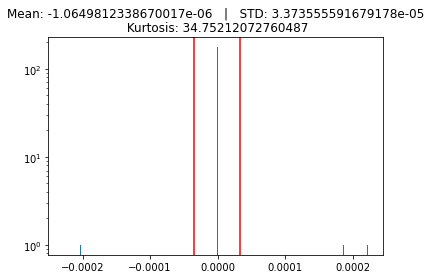

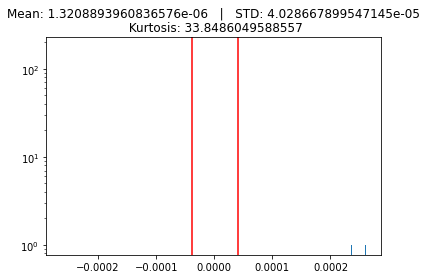

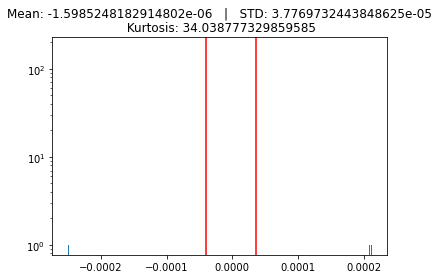

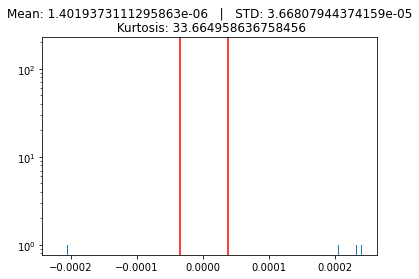

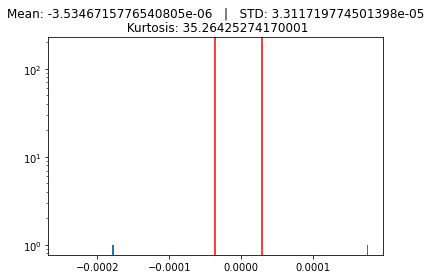

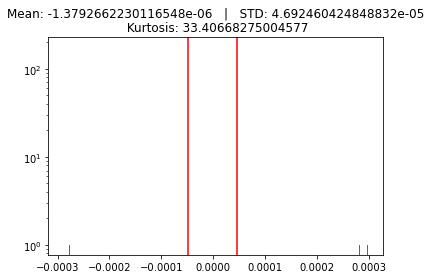

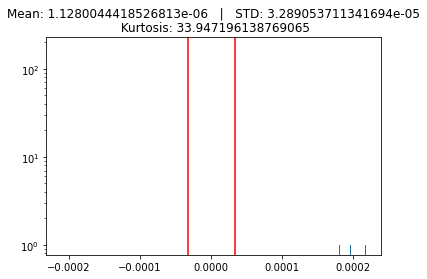

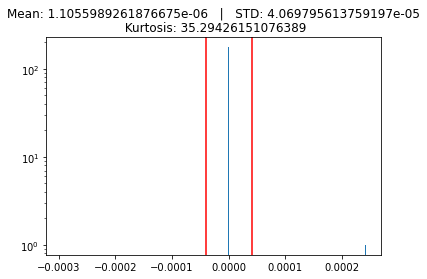

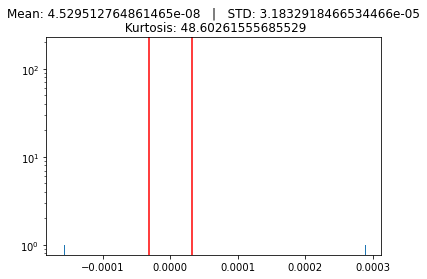

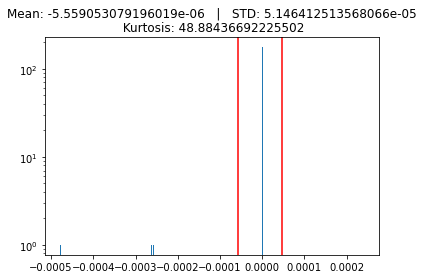

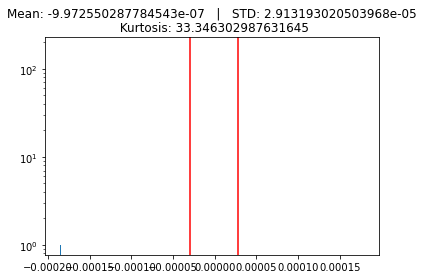

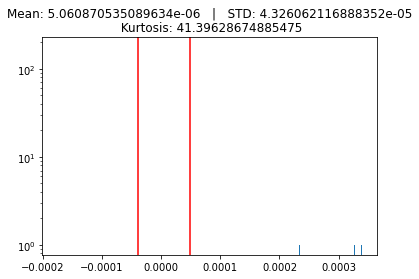

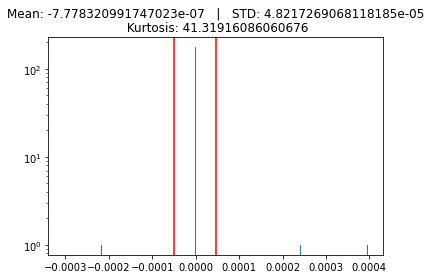

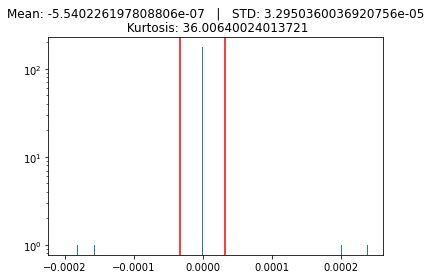

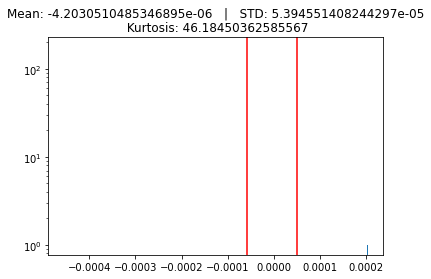

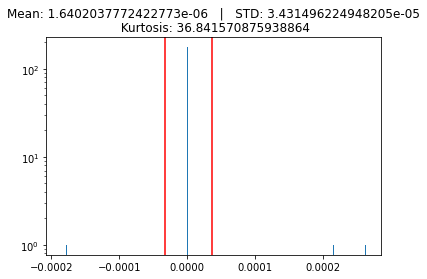

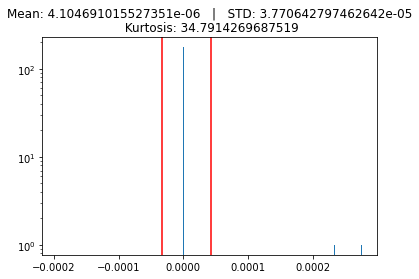

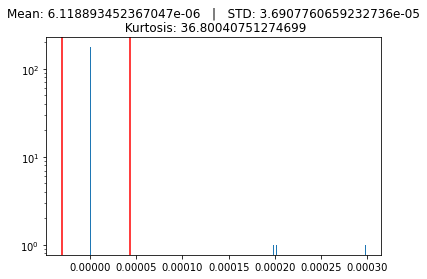

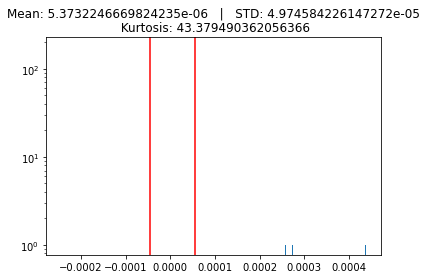

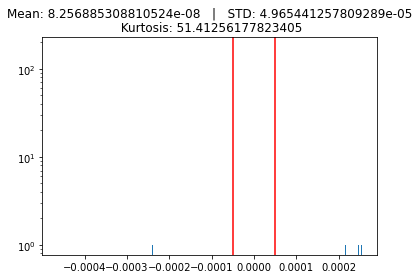

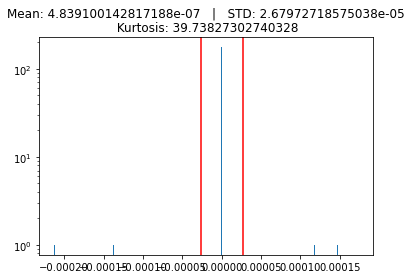

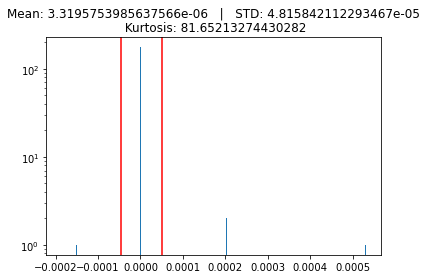

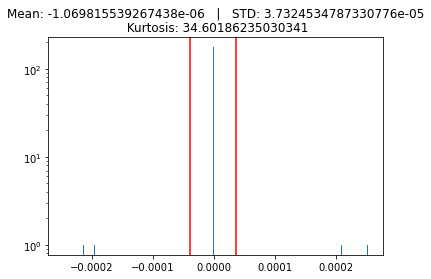

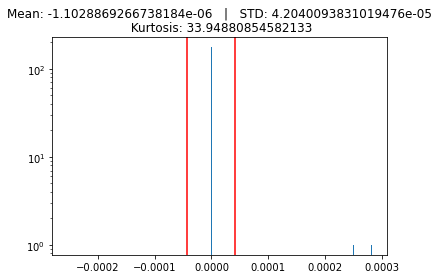

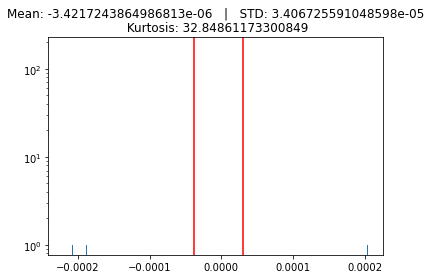

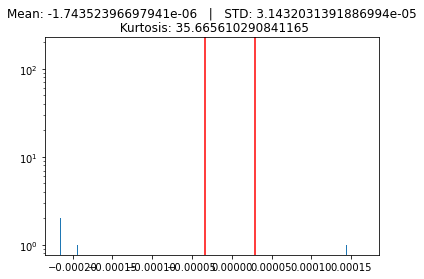

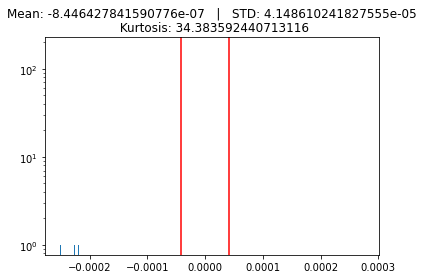

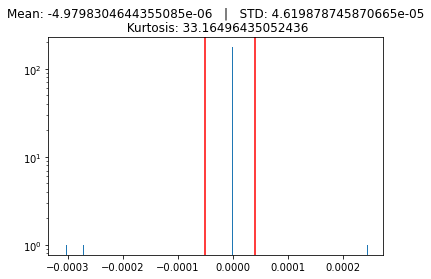

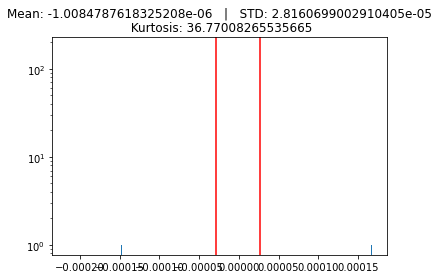

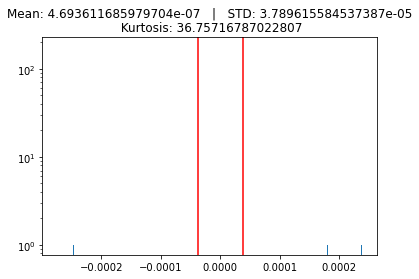

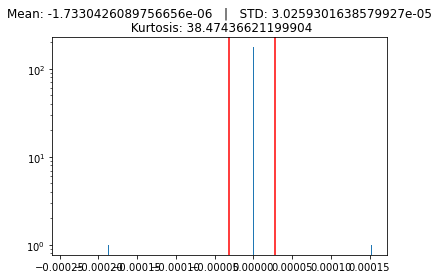

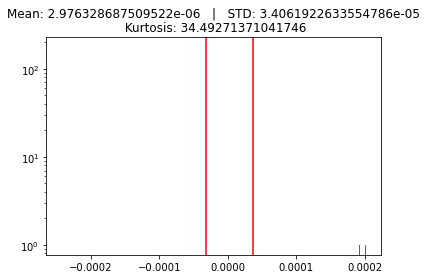

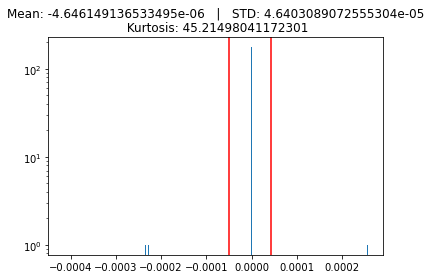

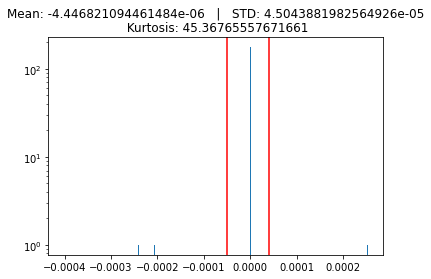

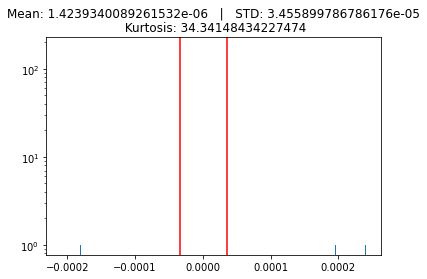

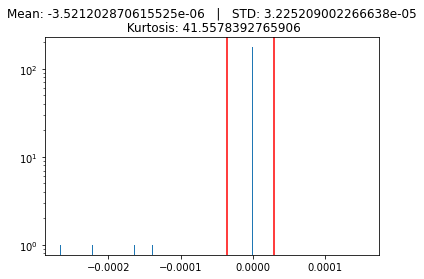

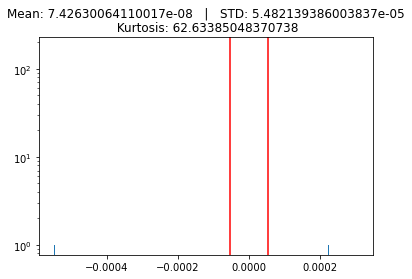

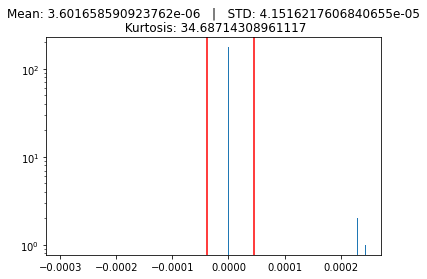

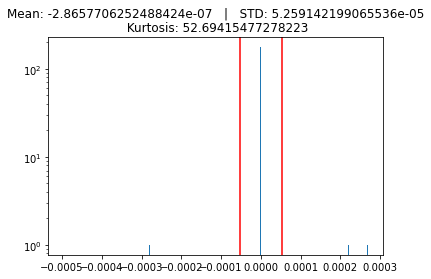

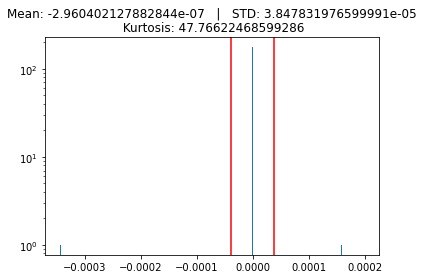

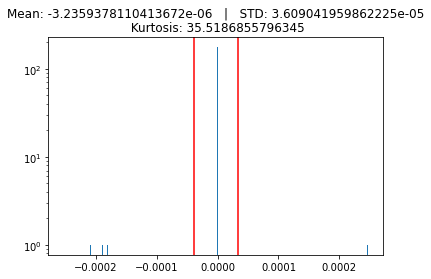

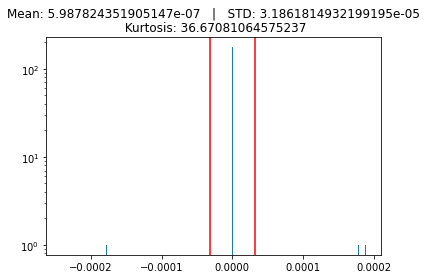

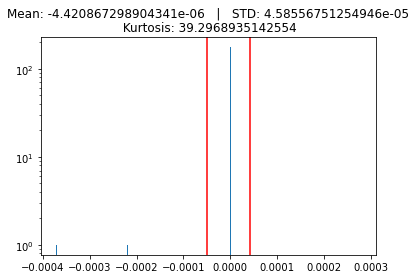

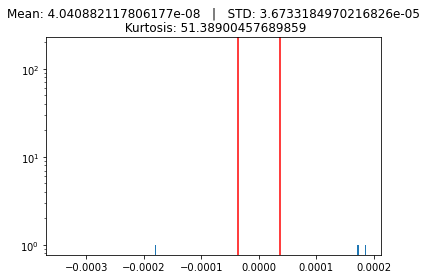

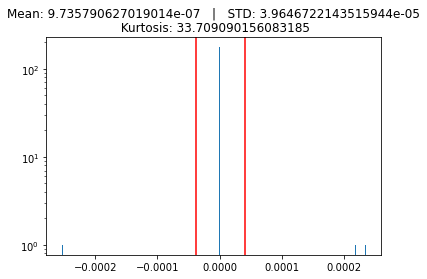

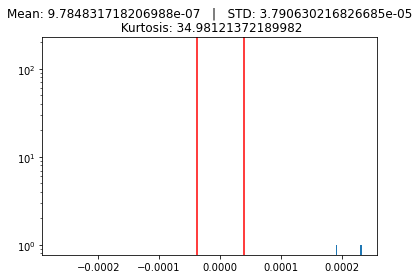

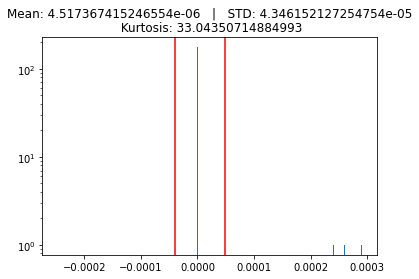

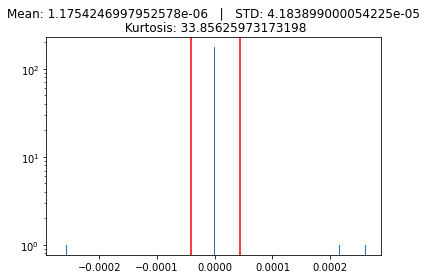

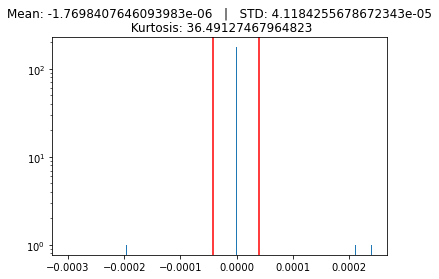

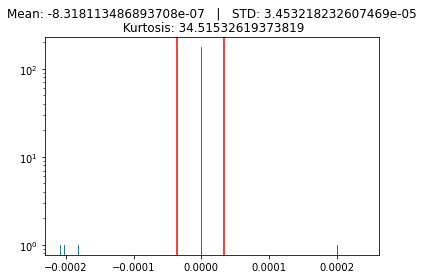

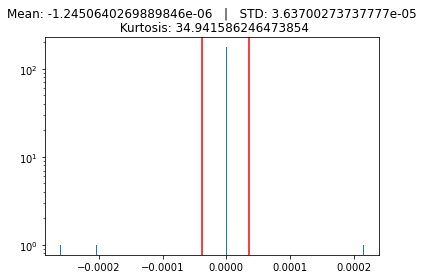

In [25]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [26]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


NameError: name 'tree_copy' is not defined

In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()